# Populating missing values- Basic Emotions

The following section evaluates the optimal approach to populating data with regards to basic emotional theory. The EmoTag1200 dataset contains information regarding the 150 most common emojis, however this is much less data than what is available for dimensional theory. EDA has highlighted patterns which can correlate the basic and dimensional model data so its use in prediction is likely to be helpful.

Present works in the field use a range of prediction methodologies which heavily rely on association to some word centric corpus to predict emoji sentiment with varying suitability for use in the context of this work. Most common methods rely on associations with words adjacent to the emojis within the content under evaluation which is fundamentally contradictory to the hypothesis in question for this work overall (there is evidence that incongruence in emoji and adjacent word sentiment can indicate sarcasm, this work aims to exploit this to improve outcomes for sarcasm prediction) and thus any methodologies which fall into this category will be omitted from consideration.

# Data cleaning and preparation

In [133]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [134]:
#Importing data
df = pd.read_csv("Combined_Emot_Data.csv")

#Create a column that adds the total values for all basic emotions
df['total'] = df['anger'] + df['anticipation'] + df['disgust'] + df['fear'] + df['joy'] + df['sadness'] + df['surprise'] + df['trust']

#Create a list of basic emotions
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

In [135]:
#Creation of datasets using selected best smoothing method- Laplace Estimator
df_le01 = df.copy()
for emotion in emotions:
    df_le01[emotion] = (df_le01[emotion] + 0.1) / (df_le01["total"])

In [136]:
#Check for null values
df.isnull().sum()

unicode               0
emoji                 0
anger                 0
anticipation          0
disgust               0
fear                  0
joy                   0
sadness               0
surprise              0
trust                 0
Position              0
Unicode block         0
le_+                  0
le_-                  0
le_0                  0
sent_score            0
sent_score_class      0
upper_error_class     0
lower_error_class     0
sent_polar            0
primary_basic_emot    0
total                 0
dtype: int64

In [5]:
df_le01.shape

(149, 22)

# Preparation of data for machine learning- Feature Scaling

Scaling is a challenge in the context of this problem set. Due to the nature of emotions, it may not be desirable to scale data within the subclasses of basic and dimensional theory in line with the overall dataset as the greater and lesser relavtive values of each emotion are reflective of the strength of the emotion which is associated with the emoji itself. This is additional relevant and important information which should be retained. However this is not to say that the two models data is appropriately scaled for optimal compatability at present. The following section aims to evaluate if feature scaling for numeric values is necessary, and if so, the optimal method to do so.

In [137]:
#Check for columns containing numerical data
df_le01.dtypes
#They fall into three classes- basic and dimensional model data and position of emoji in text

unicode                object
emoji                  object
anger                 float64
anticipation          float64
disgust               float64
fear                  float64
joy                   float64
sadness               float64
surprise              float64
trust                 float64
Position              float64
Unicode block          object
le_+                  float64
le_-                  float64
le_0                  float64
sent_score            float64
sent_score_class       object
upper_error_class      object
lower_error_class      object
sent_polar             object
primary_basic_emot     object
total                 float64
dtype: object

In [138]:
#Check means
df_le01['total'].mean(), df_le01['sent_score'].mean(), df_le01['le_0'].mean()

(1.5528859060402682, 0.32754414318448444, 0.3179537187036618)

In [139]:
#Check medians
df_le01['total'].median(), df_le01['sent_score'].median(), df_le01['le_0'].median()

(1.6100000000000003, 0.4169909208819715, 0.2786885245901639)

In [140]:
#Check ranges
df_le01.describe()

anger  anticipation     disgust        fear         joy  \
count  149.000000    149.000000  149.000000  149.000000  149.000000   
mean     0.154453      0.296006    0.164143    0.159612    0.326227   
std      0.134433      0.187403    0.138884    0.125805    0.211109   
min      0.043290      0.075630    0.043290    0.043290    0.033898   
25%      0.066667      0.188406    0.068966    0.080000    0.118644   
50%      0.112360      0.248731    0.123288    0.120482    0.357143   
75%      0.183908      0.344371    0.213953    0.203209    0.476636   
max      0.909091      1.636364    0.909091    0.909091    1.181818   

          sadness    surprise       trust    Position        le_+        le_-  \
count  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000   
mean     0.164158    0.196485    0.275838    0.748170    0.504795    0.177251   
std      0.136795    0.117012    0.188641    0.117897    0.171828    0.165133   
min      0.043290    0.040816    0.048544    0.193496    0.123188    0.008403   
25%      0.071942    0.125749    0.139073    0.701409    0.359684    0.052632   
50%      0.116279    0.175115    0.256757    0.779044    0.526316    0.107143   
75%      0.207207    0.238095    0.351598    0.827467    0.633523    0.264642   
max      0.909091    0.909091    1.285714    0.919654    0.798969    0.600583   

             le_0  sent_score       total  
count  149.000000  149.000000  149.000000  
mean     0.317954    0.327544    1.552886  
std      0.140179    0.306492    0.622342  
min      0.108037   -0.396501    0.110000  
25%      0.221106    0.125984    1.160000  
50%      0.278689    0.416991    1.610000  
75%      0.367089    0.559311    1.970000  
max      0.855072    0.778351    3.150000

Proposed scaling methodology (Basic theory data): There are three primary numeric parameter categories for emotion sentiment in this dataset; 'total'- sum of all affinities to the basic emotion categories, 'sent_score'- polar score based on a positive/negative scale from the dimensional model and 'le_0'- value from dimensional model which represents degree of arousal with regards to a particular emotion. 'Total' and 'sent_score' are each made up of the cumulation of values from other columns and thus are a good manner in which to normalise influence of values across the two models. These parameters will be scaled and the parameters which they are comprised of will be rescaled based on the scaled values within their row rather than with consideration to any other row. For example where the core parameters were rescaled from 0 to 1 using a min-max scaler (normalisation) and emoji X has a 'total' value which is scaled to 0.8 and it had a 50% affinity to anger the value associated with anger would be 0.4 rather than 0.5.

Note that the purpose of this methods it to address the observation that it is not necessarily valid to normalise the components of these core parameters as this would result in bias in many cases. For example note that anger and anticipation have ranges of 0-1 and 0-0.81 respectively. Where min-max scaling is applied to these parameters without consideration to each other there would be an increase in the perception of affinify to the emotion of anticipation where it is not the case in reality. The proposed method aims to avoid this.

In [141]:
#Add another column for dimensional theory processing- sum of +ve and -ve sentiment scores
df_le01['dt_total_prescale'] = df_le01['le_+'] + df_le01['le_-']

In [142]:
#Define columns to be scaled
scale_cols=['total', 'sent_score', 'le_0', 'Position']

#Apply min max scaler to relevant columns
def scaling(df_le01):
    scaler = MinMaxScaler(feature_range=(0.01, 1))
    df_le01[scale_cols]=scaler.fit_transform(df_le01[scale_cols])
    return df_le01

df_le01 = scaling(df_le01)

In [143]:
#Verify it worked
df_le01.describe()

anger  anticipation     disgust        fear         joy  \
count  149.000000    149.000000  149.000000  149.000000  149.000000   
mean     0.154453      0.296006    0.164143    0.159612    0.326227   
std      0.134433      0.187403    0.138884    0.125805    0.211109   
min      0.043290      0.075630    0.043290    0.043290    0.033898   
25%      0.066667      0.188406    0.068966    0.080000    0.118644   
50%      0.112360      0.248731    0.123288    0.120482    0.357143   
75%      0.183908      0.344371    0.213953    0.203209    0.476636   
max      0.909091      1.636364    0.909091    0.909091    1.181818   

          sadness    surprise       trust    Position        le_+        le_-  \
count  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000   
mean     0.164158    0.196485    0.275838    0.766209    0.504795    0.177251   
std      0.136795    0.117012    0.188641    0.160733    0.171828    0.165133   
min      0.043290    0.040816    0.048544    0.010000    0.123188    0.008403   
25%      0.071942    0.125749    0.139073    0.702458    0.359684    0.052632   
50%      0.116279    0.175115    0.256757    0.808300    0.526316    0.107143   
75%      0.207207    0.238095    0.351598    0.874317    0.633523    0.264642   
max      0.909091    0.909091    1.285714    1.000000    0.798969    0.600583   

             le_0  sent_score       total  dt_total_prescale  
count  149.000000  149.000000  149.000000         149.000000  
mean     0.288190    0.620124    0.479887           0.682046  
std      0.185770    0.258268    0.202671           0.140179  
min      0.010000    0.010000    0.010000           0.144928  
25%      0.159843    0.450277    0.351941           0.632911  
50%      0.236154    0.695497    0.498487           0.721311  
75%      0.353305    0.815424    0.615724           0.778894  
max      1.000000    1.000000    1.000000           0.891963

In [144]:
#Scale all data for basic emotions based on their scaled values from the total column

#Re-Create a column that contains the sum of all basic emotion values
df_le01['total_prescale'] = df_le01['anger'] + df_le01['anticipation'] + df_le01['disgust'] + df_le01['fear'] + df_le01['joy'] + df_le01['sadness'] + df_le01['surprise'] + df_le01['trust']

#Determine scaling factor for the row
df_le01['scaling_factor'] = df_le01['total_prescale']/df_le01['total']

#Scale each basic emotion value using the scaling factor
df_le01['anger'] = df_le01['anger']/df_le01['scaling_factor']
df_le01['anticipation'] = df_le01['anticipation']/df_le01['scaling_factor']
df_le01['disgust'] = df_le01['disgust']/df_le01['scaling_factor']
df_le01['fear'] = df_le01['fear']/df_le01['scaling_factor']
df_le01['joy'] = df_le01['joy']/df_le01['scaling_factor']
df_le01['sadness'] = df_le01['sadness']/df_le01['scaling_factor']
df_le01['surprise'] = df_le01['surprise']/df_le01['scaling_factor']
df_le01['trust'] = df_le01['trust']/df_le01['scaling_factor']

In [145]:
#Verify this worked
df_le01.describe()

anger  anticipation     disgust        fear         joy  \
count  149.000000    149.000000  149.000000  149.000000  149.000000   
mean     0.042490      0.076001    0.047440    0.047364    0.090365   
std      0.042791      0.035287    0.046072    0.048874    0.070341   
min      0.001099      0.001978    0.001099    0.001099    0.001429   
25%      0.019370      0.051549    0.019309    0.019370    0.024484   
50%      0.022793      0.073606    0.022623    0.026510    0.070020   
75%      0.047478      0.100284    0.057727    0.054324    0.149256   
max      0.257910      0.215172    0.185523    0.266749    0.256943   

          sadness    surprise       trust    Position        le_+        le_-  \
count  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000   
mean     0.049037    0.055693    0.071498    0.766209    0.504795    0.177251   
std      0.055080    0.036799    0.046182    0.160733    0.171828    0.165133   
min      0.001099    0.001099    0.001099    0.010000    0.123188    0.008403   
25%      0.019782    0.029197    0.039906    0.702458    0.359684    0.052632   
50%      0.023358    0.049237    0.058336    0.808300    0.526316    0.107143   
75%      0.047865    0.073565    0.095147    0.874317    0.633523    0.264642   
max      0.259172    0.223153    0.216957    1.000000    0.798969    0.600583   

             le_0  sent_score       total  dt_total_prescale  total_prescale  \
count  149.000000  149.000000  149.000000         149.000000      149.000000   
mean     0.288190    0.620124    0.479887           0.682046        1.736922   
std      0.185770    0.258268    0.202671           0.140179        0.837552   
min      0.010000    0.010000    0.010000           0.144928        1.253968   
25%      0.159843    0.450277    0.351941           0.632911        1.406091   
50%      0.236154    0.695497    0.498487           0.721311        1.496894   
75%      0.353305    0.815424    0.615724           0.778894        1.689655   
max      1.000000    1.000000    1.000000           0.891963        8.272727   

       scaling_factor  
count      149.000000  
mean        13.748058  
std         73.215495  
min          1.253968  
25%          2.283640  
50%          3.002876  
75%          4.800964  
max        827.272727

In [146]:
#Remove columns that are no longer needed
df_le01 = df_le01.drop(columns=['total_prescale', 'scaling_factor'])

In [147]:
#Repeat similar method for dimensional theory data- only +ve and -ve and necessary

#Re-Create a column that contains the sum of all basic emotion values
df_le01['total'] = df_le01['le_+'] + df_le01['le_-']

#Determine scaling factor for the row
df_le01['scaling_factor'] = df_le01['dt_total_prescale']/df_le01['total']

#Scale each basic emotion value using the scaling factor
df_le01['le_+'] = df_le01['le_+']/df_le01['scaling_factor']

In [148]:
#Remove columns that are no longer needed
df_le01 = df_le01.drop(columns=['dt_total_prescale', 'scaling_factor', 'total'])

In [149]:
#Verify transformations are ok
df_le01.describe()

anger  anticipation     disgust        fear         joy  \
count  149.000000    149.000000  149.000000  149.000000  149.000000   
mean     0.042490      0.076001    0.047440    0.047364    0.090365   
std      0.042791      0.035287    0.046072    0.048874    0.070341   
min      0.001099      0.001978    0.001099    0.001099    0.001429   
25%      0.019370      0.051549    0.019309    0.019370    0.024484   
50%      0.022793      0.073606    0.022623    0.026510    0.070020   
75%      0.047478      0.100284    0.057727    0.054324    0.149256   
max      0.257910      0.215172    0.185523    0.266749    0.256943   

          sadness    surprise       trust    Position        le_+        le_-  \
count  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000   
mean     0.049037    0.055693    0.071498    0.766209    0.504795    0.177251   
std      0.055080    0.036799    0.046182    0.160733    0.171828    0.165133   
min      0.001099    0.001099    0.001099    0.010000    0.123188    0.008403   
25%      0.019782    0.029197    0.039906    0.702458    0.359684    0.052632   
50%      0.023358    0.049237    0.058336    0.808300    0.526316    0.107143   
75%      0.047865    0.073565    0.095147    0.874317    0.633523    0.264642   
max      0.259172    0.223153    0.216957    1.000000    0.798969    0.600583   

             le_0  sent_score  
count  149.000000  149.000000  
mean     0.288190    0.620124  
std      0.185770    0.258268  
min      0.010000    0.010000  
25%      0.159843    0.450277  
50%      0.236154    0.695497  
75%      0.353305    0.815424  
max      1.000000    1.000000

# Feature Extraction-Distributed word vectors based on emotion words

Challenges cited in other work on the topic often relate to the lack of features associated with the emoji itself, making any prediction task challenging. The following section evaluates a range of options for feature extraction which may improve outcomes compared to options where limited features were cited as a challenge.

The following work aims to adapt a method previously proposed by *****. Given any emoji and basic emotion, the method compared the emoji and the basic emotion using their respective vectors. A similarity score based upon the cosine similarity metric will be generated, indicating the strength of association between the pair. The initial selection of cosine similarity score is based upon its frequency in use for similar NLP comparative work, most notably that which this method is adapting. The original work utilized a word embedding for emojis where vectors were generated based upon surrounding vocabulary within text. This approach is largely acceptable for the purposes of this work, with the exception of the word vector to incorporate emojis selected. This vector fails to account for incongruency in emoji sentiment and surrounding text being an indicator of figuratve language, but rather implies all emojis are used in such a manner that their sentiment is consistent with surrounding text. The converse is postulated to be case in this work therefore an alternative word embedding must be selected. Alternative methods for vector comparison will also be explored which may consider other characteristics of the data vectors to determine similarity.

The purpose of generating these values is to expand upon the data that can be gleaned from an emoji in order to make predictions regarding basic emotion affinities for emojis which are unseen in the EmoTag1200 dataset. The most common limitation cited when working with emojis for any form of machine learning is a lack of information contained in it compared to text. This is one such avenue which this work aims to explore to improve upon present state of the art in this regard.

In [150]:
#Importing libraries
from gensim.models import KeyedVectors
import gensim.downloader as api
from nltk import ngrams
from scipy.stats import weightedtau

In [20]:
#Commented out as this took a long time previously

#Download the pre-trained Word2Vec model from Gensim data server (300d to match emoji vector)
#word2vec_model = api.load('word2vec-google-news-300')

#Define list of basic emotions to extract word vectors
#emotion_words = ['joy', 'anger', 'sadness', 'fear', 'surprise', 'disgust', 'anticipation', 'trust']

#Extract the word vectors for the basic emotions
#emotion_word_vectors = {word: word2vec_model[word] for word in emotion_words if word in word2vec_model}

#Save to a new file for later use
#output_file = 'basic_emot_vectors.txt'

#Get the vector size from the first word vector in the dictionary
#vector_size = len(emotion_word_vectors[list(emotion_word_vectors.keys())[0]])

#with open(output_file, 'w', encoding='utf-8') as file:
    #Write the first line with vocabulary size and vector size
    #file.write(f"{len(emotion_word_vectors)} {vector_size}\n")

    #Write each emotion word and its corresponding vector to the file
    #for word, vector in emotion_word_vectors.items():
        #vector_str = ' '.join(str(val) for val in vector)
        #file.write(f'{word} {vector_str}\n')

In [151]:
#Look at my emoji embedding
emoji2vec = KeyedVectors.load_word2vec_format('emoji2vec.txt', binary=False)

#Get the vocabulary size (number of emojis)
vocab_size = len(emoji2vec.key_to_index)
print("Vocabulary Size:", vocab_size)

#Get the dimensionality of the word embeddings
embedding_dim = emoji2vec.vector_size
print("Embedding Dimension:", embedding_dim)

Vocabulary Size: 1661
Embedding Dimension: 300


In [152]:
#Look at my basic emotion embedding
basic2vec = KeyedVectors.load_word2vec_format('basic_emot_vectors.txt', binary=False)

#Get the vocabulary size (number of words-basic emotions)
vocab_size = len(basic2vec.key_to_index)
print("Vocabulary Size:", vocab_size)

#Get the dimensionality of the word embeddings
embedding_dim = basic2vec.vector_size
print("Embedding Dimension:", embedding_dim)

Vocabulary Size: 8
Embedding Dimension: 300


In [153]:
#Use cosine similarity to compare

#Generate list of basic emotions
emotions = ['anger', 'joy', 'sadness', 'fear', 'surprise', 'disgust', 'anticipation', 'trust']

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each emotion and calculate similarity scores for each emoji
for emotion in emotions:
    #Create a new column for the similarity score of each emoji with respect to the current emotion
    df_le01[f'co_sim_{emotion}'] = df_le01['emoji'].apply(lambda x: cosine_similarity(emoji2vec[x], basic2vec[emotion]) if x in emoji2vec else None)

#Display altered dataset
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  sent_polar primary_basic_emot  \
0  0.032855  0.065710  0.088298  ...    Positive                joy   
1  0.015419  0.024671  0.053967  ...    Positive       anticipation   
2  0.051856  0.028610  0.037551  ...    Positive                joy   
3  0.019122  0.040157  0.061191  ...    Positive                joy   
4  0.019370  0.067795  0.079417  ...    Positive                joy   

   co_sim_anger  co_sim_joy  co_sim_sadness  co_sim_fear co_sim_surprise  \
0      0.212815    0.398045        0.307879     0.170043        0.168778   
1      0.031860    0.097309        0.137938     0.102546        0.056646   
2      0.112067    0.165191        0.168149     0.186228        0.173427   
3      0.115099    0.183506        0.124933     0.159108        0.077226   
4      0.100389    0.269118        0.175544     0.122721        0.223669   

  co_sim_disgust co_sim_anticipation co_sim_trust  
0       0.276684            0.141978     0.103585  
1       0.071432            0.176522     0.040214  
2       0.126981            0.219476     0.101377  
3       0.162806            0.089916     0.037725  
4       0.129766            0.143079     0.081530  

[5 rows x 29 columns]

In [154]:
#Repeat with euclidian distances

#Define function to calculate Euclidean distance between two vectors
def euclidean_distance(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

#Loop through each emotion and calculate similarity scores for each emoji
for emotion in emotions:
    #Create a new column for the similarity score of each emoji with respect to the current emotion
    df_le01[f'euc_dist_{emotion}'] = df_le01['emoji'].apply(lambda x: euclidean_distance(emoji2vec[x], basic2vec[emotion]) if x in emoji2vec else None)

#Display altered dataset
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  co_sim_anticipation co_sim_trust  \
0  0.032855  0.065710  0.088298  ...             0.141978     0.103585   
1  0.015419  0.024671  0.053967  ...             0.176522     0.040214   
2  0.051856  0.028610  0.037551  ...             0.219476     0.101377   
3  0.019122  0.040157  0.061191  ...             0.089916     0.037725   
4  0.019370  0.067795  0.079417  ...             0.143079     0.081530   

   euc_dist_anger  euc_dist_joy  euc_dist_sadness  euc_dist_fear  \
0       22.965086     22.385473         22.605833      23.134501   
1       21.752523     21.534067         21.413471      21.503735   
2       23.236128     23.067060         23.046669      23.032419   
3       19.995882     19.776051         19.974701      19.860975   
4       21.206022     20.669111         20.956097      21.124264   

  euc_dist_surprise euc_dist_disgust euc_dist_anticipation euc_dist_trust  
0         23.141672        22.784658             23.209110      23.310057  
1         21.619774        21.609432             21.309780      21.671391  
2         23.070415        23.186100             22.946081      23.256742  
3         20.072878        19.841696             20.042284      20.184591  
4         20.863853        21.106775             21.071026      21.234791  

[5 rows x 37 columns]

In [155]:
#Create lists to compare basic emotion values here to the similarity scores from word vectors
basic_emotions = ['anger', 'joy', 'sadness', 'fear', 'surprise', 'disgust', 'anticipation', 'trust']
cosine_sim_emotions = ['co_sim_anger', 'co_sim_joy', 'co_sim_sadness', 'co_sim_fear', 'co_sim_surprise',
                      'co_sim_disgust', 'co_sim_anticipation', 'co_sim_trust']
euc_dist_emotions = ['euc_dist_anger', 'euc_dist_joy', 'euc_dist_sadness', 'euc_dist_fear', 'euc_dist_surprise',
                      'euc_dist_disgust', 'euc_dist_anticipation', 'euc_dist_trust']

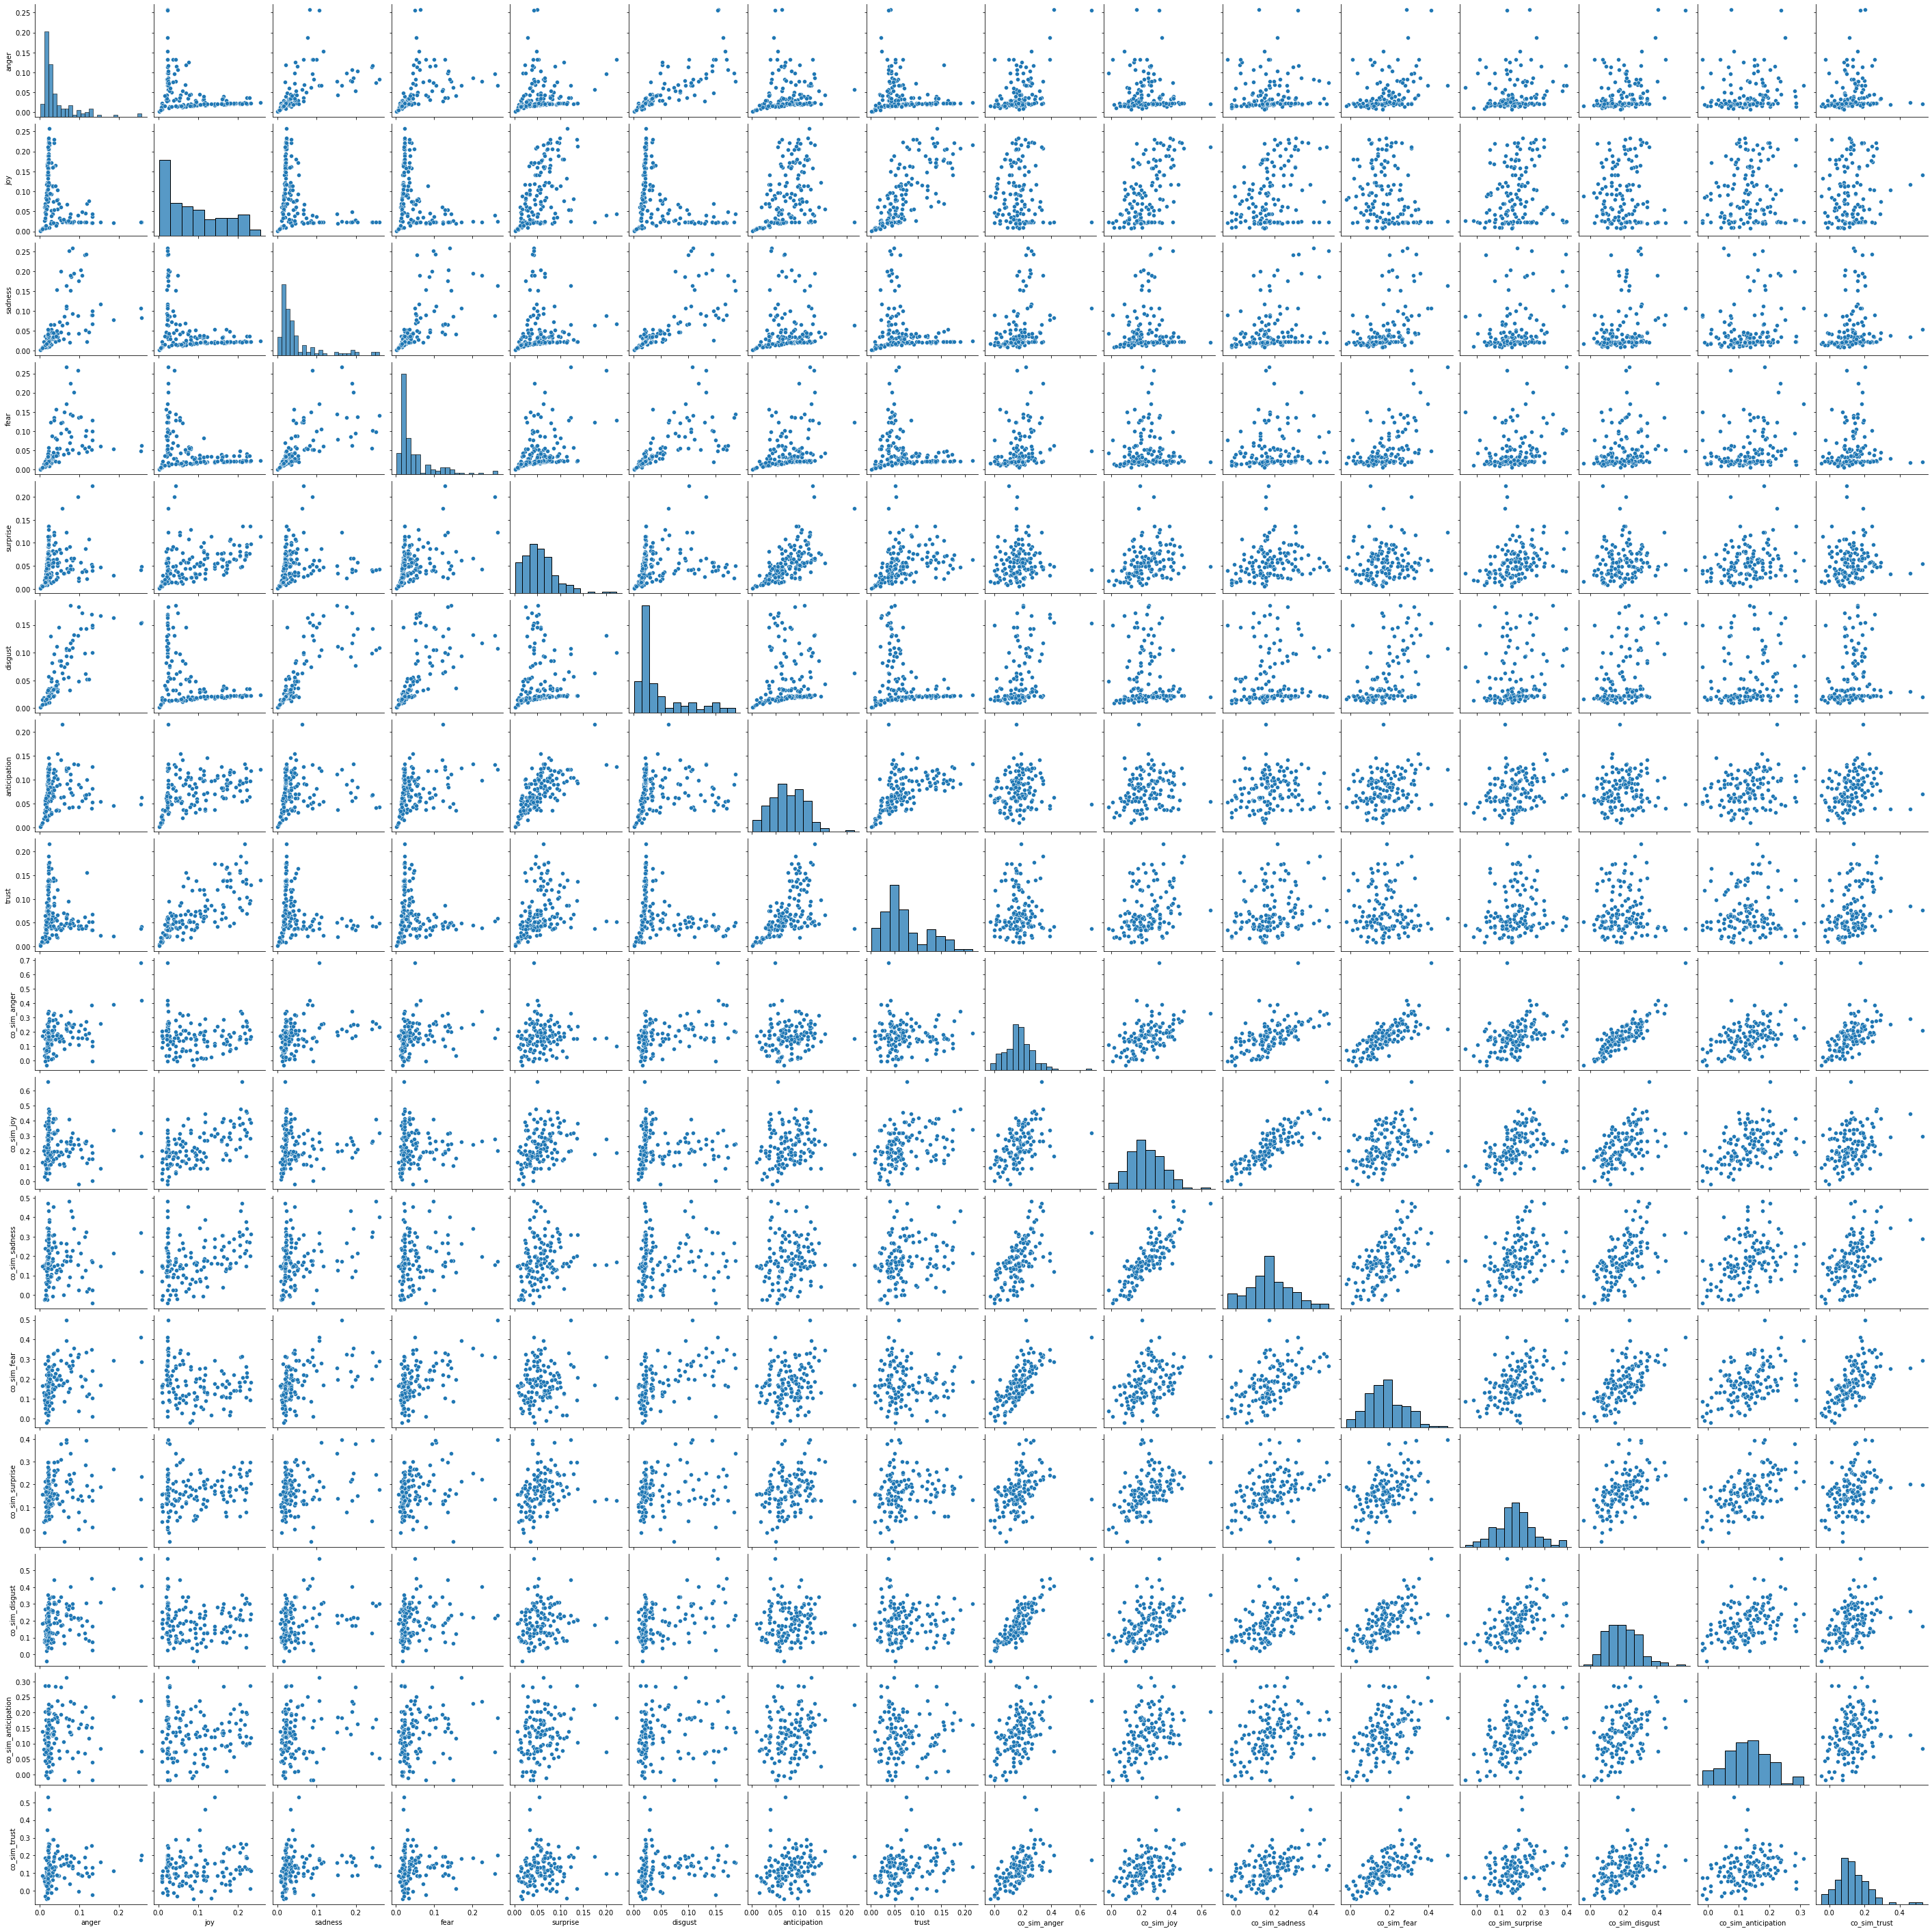

In [26]:
#Use pairplots to look for correlation between reported values by public and cosine similarities for the word vectors

#Define parameters to show on plot
cosin_eval = basic_emotions + cosine_sim_emotions

#Create plot
sns.pairplot(df_le01[cosin_eval])
#It is notable that the distribution of the basic emotion data has a skewed distribution

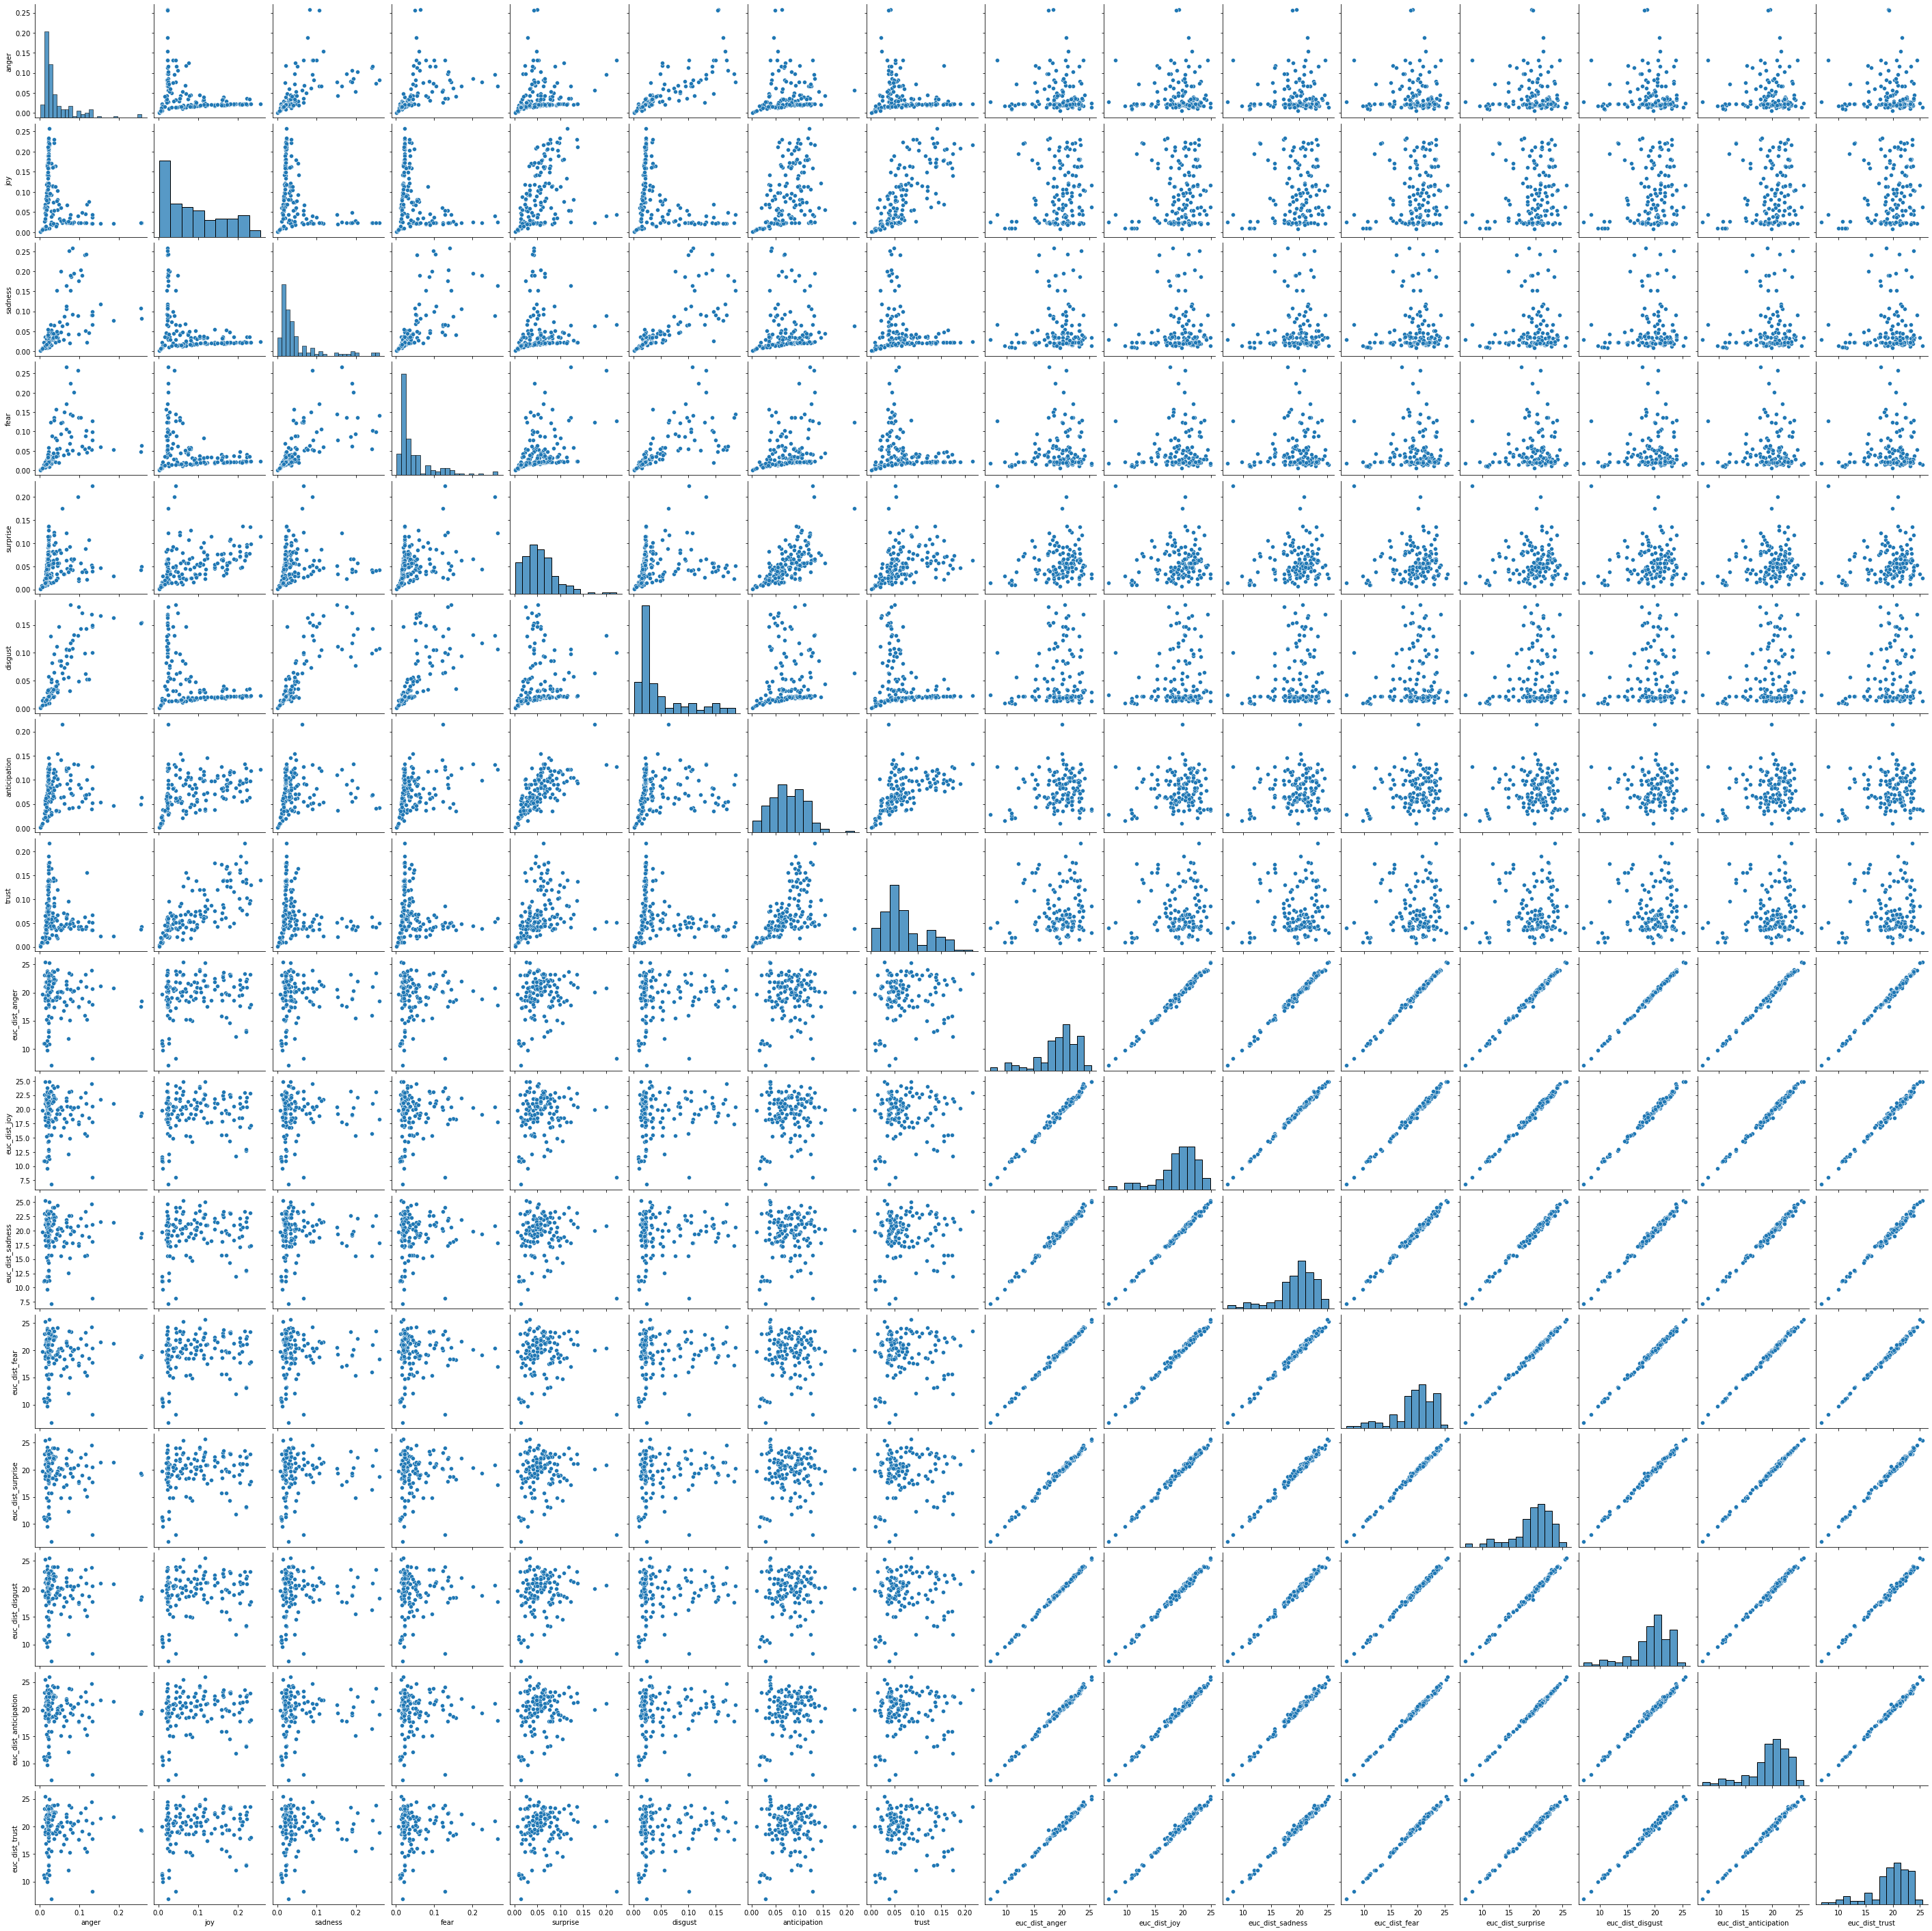

In [27]:
#Use pairplots to look for correlation (euclidian distances)

#Define parameters to show on plot
eucdist_eval = basic_emotions + euc_dist_emotions

#Create plot
sns.pairplot(df_le01[eucdist_eval])

The above pairplots in both cases show poor correlation between the similarity metrics and the reported basic emotion affinities. It is notable that in both cases the reported metrics have a more gaussian distribution than the reported metrics. Further work will be carried out to evaluate the potential usefullness of these metrics.

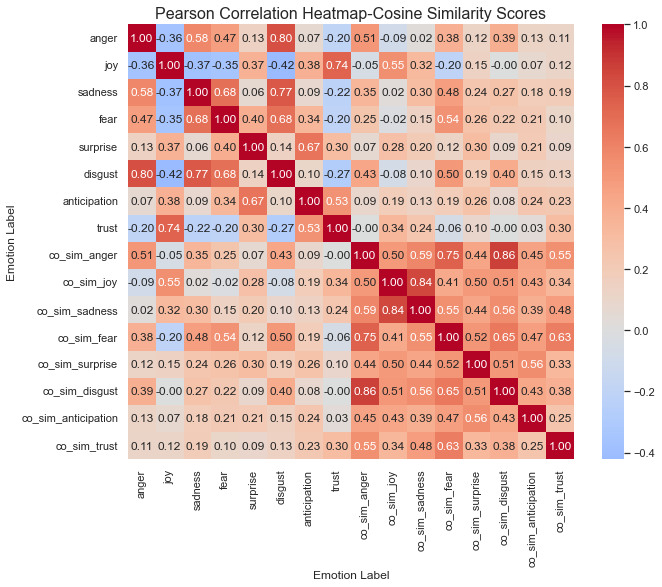

In [28]:
#Calculate Pearson correlation coefficients (cosine similarity scores)
correlation_matrix = df_le01[cosin_eval].corr(method='pearson')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Pearson Correlation Heatmap-Cosine Similarity Scores", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

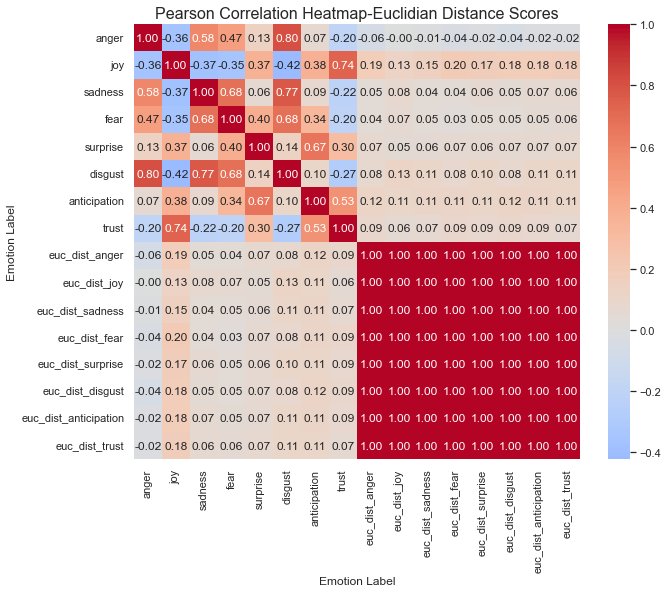

In [29]:
# Calculate Pearson correlation coefficients (euclidian distances)
correlation_matrix = df_le01[eucdist_eval].corr(method='pearson')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Pearson Correlation Heatmap-Euclidian Distance Scores", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

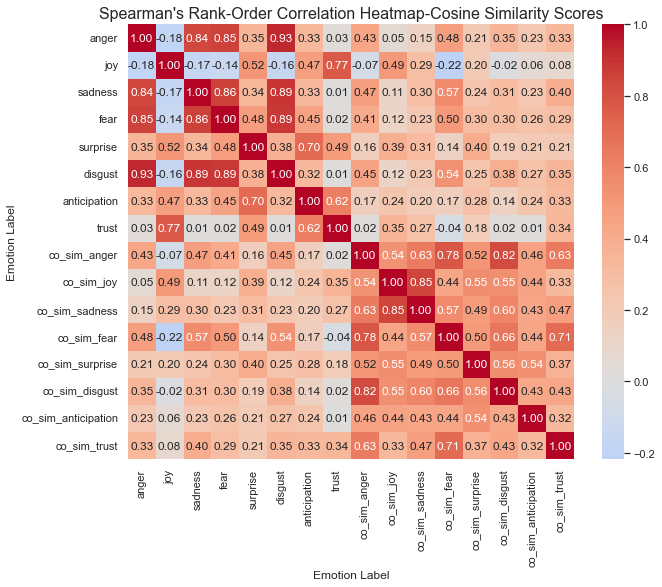

In [30]:
#Calculate Spearman correlation coefficients (cosine similarity scores)
correlation_matrix = df_le01[cosin_eval].corr(method='spearman')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Spearman's Rank-Order Correlation Heatmap-Cosine Similarity Scores", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

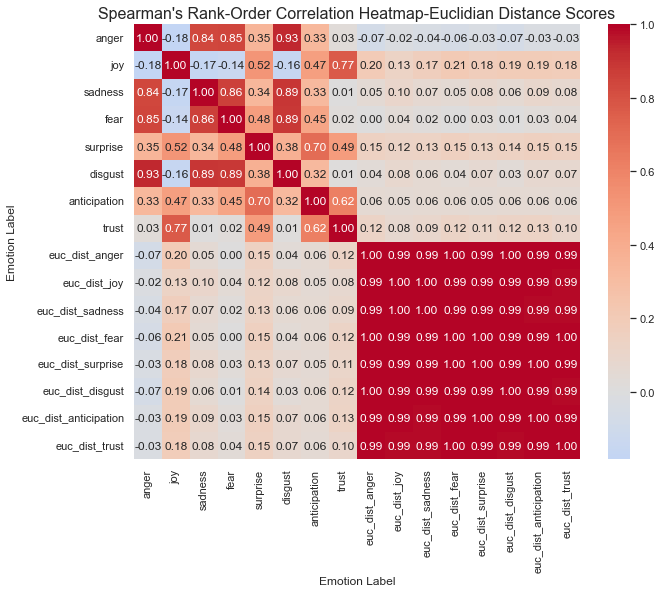

In [31]:
#Calculate Spearman correlation coefficients (euclidian distances)
correlation_matrix = df_le01[eucdist_eval].corr(method='spearman')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Spearman's Rank-Order Correlation Heatmap-Euclidian Distance Scores", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

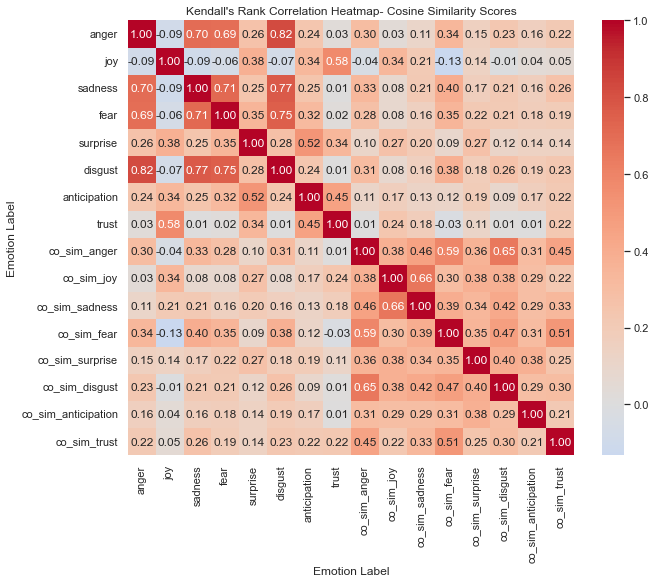

In [32]:
#Calculate Kendall's rank correlation coefficient (cosine similarity score)
correlation_matrix = df_le01[cosin_eval].corr(method='kendall')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Kendall's Rank Correlation Heatmap- Cosine Similarity Scores")
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

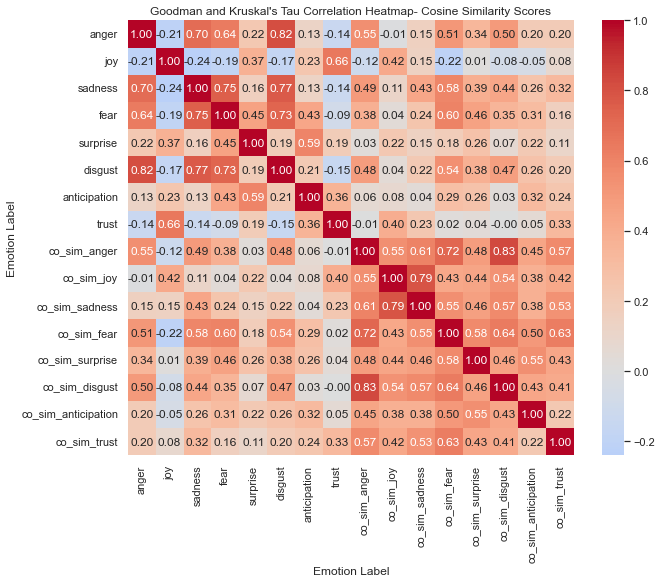

In [33]:
#Calculate Goodman and Kruskal's tau correlation coefficient (cosine similarity scores)
correlation_matrix = pd.DataFrame(index=cosin_eval, columns=cosin_eval, dtype=float)

for col1 in cosin_eval:
    for col2 in cosin_eval:
        tau, _ = weightedtau(df_le01[col1], df_le01[col2])
        correlation_matrix.loc[col1, col2] = tau

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Goodman and Kruskal's Tau Correlation Heatmap- Cosine Similarity Scores")
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

Heatmap based correlation plots highlighted some key findings. These values do significantly differ from the reported values in the dataset both in terms of scale and relative to each other. However, there is moderate correlation found in certain instances such as Spearmans rank heatmap to compare cosine similarity scores to reported values for each respective emotion. Additionally, it is clear that the correlation between 'negative' and 'positive' basic emotions with respect to one another is captured to some extent using the cosine similarity scores. The euclidian distance is not as effective in any case to capture trends in the reported data. This test shows that there may be some benefit to the addition of this data in later predictive models to improve outcomes.

In [158]:
#Remove columns containing eudlidian distance values from dataset
df_le01 = df_le01.drop(columns=['euc_dist_anger', 'euc_dist_joy', 'euc_dist_sadness',
                                'euc_dist_fear', 'euc_dist_surprise', 'euc_dist_disgust', 'euc_dist_anticipation',
                                'euc_dist_trust'])
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  sent_polar primary_basic_emot  \
0  0.032855  0.065710  0.088298  ...    Positive                joy   
1  0.015419  0.024671  0.053967  ...    Positive       anticipation   
2  0.051856  0.028610  0.037551  ...    Positive                joy   
3  0.019122  0.040157  0.061191  ...    Positive                joy   
4  0.019370  0.067795  0.079417  ...    Positive                joy   

   co_sim_anger  co_sim_joy  co_sim_sadness  co_sim_fear co_sim_surprise  \
0      0.212815    0.398045        0.307879     0.170043        0.168778   
1      0.031860    0.097309        0.137938     0.102546        0.056646   
2      0.112067    0.165191        0.168149     0.186228        0.173427   
3      0.115099    0.183506        0.124933     0.159108        0.077226   
4      0.100389    0.269118        0.175544     0.122721        0.223669   

  co_sim_disgust co_sim_anticipation co_sim_trust  
0       0.276684            0.141978     0.103585  
1       0.071432            0.176522     0.040214  
2       0.126981            0.219476     0.101377  
3       0.162806            0.089916     0.037725  
4       0.129766            0.143079     0.081530  

[5 rows x 29 columns]

As these values will be used during ML, they will be scaled according to the previous method implemented and justified for the basic theory emotion data.

In [159]:
#Scale all data for basic emotions

#Re-Create a column that contains the sum of all basic emotion values
df_le01['total_prescale'] = df_le01['co_sim_anger'] + df_le01['co_sim_anticipation'] + df_le01['co_sim_disgust'] + df_le01['co_sim_fear'] + df_le01['co_sim_joy'] + df_le01['co_sim_sadness'] + df_le01['co_sim_surprise'] + df_le01['co_sim_trust']

#Repeat previous line to make column to facilitate scaling
df_le01['total'] = df_le01['total_prescale']

#Scale total column
scale_cols = ['total']

#Define function for scaling
def scaling(df_le01):
    scaler = MinMaxScaler(feature_range=(0.01, 1))
    df_le01[scale_cols] = scaler.fit_transform(df_le01[scale_cols])
    return df_le01
df_le01 = scaling(df_le01)

#Determine scaling factor for the row
df_le01['scaling_factor'] = df_le01['total_prescale']/df_le01['total']

#Scale each basic emotion value using the scaling factor
df_le01['co_sim_anger'] = df_le01['co_sim_anger']/df_le01['scaling_factor']
df_le01['co_sim_anticipation'] = df_le01['co_sim_anticipation']/df_le01['scaling_factor']
df_le01['co_sim_disgust'] = df_le01['co_sim_disgust']/df_le01['scaling_factor']
df_le01['co_sim_fear'] = df_le01['co_sim_fear']/df_le01['scaling_factor']
df_le01['co_sim_joy'] = df_le01['co_sim_joy']/df_le01['scaling_factor']
df_le01['co_sim_sadness'] = df_le01['co_sim_sadness']/df_le01['scaling_factor']
df_le01['co_sim_surprise'] = df_le01['co_sim_surprise']/df_le01['scaling_factor']
df_le01['co_sim_trust'] = df_le01['co_sim_trust']/df_le01['scaling_factor']

df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  co_sim_joy co_sim_sadness  co_sim_fear  \
0  0.032855  0.065710  0.088298  ...    0.141277       0.109274     0.060353   
1  0.015419  0.024671  0.053967  ...    0.036187       0.051297     0.038135   
2  0.051856  0.028610  0.037551  ...    0.059421       0.060485     0.066988   
3  0.019122  0.040157  0.061191  ...    0.066952       0.045582     0.058051   
4  0.019370  0.067795  0.079417  ...    0.096829       0.063161     0.044155   

   co_sim_surprise  co_sim_disgust  co_sim_anticipation co_sim_trust  \
0         0.059904        0.098202             0.050392     0.036765   
1         0.021066        0.026564             0.065645     0.014955   
2         0.062383        0.045676             0.078947     0.036466   
3         0.028176        0.059400             0.032806     0.013764   
4         0.080476        0.046690             0.051480     0.029334   

  total_prescale     total scaling_factor  
0       1.779807  0.631700       2.817488  
1       0.714467  0.265697       2.689028  
2       1.252896  0.450677       2.780031  
3       0.950319  0.346725       2.740842  
4       1.245816  0.448245       2.779322  

[5 rows x 32 columns]

In [160]:
#Remove other extraneous columns
df_le01 = df_le01.drop(columns=['total', 'total_prescale', 'scaling_factor'])
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  sent_polar primary_basic_emot  \
0  0.032855  0.065710  0.088298  ...    Positive                joy   
1  0.015419  0.024671  0.053967  ...    Positive       anticipation   
2  0.051856  0.028610  0.037551  ...    Positive                joy   
3  0.019122  0.040157  0.061191  ...    Positive                joy   
4  0.019370  0.067795  0.079417  ...    Positive                joy   

   co_sim_anger  co_sim_joy  co_sim_sadness  co_sim_fear co_sim_surprise  \
0      0.075534    0.141277        0.109274     0.060353        0.059904   
1      0.011848    0.036187        0.051297     0.038135        0.021066   
2      0.040312    0.059421        0.060485     0.066988        0.062383   
3      0.041994    0.066952        0.045582     0.058051        0.028176   
4      0.036120    0.096829        0.063161     0.044155        0.080476   

  co_sim_disgust co_sim_anticipation co_sim_trust  
0       0.098202            0.050392     0.036765  
1       0.026564            0.065645     0.014955  
2       0.045676            0.078947     0.036466  
3       0.059400            0.032806     0.013764  
4       0.046690            0.051480     0.029334  

[5 rows x 29 columns]

# Binary Word Emotion Lexicons based on Emoji corpus similarity

In [201]:
#Load in EmoLex text file
emolex = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep='\t', header=None, names=['Word', 'Emotion', 'Value'])
emolex.head()

Word       Emotion  Value
0  aback         anger      0
1  aback  anticipation      0
2  aback       disgust      0
3  aback          fear      0
4  aback           joy      0

In [202]:
#Check for null values
emolex.isnull().sum()

Word       10
Emotion     0
Value       0
dtype: int64

In [203]:
#Drop columns with null values for words
emolex.dropna(inplace=True)
emolex.isnull().sum()

Word       0
Emotion    0
Value      0
dtype: int64

In [209]:
#Create lists of words with associations to each basic emotion from the emolex lexicon
emotions = ['anger', 'joy', 'sadness', 'fear', 'surprise', 'disgust', 'anticipation', 'trust']
emotion_words_dict = {}

for emotion in emotions:
    filtered_df = emolex[(emolex['Value'] == 1) & (emolex['Emotion'] == emotion)]
    emotion_words = filtered_df['Word'].tolist()
    emotion_words_dict[emotion] = emotion_words

In [210]:
#Store lists in new variables
anger_words = emotion_words_dict['anger']
joy_words = emotion_words_dict['joy']
sadness_words = emotion_words_dict['sadness']
fear_words = emotion_words_dict['fear']
surprise_words = emotion_words_dict['surprise']
disgust_words = emotion_words_dict['disgust']
anticipation_words = emotion_words_dict['anticipation']
trust_words = emotion_words_dict['trust']

In [212]:
#Check length of the lists
len(sadness_words)

1187

In [217]:
#Make file containing word vectors for words which are associated with anger

#Download the pre-trained Word2Vec model from Gensim data server (300d to match emoji vector)
word2vec_model = api.load('word2vec-google-news-300')

#Extract the word vectors for the angry words
anger_vectors = {word: word2vec_model[word] for word in anger_words if word in word2vec_model}

#Save to a new file for later use
output_file = 'anger_vectors.txt'

#Get the vector size from the first word vector in the dictionary
vector_size = len(anger_vectors[list(anger_vectors.keys())[0]])

with open(output_file, 'w', encoding='utf-8') as file:
    #Write the first line with vocabulary size and vector size
    file.write(f"{len(anger_vectors)} {vector_size}\n")

    #Write each emotion word and its corresponding vector to the file
    for word, vector in anger_vectors.items():
        vector_str = ' '.join(str(val) for val in vector)
        file.write(f'{word} {vector_str}\n')

In [218]:
#Same process for joy

#Extract the word vectors
joy_vectors = {word: word2vec_model[word] for word in joy_words if word in word2vec_model}

#Save to a new file for later use
output_file = 'joy_vectors.txt'

#Get the vector size from the first word vector in the dictionary
vector_size = len(joy_vectors[list(joy_vectors.keys())[0]])

with open(output_file, 'w', encoding='utf-8') as file:
    #Write the first line with vocabulary size and vector size
    file.write(f"{len(joy_vectors)} {vector_size}\n")

    #Write each emotion word and its corresponding vector to the file
    for word, vector in joy_vectors.items():
        vector_str = ' '.join(str(val) for val in vector)
        file.write(f'{word} {vector_str}\n')

In [219]:
#Same process for sadness

#Extract the word vectors
sadness_vectors = {word: word2vec_model[word] for word in sadness_words if word in word2vec_model}

#Save to a new file for later use
output_file = 'sadness_vectors.txt'

#Get the vector size from the first word vector in the dictionary
vector_size = len(sadness_vectors[list(sadness_vectors.keys())[0]])

with open(output_file, 'w', encoding='utf-8') as file:
    #Write the first line with vocabulary size and vector size
    file.write(f"{len(sadness_vectors)} {vector_size}\n")

    #Write each emotion word and its corresponding vector to the file
    for word, vector in sadness_vectors.items():
        vector_str = ' '.join(str(val) for val in vector)
        file.write(f'{word} {vector_str}\n')

In [220]:
#Same process for fear

#Extract the word vectors
fear_vectors = {word: word2vec_model[word] for word in fear_words if word in word2vec_model}

#Save to a new file for later use
output_file = 'fear_vectors.txt'

#Get the vector size from the first word vector in the dictionary
vector_size = len(fear_vectors[list(fear_vectors.keys())[0]])

with open(output_file, 'w', encoding='utf-8') as file:
    #Write the first line with vocabulary size and vector size
    file.write(f"{len(fear_vectors)} {vector_size}\n")

    #Write each emotion word and its corresponding vector to the file
    for word, vector in fear_vectors.items():
        vector_str = ' '.join(str(val) for val in vector)
        file.write(f'{word} {vector_str}\n')

In [221]:
#Same process for surprise

#Extract the word vectors
surprise_vectors = {word: word2vec_model[word] for word in surprise_words if word in word2vec_model}

#Save to a new file for later use
output_file = 'surprise_vectors.txt'

#Get the vector size from the first word vector in the dictionary
vector_size = len(surprise_vectors[list(surprise_vectors.keys())[0]])

with open(output_file, 'w', encoding='utf-8') as file:
    #Write the first line with vocabulary size and vector size
    file.write(f"{len(surprise_vectors)} {vector_size}\n")

    #Write each emotion word and its corresponding vector to the file
    for word, vector in surprise_vectors.items():
        vector_str = ' '.join(str(val) for val in vector)
        file.write(f'{word} {vector_str}\n')

In [222]:
#Same process for disgust

#Extract the word vectors
disgust_vectors = {word: word2vec_model[word] for word in disgust_words if word in word2vec_model}

#Save to a new file for later use
output_file = 'disgust_vectors.txt'

#Get the vector size from the first word vector in the dictionary
vector_size = len(disgust_vectors[list(disgust_vectors.keys())[0]])

with open(output_file, 'w', encoding='utf-8') as file:
    #Write the first line with vocabulary size and vector size
    file.write(f"{len(disgust_vectors)} {vector_size}\n")

    #Write each emotion word and its corresponding vector to the file
    for word, vector in disgust_vectors.items():
        vector_str = ' '.join(str(val) for val in vector)
        file.write(f'{word} {vector_str}\n')

In [223]:
#Same process for anticipation

#Extract the word vectors
anticipation_vectors = {word: word2vec_model[word] for word in anticipation_words if word in word2vec_model}

#Save to a new file for later use
output_file = 'anticipation_vectors.txt'

#Get the vector size from the first word vector in the dictionary
vector_size = len(anticipation_vectors[list(anticipation_vectors.keys())[0]])

with open(output_file, 'w', encoding='utf-8') as file:
    #Write the first line with vocabulary size and vector size
    file.write(f"{len(anticipation_vectors)} {vector_size}\n")

    #Write each emotion word and its corresponding vector to the file
    for word, vector in anticipation_vectors.items():
        vector_str = ' '.join(str(val) for val in vector)
        file.write(f'{word} {vector_str}\n')

In [224]:
#Same process for trust

#Extract the word vectors
trust_vectors = {word: word2vec_model[word] for word in trust_words if word in word2vec_model}

#Save to a new file for later use
output_file = 'trust_vectors.txt'

#Get the vector size from the first word vector in the dictionary
vector_size = len(trust_vectors[list(trust_vectors.keys())[0]])

with open(output_file, 'w', encoding='utf-8') as file:
    #Write the first line with vocabulary size and vector size
    file.write(f"{len(trust_vectors)} {vector_size}\n")

    #Write each emotion word and its corresponding vector to the file
    for word, vector in trust_vectors.items():
        vector_str = ' '.join(str(val) for val in vector)
        file.write(f'{word} {vector_str}\n')

In [ ]:
#Find from the words associated with each basic emotion the 5 which have most in common with the relevant basic emotion
#Start with anger

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each emotion and calculate similarity scores for each emoji
for emotion in emotions:
    #Create a new column for the similarity score of each emoji with respect to the current emotion
    df_le01[f'co_sim_{emotion}'] = df_le01['emoji'].apply(lambda x: cosine_similarity(emoji2vec[x], basic2vec[emotion]) if x in emoji2vec else None)

#Display altered dataset
df_le01.head()

In [225]:
#Load basic emotion vector file
basic2vec = KeyedVectors.load_word2vec_format('basic_emot_vectors.txt', binary=False)
anger_vector = KeyedVectors.load_word2vec_format('anger_vectors.txt', binary=False)

In [250]:
#Use cosine similarity to compare

#Load associated words vector file
anger_vector = KeyedVectors.load_word2vec_format('anger_vectors.txt', binary=False)

#Create a list to store the similarity scores for each word
similarity_scores = []

#Define emotion vector for anger
basic_emotion_vector = basic2vec['anger']

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each words in anger_list and calculate similarity scores for each to the anger vector
for word in anger_words:
    if word in anger_vectors:
        word_vector = np.array(anger_vectors[word])
        similarity_score = cosine_similarity(basic_emotion_vector, word_vector)
        similarity_scores.append((word, similarity_score))

#Sort the similarity scores in descending order
similarity_scores.sort(key=lambda x: x[1], reverse=True)

#Get the top 10 most similar words
anger_top_10_similar_words = similarity_scores[:10]

print(anger_top_10_similar_words)

[('anger', 1.0), ('resentment', 0.7837026), ('fury', 0.73593664), ('frustration', 0.7355941), ('outrage', 0.7234513), ('discontent', 0.6970604), ('disgust', 0.68643975), ('indignation', 0.6858266), ('hostility', 0.6230683), ('bitterness', 0.62235594)]


In [251]:
#Repeat for other emotions- joy

#Load associated words vector file
joy_vector = KeyedVectors.load_word2vec_format('joy_vectors.txt', binary=False)

#Create a list to store the similarity scores for each word
similarity_scores = []

#Define emotion vector for anger
basic_emotion_vector = basic2vec['joy']

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each words in anger_list and calculate similarity scores for each to the anger vector
for word in joy_words:
    if word in joy_vectors:
        word_vector = np.array(joy_vectors[word])
        similarity_score = cosine_similarity(basic_emotion_vector, word_vector)
        similarity_scores.append((word, similarity_score))

#Sort the similarity scores in descending order
similarity_scores.sort(key=lambda x: x[1], reverse=True)

#Get the top 10 most similar words
joy_top_10_similar_words = similarity_scores[:10]

print(joy_top_10_similar_words)

[('joy', 1.0), ('exhilaration', 0.6803831), ('joyful', 0.6633968), ('delight', 0.6550244), ('excitement', 0.65311956), ('thrill', 0.6302037), ('happiness', 0.6182847), ('joyous', 0.61288977), ('gladness', 0.5704875), ('rejoicing', 0.5401259)]


In [252]:
#Repeat for other emotions- sadness

#Load associated words vector file
sadness_vector = KeyedVectors.load_word2vec_format('sadness_vectors.txt', binary=False)

#Create a list to store the similarity scores for each word
similarity_scores = []

#Define emotion vector for anger
basic_emotion_vector = basic2vec['sadness']

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each words in anger_list and calculate similarity scores for each to the anger vector
for word in sadness_words:
    if word in sadness_vectors:
        word_vector = np.array(sadness_vectors[word])
        similarity_score = cosine_similarity(basic_emotion_vector, word_vector)
        similarity_scores.append((word, similarity_score))

#Sort the similarity scores in descending order
similarity_scores.sort(key=lambda x: x[1], reverse=True)

#Get the top 10 most similar words
sadness_top_10_similar_words = similarity_scores[:10]

print(sadness_top_10_similar_words)

[('sadness', 1.0), ('sorrow', 0.8653063), ('grief', 0.71041125), ('anguish', 0.68618506), ('despair', 0.62180483), ('regret', 0.6071218), ('heartache', 0.5936863), ('emptiness', 0.5894925), ('melancholy', 0.57072014), ('disappointment', 0.5678073)]


In [253]:
#Repeat for other emotions- fear

#Load associated words vector file
fear_vector = KeyedVectors.load_word2vec_format('fear_vectors.txt', binary=False)

#Create a list to store the similarity scores for each word
similarity_scores = []

#Define emotion vector for anger
basic_emotion_vector = basic2vec['fear']

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each words in anger_list and calculate similarity scores for each to the anger vector
for word in fear_words:
    if word in fear_vectors:
        word_vector = np.array(fear_vectors[word])
        similarity_score = cosine_similarity(basic_emotion_vector, word_vector)
        similarity_scores.append((word, similarity_score))

#Sort the similarity scores in descending order
similarity_scores.sort(key=lambda x: x[1], reverse=True)

#Get the top 10 most similar words
fear_top_10_similar_words = similarity_scores[:10]

print(fear_top_10_similar_words)

[('fear', 1.0), ('fearful', 0.6968434), ('fearing', 0.64122945), ('worry', 0.63765574), ('dread', 0.59567887), ('anxiety', 0.5787465), ('apprehension', 0.5608136), ('afraid', 0.5580464), ('distrust', 0.5293097), ('panic', 0.50200045)]


In [254]:
#Repeat for other emotions- surprise

#Load associated words vector file
surprise_vector = KeyedVectors.load_word2vec_format('surprise_vectors.txt', binary=False)

#Create a list to store the similarity scores for each word
similarity_scores = []

#Define emotion vector for anger
basic_emotion_vector = basic2vec['surprise']

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each words in anger_list and calculate similarity scores for each to the anger vector
for word in surprise_words:
    if word in surprise_vectors:
        word_vector = np.array(surprise_vectors[word])
        similarity_score = cosine_similarity(basic_emotion_vector, word_vector)
        similarity_scores.append((word, similarity_score))

#Sort the similarity scores in descending order
similarity_scores.sort(key=lambda x: x[1], reverse=True)

#Get the top 10 most similar words
surprise_top_10_similar_words = similarity_scores[:10]

print(surprise_top_10_similar_words)

[('surprise', 1.0000001), ('surprising', 0.67450327), ('surprised', 0.5948417), ('shock', 0.57114404), ('coincidence', 0.48453823), ('unexpected', 0.4822316), ('stunned', 0.46737581), ('startling', 0.46515697), ('astonishment', 0.4356867), ('dismay', 0.43485197)]


In [255]:
#Repeat for other emotions- disgust

#Load associated words vector file
disgust_vector = KeyedVectors.load_word2vec_format('disgust_vectors.txt', binary=False)

#Create a list to store the similarity scores for each word
similarity_scores = []

#Define emotion vector for anger
basic_emotion_vector = basic2vec['disgust']

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each words in anger_list and calculate similarity scores for each to the anger vector
for word in disgust_words:
    if word in disgust_vectors:
        word_vector = np.array(disgust_vectors[word])
        similarity_score = cosine_similarity(basic_emotion_vector, word_vector)
        similarity_scores.append((word, similarity_score))

#Sort the similarity scores in descending order
similarity_scores.sort(key=lambda x: x[1], reverse=True)

#Get the top 10 most similar words
disgust_top_10_similar_words = similarity_scores[:10]

print(disgust_top_10_similar_words)

[('disgust', 1.0), ('exasperation', 0.7116754), ('indignation', 0.6913946), ('revulsion', 0.6746655), ('disdain', 0.66426224), ('displeasure', 0.656296), ('outrage', 0.6415345), ('distaste', 0.63596714), ('loathing', 0.57212555), ('disappointment', 0.5517358)]


In [256]:
#Repeat for other emotions- anticipation

#Load associated words vector file
anticipation_vector = KeyedVectors.load_word2vec_format('anticipation_vectors.txt', binary=False)

#Create a list to store the similarity scores for each word
similarity_scores = []

#Define emotion vector for anger
basic_emotion_vector = basic2vec['anticipation']

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each words in anger_list and calculate similarity scores for each to the anger vector
for word in anticipation_words:
    if word in anticipation_vectors:
        word_vector = np.array(anticipation_vectors[word])
        similarity_score = cosine_similarity(basic_emotion_vector, word_vector)
        similarity_scores.append((word, similarity_score))

#Sort the similarity scores in descending order
similarity_scores.sort(key=lambda x: x[1], reverse=True)

#Get the top 10 most similar words
anticipation_top_10_similar_words = similarity_scores[:10]

print(anticipation_top_10_similar_words)

[('anticipation', 0.99999994), ('excitement', 0.5241587), ('trepidation', 0.49867266), ('dread', 0.47193268), ('impending', 0.44458482), ('anticipatory', 0.43747464), ('expectation', 0.43095425), ('preparation', 0.42456126), ('buzz', 0.41694263), ('anxiety', 0.4101426)]


In [257]:
#Repeat for other emotions- trust

#Load associated words vector file
trust_vector = KeyedVectors.load_word2vec_format('trust_vectors.txt', binary=False)

#Create a list to store the similarity scores for each word
similarity_scores = []

#Define emotion vector for anger
basic_emotion_vector = basic2vec['trust']

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each words in anger_list and calculate similarity scores for each to the anger vector
for word in trust_words:
    if word in trust_vectors:
        word_vector = np.array(trust_vectors[word])
        similarity_score = cosine_similarity(basic_emotion_vector, word_vector)
        similarity_scores.append((word, similarity_score))

#Sort the similarity scores in descending order
similarity_scores.sort(key=lambda x: x[1], reverse=True)

#Get the top 10 most similar words
trust_top_10_similar_words = similarity_scores[:10]

print(trust_top_10_similar_words)

[('trust', 0.99999994), ('confidence', 0.47865507), ('faith', 0.45518783), ('respect', 0.423383), ('loyalty', 0.4114694), ('credibility', 0.39926317), ('integrity', 0.39899102), ('honesty', 0.3911982), ('entrust', 0.3894532), ('esteem', 0.37671083)]


In [259]:
#Calculate the similarity score between the top 5 words and each emoji within the lexicon

#Make lists of the top 5 words for each from previous results- exclude the word itself (first in each list)
top_5_anger = [word_score[0] for word_score in anger_top_10_similar_words[1:6]]
top_5_joy = [word_score[0] for word_score in joy_top_10_similar_words[1:6]]
top_5_sadness = [word_score[0] for word_score in sadness_top_10_similar_words[1:6]]
top_5_fear = [word_score[0] for word_score in fear_top_10_similar_words[1:6]]
top_5_surprise = [word_score[0] for word_score in surprise_top_10_similar_words[1:6]]
top_5_disgust = [word_score[0] for word_score in disgust_top_10_similar_words[1:6]]
top_5_anticipation = [word_score[0] for word_score in anticipation_top_10_similar_words[1:6]]
top_5_trust = [word_score[0] for word_score in trust_top_10_similar_words[1:6]]

In [287]:
#Create a column to store the list of similarity scores for each word
df_le01['top5_cosim_anger'] = None

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each emoji and calculate similarity scores for each word
for index, row in df_le01.iterrows():
    similarity_scores = []
    for word in top_5_anger:
        if row['emoji'] in emoji2vec:
            similarity_scores.append(cosine_similarity(emoji2vec[row['emoji']], anger_vector[word]))
        else:
            similarity_scores.append(None)
    #Create a new column in the df which contains the top 5 cosine similarity scores lists
    df_le01.at[index, 'top5_cosim_anger'] = similarity_scores
    
#Calculate the mean cosine similarity score for each
df_le01['top5_cosim_anger'] = df_le01['top5_cosim_anger'].apply(lambda row: np.mean([score for score in row if score is not None])) 

#Display the df
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  sent_polar_Positive  \
0  0.032855  0.065710  0.088298  ...                    1   
1  0.015419  0.024671  0.053967  ...                    1   
2  0.051856  0.028610  0.037551  ...                    1   
3  0.019122  0.040157  0.061191  ...                    1   
4  0.019370  0.067795  0.079417  ...                    1   

   primary_basic_emot_anger  primary_basic_emot_anticipation  \
0                         0                                0   
1                         0                                1   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   primary_basic_emot_disgust  primary_basic_emot_fear  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   primary_basic_emot_joy  primary_basic_emot_sadness  \
0                       1                           0   
1                       0                           0   
2                       1                           0   
3                       1                           0   
4                       1                           0   

   primary_basic_emot_surprise  primary_basic_emot_trust  top5_cosim_anger  
0                            0                         0          0.206920  
1                            0                         0          0.020288  
2                            0                         0          0.078066  
3                            0                         0          0.100505  
4                            0                         0          0.113608  

[5 rows x 57 columns]

In [288]:
#Repeat for anticipation

#Create a column to store the list of similarity scores for each word
df_le01['top5_cosim_anticipation'] = None

#Loop through each emoji and calculate similarity scores for each word
for index, row in df_le01.iterrows():
    similarity_scores = []
    for word in top_5_anticipation:
        if row['emoji'] in emoji2vec:
            similarity_scores.append(cosine_similarity(emoji2vec[row['emoji']], anticipation_vector[word]))
        else:
            similarity_scores.append(None)
    #Create a new column in the df which contains the top 5 cosine similarity scores lists
    df_le01.at[index, 'top5_cosim_anticipation'] = similarity_scores
    
#Calculate the mean cosine similarity score for each
df_le01['top5_cosim_anticipation'] = df_le01['top5_cosim_anticipation'].apply(lambda row: np.mean([score for score in row if score is not None]))

In [289]:
#Repeat for disgust

#Create a column to store the list of similarity scores for each word
df_le01['top5_cosim_disgust'] = None

#Loop through each emoji and calculate similarity scores for each word
for index, row in df_le01.iterrows():
    similarity_scores = []
    for word in top_5_disgust:
        if row['emoji'] in emoji2vec:
            similarity_scores.append(cosine_similarity(emoji2vec[row['emoji']], disgust_vector[word]))
        else:
            similarity_scores.append(None)
    #Create a new column in the df which contains the top 5 cosine similarity scores lists
    df_le01.at[index, 'top5_cosim_disgust'] = similarity_scores
    
#Calculate the mean cosine similarity score for each
df_le01['top5_cosim_disgust'] = df_le01['top5_cosim_disgust'].apply(lambda row: np.mean([score for score in row if score is not None]))

In [290]:
#Repeat for fear

#Create a column to store the list of similarity scores for each word
df_le01['top5_cosim_fear'] = None

#Loop through each emoji and calculate similarity scores for each word
for index, row in df_le01.iterrows():
    similarity_scores = []
    for word in top_5_fear:
        if row['emoji'] in emoji2vec:
            similarity_scores.append(cosine_similarity(emoji2vec[row['emoji']], fear_vector[word]))
        else:
            similarity_scores.append(None)
    #Create a new column in the df which contains the top 5 cosine similarity scores lists
    df_le01.at[index, 'top5_cosim_fear'] = similarity_scores
    
#Calculate the mean cosine similarity score for each
df_le01['top5_cosim_fear'] = df_le01['top5_cosim_fear'].apply(lambda row: np.mean([score for score in row if score is not None]))

In [291]:
#Repeat for joy

#Create a column to store the list of similarity scores for each word
df_le01['top5_cosim_joy'] = None

#Loop through each emoji and calculate similarity scores for each word
for index, row in df_le01.iterrows():
    similarity_scores = []
    for word in top_5_joy:
        if row['emoji'] in emoji2vec:
            similarity_scores.append(cosine_similarity(emoji2vec[row['emoji']], joy_vector[word]))
        else:
            similarity_scores.append(None)
    #Create a new column in the df which contains the top 5 cosine similarity scores lists
    df_le01.at[index, 'top5_cosim_joy'] = similarity_scores
    
#Calculate the mean cosine similarity score for each
df_le01['top5_cosim_joy'] = df_le01['top5_cosim_joy'].apply(lambda row: np.mean([score for score in row if score is not None]))

In [292]:
#Repeat for sadness

#Create a column to store the list of similarity scores for each word
df_le01['top5_cosim_sadness'] = None

#Loop through each emoji and calculate similarity scores for each word
for index, row in df_le01.iterrows():
    similarity_scores = []
    for word in top_5_sadness:
        if row['emoji'] in emoji2vec:
            similarity_scores.append(cosine_similarity(emoji2vec[row['emoji']], sadness_vector[word]))
        else:
            similarity_scores.append(None)
    #Create a new column in the df which contains the top 5 cosine similarity scores lists
    df_le01.at[index, 'top5_cosim_sadness'] = similarity_scores
    
#Calculate the mean cosine similarity score for each
df_le01['top5_cosim_sadness'] = df_le01['top5_cosim_sadness'].apply(lambda row: np.mean([score for score in row if score is not None]))

In [293]:
#Repeat for surprise

#Create a column to store the list of similarity scores for each word
df_le01['top5_cosim_surprise'] = None

#Loop through each emoji and calculate similarity scores for each word
for index, row in df_le01.iterrows():
    similarity_scores = []
    for word in top_5_surprise:
        if row['emoji'] in emoji2vec:
            similarity_scores.append(cosine_similarity(emoji2vec[row['emoji']], surprise_vector[word]))
        else:
            similarity_scores.append(None)
    #Create a new column in the df which contains the top 5 cosine similarity scores lists
    df_le01.at[index, 'top5_cosim_surprise'] = similarity_scores
    
#Calculate the mean cosine similarity score for each
df_le01['top5_cosim_surprise'] = df_le01['top5_cosim_surprise'].apply(lambda row: np.mean([score for score in row if score is not None]))

In [294]:
#Repeat for trust

#Create a column to store the list of similarity scores for each word
df_le01['top5_cosim_trust'] = None

#Loop through each emoji and calculate similarity scores for each word
for index, row in df_le01.iterrows():
    similarity_scores = []
    for word in top_5_trust:
        if row['emoji'] in emoji2vec:
            similarity_scores.append(cosine_similarity(emoji2vec[row['emoji']], trust_vector[word]))
        else:
            similarity_scores.append(None)
    #Create a new column in the df which contains the top 5 cosine similarity scores lists
    df_le01.at[index, 'top5_cosim_trust'] = similarity_scores
    
#Calculate the mean cosine similarity score for each
df_le01['top5_cosim_trust'] = df_le01['top5_cosim_trust'].apply(lambda row: np.mean([score for score in row if score is not None]))

In [295]:
#Confirm transformation looks ok for new columns
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  primary_basic_emot_surprise  \
0  0.032855  0.065710  0.088298  ...                            0   
1  0.015419  0.024671  0.053967  ...                            0   
2  0.051856  0.028610  0.037551  ...                            0   
3  0.019122  0.040157  0.061191  ...                            0   
4  0.019370  0.067795  0.079417  ...                            0   

   primary_basic_emot_trust  top5_cosim_anger  top5_cosim_anticipation  \
0                         0          0.206920                 0.179018   
1                         0          0.020288                 0.157387   
2                         0          0.078066                 0.217421   
3                         0          0.100505                 0.166704   
4                         0          0.113608                 0.169053   

   top5_cosim_disgust  top5_cosim_fear  top5_cosim_joy  top5_cosim_sadness  \
0            0.238860         0.165242        0.300116            0.256210   
1            0.057869         0.137267        0.132555            0.113825   
2            0.110598         0.189244        0.199278            0.132979   
3            0.148015         0.156528        0.188393            0.128153   
4            0.108651         0.144306        0.255602            0.138513   

   top5_cosim_surprise  top5_cosim_trust  
0             0.166351          0.220641  
1             0.110658          0.024497  
2             0.180321          0.078135  
3             0.125390          0.033600  
4             0.184258          0.135268  

[5 rows x 64 columns]

# Addressing skew in target variables

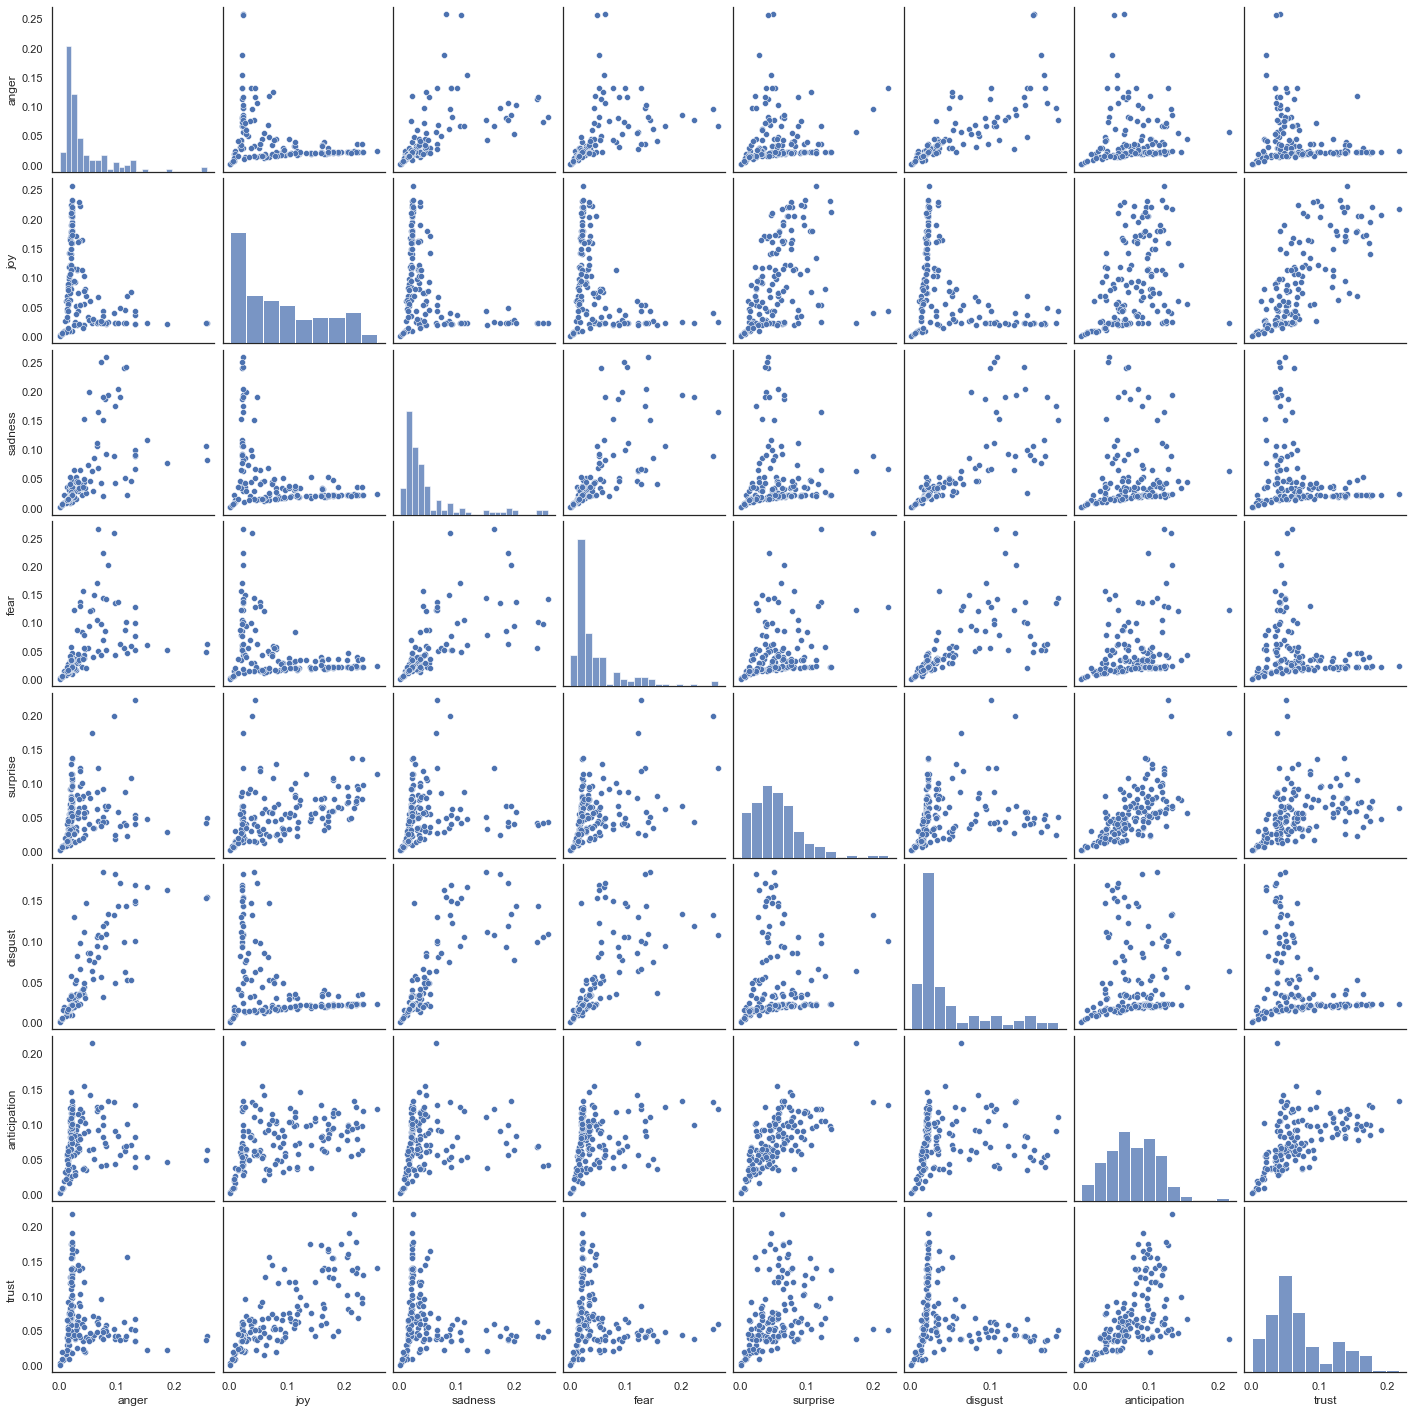

In [163]:
#Create plot to look at distribution of target variables as done previously- some are very skewed
sns.pairplot(df_le01[basic_emotions])

In [192]:
#Check which method to migitate skew works best for each basic emotion
#Goal is to find values as close to zero as possible

emotion = ['anger', 'joy', 'sadness', 'fear', 'surprise', 'disgust', 'anticipation', 'trust']

for emotion in emotion:
    print(emotion.capitalize())
    print('Skew before transformation:', (df_le01[emotion]).skew())
    print('Log transformation:', (np.log(df_le01[emotion]).skew()))
    print('Square root transformation:', (np.sqrt(df_le01[emotion]).skew()))
    print('Cube root transformation:', (np.cbrt(df_le01[emotion]).skew()))
    print('Reciprocals transformation:', (np.reciprocal(df_le01[emotion]).skew()))

Anger
Skew before transformation: 2.5596350676641593
Log transformation: -0.04627838864648397
Square root transformation: 1.4431094025302535
Cube root transformation: 1.0565550529868313
Reciprocals transformation: 8.19159296076709
Joy
Skew before transformation: 0.6147020447523687
Log transformation: -0.7723101734685637
Square root transformation: 0.1391089840129037
Cube root transformation: -0.0818095387354606
Reciprocals transformation: 6.875072324182884
Sadness
Skew before transformation: 2.252917493542576
Log transformation: 0.12545271180200682
Square root transformation: 1.5075752435004237
Cube root transformation: 1.1680569689104912
Reciprocals transformation: 8.086136123586515
Fear
Skew before transformation: 2.254553510304369
Log transformation: -0.053507875067783935
Square root transformation: 1.3221395568199217
Cube root transformation: 0.9669932245726055
Reciprocals transformation: 8.030556311700902
Surprise
Skew before transformation: 1.4644117022942018
Log transformation: 

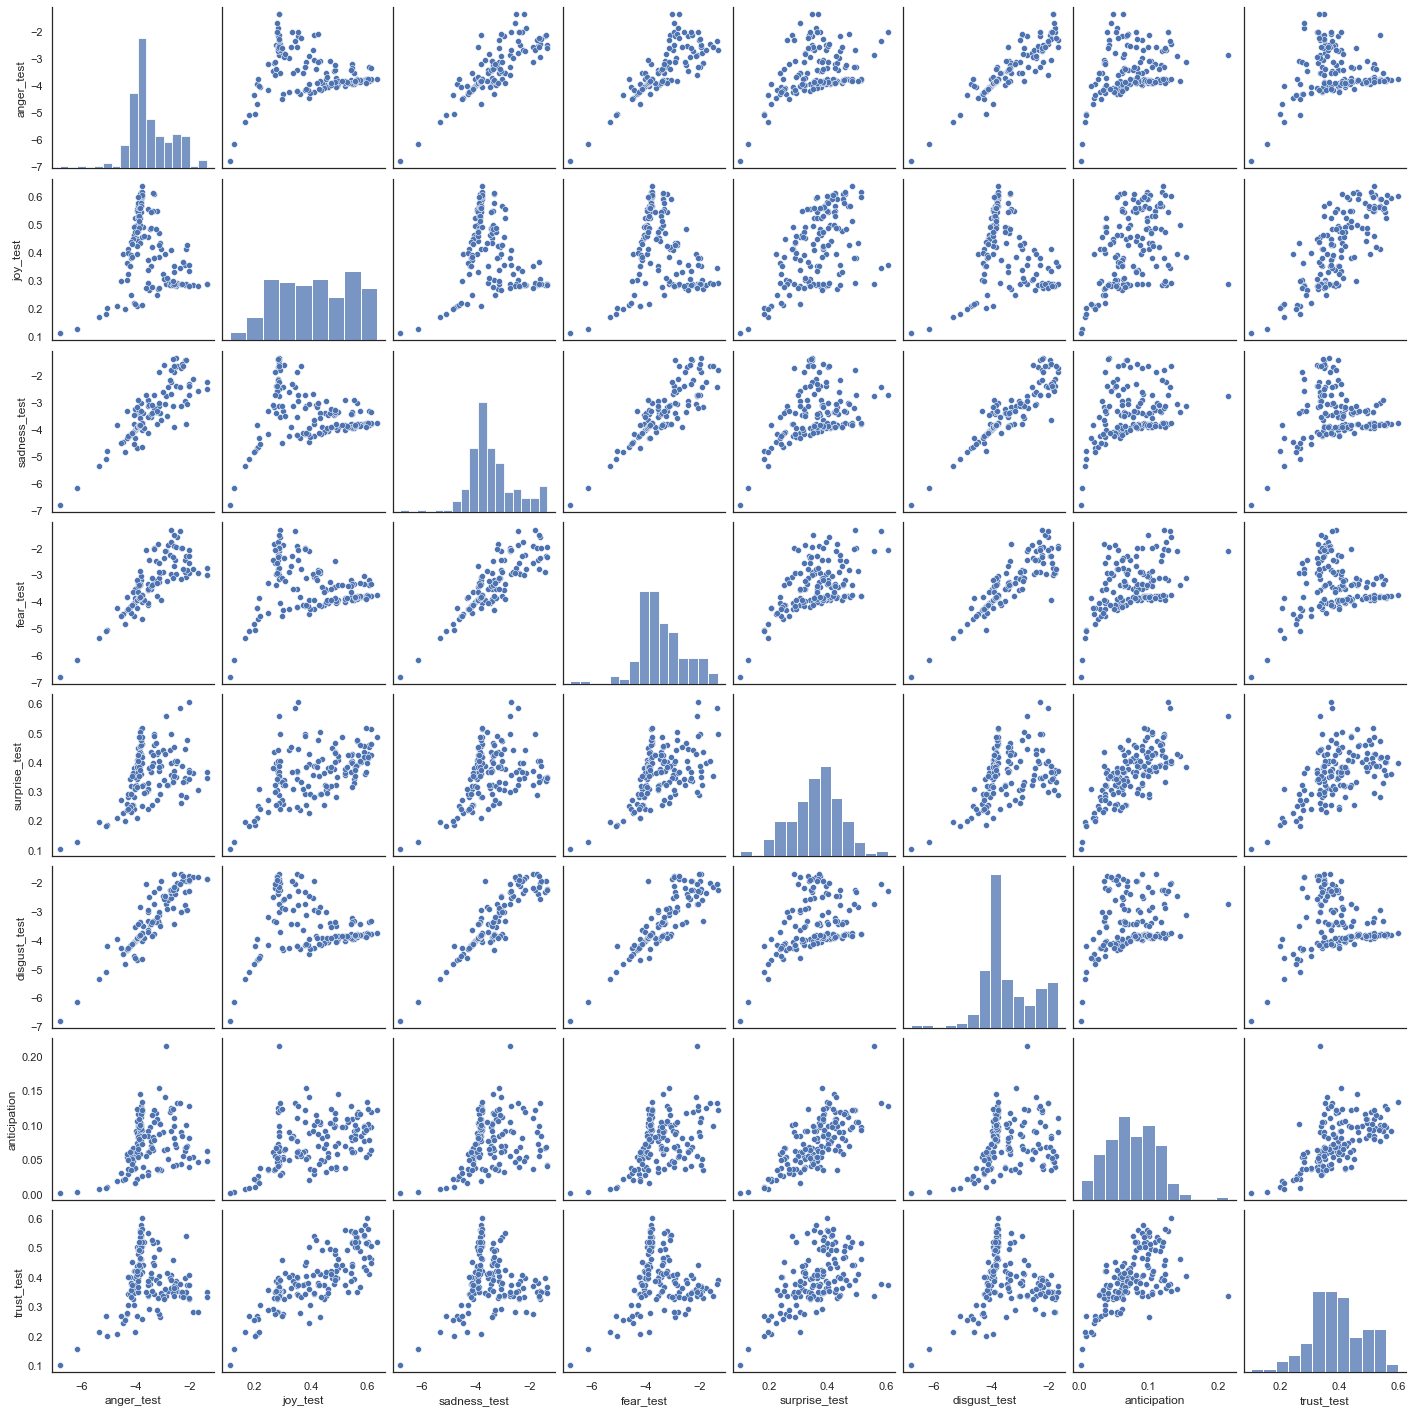

In [195]:
#Make the optimal transformation for each emotion and replot pairplot to see distribution

#Anger
df_le01['anger_test'] = np.log(df_le01['anger'])
                               
#Joy
df_le01['joy_test'] = np.cbrt(df_le01['joy'])
                               
#Sadness
df_le01['sadness_test'] = np.log(df_le01['sadness'])     
                               
#Fear
df_le01['fear_test'] = np.log(df_le01['fear']) 
                               
#Surprise
df_le01['surprise_test'] = np.cbrt(df_le01['surprise']) 
                               
#Disgust
df_le01['disgust_test'] = np.log(df_le01['disgust']) 
                               
#Anticipation is best without a transformation
                               
#Disgust
df_le01['trust_test'] = np.cbrt(df_le01['trust']) 
                               
#Make a list to create pairplot
skew_pp = ['anger_test', 'joy_test', 'sadness_test', 'fear_test', 'surprise_test', 'disgust_test', 'anticipation',
           'trust_test']
                               
#Create plot
sns.pairplot(df_le01[skew_pp])

# Preparation of data for machine learning- Encoding unicode block and other text variables

EDA has highlighted that within certain unicode blocks, specific characterisics are more or less common, therefore this infomation may aid in predictive models and thus this information must be encoded so it can be considered during machine learning. The nature of unicode block categories is that they have no inherent order (it is a nominal variable) therefore this must be reflected in the encoding method selected. One-Hot encoding is therefore an appropriate method to achieve this.

However this may not necessarily be an ideal method for such work as this significantly increases the dimensionality of the data and thus the use of this data may be revised depending on the relative effects of increased dimensionality compared to the information contained in the original column.

In [196]:
# Perform one-hot encoding on nominal variables
df_le01 = pd.get_dummies(df_le01, columns=['Unicode block', 'sent_score_class', 'upper_error_class', 'lower_error_class', 'sent_polar', 'primary_basic_emot'])

df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  sent_polar_Negative  \
0  0.032855  0.065710  0.088298  ...                    0   
1  0.015419  0.024671  0.053967  ...                    0   
2  0.051856  0.028610  0.037551  ...                    0   
3  0.019122  0.040157  0.061191  ...                    0   
4  0.019370  0.067795  0.079417  ...                    0   

   sent_polar_Positive  primary_basic_emot_anger  \
0                    1                         0   
1                    1                         0   
2                    1                         0   
3                    1                         0   
4                    1                         0   

   primary_basic_emot_anticipation  primary_basic_emot_disgust  \
0                                0                           0   
1                                1                           0   
2                                0                           0   
3                                0                           0   
4                                0                           0   

   primary_basic_emot_fear  primary_basic_emot_joy  \
0                        0                       1   
1                        0                       0   
2                        0                       1   
3                        0                       1   
4                        0                       1   

   primary_basic_emot_sadness  primary_basic_emot_surprise  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   primary_basic_emot_trust  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  

[5 rows x 56 columns]

In [197]:
#Verify transformation worked
df_le01.columns.values.tolist()

['unicode',
 'emoji',
 'anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust',
 'Position',
 'le_+',
 'le_-',
 'le_0',
 'sent_score',
 'co_sim_anger',
 'co_sim_joy',
 'co_sim_sadness',
 'co_sim_fear',
 'co_sim_surprise',
 'co_sim_disgust',
 'co_sim_anticipation',
 'co_sim_trust',
 'anger_test',
 'joy_test',
 'sadness_test',
 'fear_test',
 'surprise_test',
 'disgust_test',
 'trust_test',
 'Unicode block_Arrows',
 'Unicode block_Dingbats',
 'Unicode block_Emoticons',
 'Unicode block_Geometric Shapes',
 'Unicode block_Miscellaneous Symbols',
 'Unicode block_Miscellaneous Symbols and Arrows',
 'Unicode block_Miscellaneous Symbols and Pictographs',
 'sent_score_class_Negative',
 'sent_score_class_Neutral',
 'sent_score_class_Positive',
 'upper_error_class_Negative',
 'upper_error_class_Neutral',
 'upper_error_class_Positive',
 'lower_error_class_Negative',
 'lower_error_class_Neutral',
 'lower_error_class_Positive',
 'sent_polar_Negative',
 'sent_polar_Posi

# Preparation for machine learning- Null values

In [198]:
#Check for null values
df_le01.isnull().sum()

unicode                                                 0
emoji                                                   0
anger                                                   0
anticipation                                            0
disgust                                                 0
fear                                                    0
joy                                                     0
sadness                                                 0
surprise                                                0
trust                                                   0
Position                                                0
le_+                                                    0
le_-                                                    0
le_0                                                    0
sent_score                                              0
co_sim_anger                                           17
co_sim_joy                                             17
co_sim_sadness

In [199]:
#Drop columns with null values for the purposes of the testing
df_le01.dropna(inplace=True)
df_le01.isnull().sum()

unicode                                                0
emoji                                                  0
anger                                                  0
anticipation                                           0
disgust                                                0
fear                                                   0
joy                                                    0
sadness                                                0
surprise                                               0
trust                                                  0
Position                                               0
le_+                                                   0
le_-                                                   0
le_0                                                   0
sent_score                                             0
co_sim_anger                                           0
co_sim_joy                                             0
co_sim_sadness                 

# Initial Evaluation of Basic Prediction Models

Given that when this algorithm is to be implemented there will be no data pertaining to other basic emotions available, it is important to only include parameters external to the basic emotion data as these will be available for the real predictions. The following tests will initially be used to evaluate performance predicting anger. If initial results show promise then further work can be carried out using other algorithms.

This first test contains almost all parameters in the dataset. This is a very large number of dimensions and I do not expect the outcome to be optimal. Reduction in dimensionality will be performed later on to improve outcomes.

In [41]:
#Splitting data into train and test
X = df_le01.drop(columns=['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'unicode', 'emoji',
                          'anger_test', 'joy_test', 'sadness_test', 'fear_test', 'surprise_test', 'disgust_test', 'trust_test'])
Y = df_le01['anger_test']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [42]:
#Importing libraries
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
#Create a function to evaluate the regressor and its parameters
def evaluate(reg_cls, params=None):
    reg=reg_cls()
    if params:
        reg=GridSearchCV(reg, param_grid=params, refit=True)
    reg.fit(X_train, Y_train)
    pred=reg.predict(X_test)

    if params:
        print(reg.best_params_)
        reg=reg.best_estimator_
    print('Mean Absolute Error:', mae(Y_test, pred), 'Mean Squared Error:', mean_squared_error(Y_test, pred),
          'R-squared score:', r2_score(Y_test, pred))

    #Calculate the percentage error
    percentage_error = abs(pred - Y_test) / Y_test

    #Count the number of correct predictions within 10% of the actual values
    correct_predictions = sum(percentage_error <= 0.1)

    #Calculate the percentage of correct predictions
    percentage_correct = correct_predictions / len(Y_test) * 100

    print('Percentage of Correct Predictions (within 10%):', percentage_correct, '%')

    return reg, pred

In [53]:
#Apply the function to the models
lr_reg,pred_lr = evaluate(LinearRegression)
rg_reg,pred_rg = evaluate(Ridge)
ls_reg,pred_ls = evaluate(Lasso)
rf_reg,pred_rf = evaluate(RandomForestRegressor)
gb_reg,pred_gb = evaluate(GradientBoostingRegressor)
xg_reg,pred_xg = evaluate(XGBRegressor)
lg_reg,pred_lg = evaluate(LGBMRegressor)

#Define parameters
params={"n_estimators":[100*i for i in range(1, 6)]}

Mean Absolute Error: 0.025400006918706093 Mean Squared Error: 0.001438251899501559 R-squared score: 0.5016397509748147
Percentage of Correct Predictions (within 10%): 22.22222222222222 %
Mean Absolute Error: 0.023737061615935553 Mean Squared Error: 0.0012648286000514484 R-squared score: 0.5617316435915938
Percentage of Correct Predictions (within 10%): 22.22222222222222 %
Mean Absolute Error: 0.03613920272838012 Mean Squared Error: 0.0029867825229544765 R-squared score: -0.03493253333405444
Percentage of Correct Predictions (within 10%): 3.7037037037037033 %
Mean Absolute Error: 0.026139695975597114 Mean Squared Error: 0.0014829331071288627 R-squared score: 0.48615752719495653
Percentage of Correct Predictions (within 10%): 7.4074074074074066 %
Mean Absolute Error: 0.02330919241828294 Mean Squared Error: 0.0013138604345762407 R-squared score: 0.5447419095454191
Percentage of Correct Predictions (within 10%): 18.51851851851852 %
Mean Absolute Error: 0.024796492658964945 Mean Squared Err

There are really poor outcomes here. This is likely due to the extremely high dimensionality of the data. The next step will be to reduce dimensionality and try again.

In [54]:
#Redefine X with fewer parameters
#Splitting data into train and test
X = df_le01[['Position', 'le_+', 'le_-', 'le_0', 'sent_score', 'co_sim_anger', 'co_sim_joy', 'co_sim_sadness',
             'co_sim_fear', 'co_sim_surprise', 'co_sim_disgust', 'co_sim_anticipation', 'co_sim_trust']]
Y = df_le01['anger']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [55]:
#Apply the above function onto the models
lr_reg,pred_lr = evaluate(LinearRegression)
rg_reg,pred_rg = evaluate(Ridge)
ls_reg,pred_ls = evaluate(Lasso)
rf_reg,pred_rf = evaluate(RandomForestRegressor)
gb_reg,pred_gb = evaluate(GradientBoostingRegressor)
xg_reg,pred_xg = evaluate(XGBRegressor)
lg_reg,pred_lg = evaluate(LGBMRegressor)

#Define parameters
params={"n_estimators":[100*i for i in range(1, 6)]}

Mean Absolute Error: 0.01727765761426144 Mean Squared Error: 0.0005015268181156199 R-squared score: 0.7415183007759394
Percentage of Correct Predictions (within 10%): 22.22222222222222 %
Mean Absolute Error: 0.018752787452383266 Mean Squared Error: 0.0007552914483412736 R-squared score: 0.6107306530283154
Percentage of Correct Predictions (within 10%): 18.51851851851852 %
Mean Absolute Error: 0.03312143638245074 Mean Squared Error: 0.0019456836201386606 R-squared score: -0.0027850757323224506
Percentage of Correct Predictions (within 10%): 0.0 %
Mean Absolute Error: 0.020082859925153945 Mean Squared Error: 0.0009989504125790753 R-squared score: 0.48515136029178596
Percentage of Correct Predictions (within 10%): 11.11111111111111 %
Mean Absolute Error: 0.026540078015059795 Mean Squared Error: 0.0015332066539499362 R-squared score: 0.20980125716177944
Percentage of Correct Predictions (within 10%): 11.11111111111111 %
Mean Absolute Error: 0.022850324237551307 Mean Squared Error: 0.001246

In [56]:
#Create a function to evaluate the outcomes in more detail
def evaluate_detail(reg_cls, params=None):
    reg=reg_cls()
    if params:
        reg=GridSearchCV(reg, param_grid=params, refit=True)
    reg.fit(X_train, Y_train)
    pred=reg.predict(X_test)

    if params:
        print(reg.best_params_)
        reg=reg.best_estimator_
    print('Mean Absolute Error:', mae(Y_test, pred)),
    print('Mean Squared Error:', mean_squared_error(Y_test, pred)),
    print('R-squared score:', r2_score(Y_test, pred))

    #Calculate the percentage error
    percentage_error = abs(pred - Y_test) / Y_test

    #Count the number of correct predictions within 2% of the actual values
    correct_predictions_2 = sum(percentage_error <= 0.02)
    percentage_correct_2 = correct_predictions_2 / len(Y_test) * 100
    print('Percentage of Correct Predictions (within 2%):', percentage_correct_2, '%')

    #Count the number of correct predictions within 5% of the actual values
    correct_predictions_5 = sum(percentage_error <= 0.05)
    percentage_correct_5 = correct_predictions_5 / len(Y_test) * 100
    print('Percentage of Correct Predictions (within 5%):', percentage_correct_5, '%')


    #Count the number of correct predictions within 10% of the actual values
    correct_predictions_10 = sum(percentage_error <= 0.1)
    percentage_correct_10 = correct_predictions_10 / len(Y_test) * 100
    print('Percentage of Correct Predictions (within 10%):', percentage_correct_10, '%')

    #Count the number of correct predictions within 20% of the actual values
    correct_predictions_20 = sum(percentage_error <= 0.2)
    percentage_correct_20 = correct_predictions_20 / len(Y_test) * 100
    print('Percentage of Correct Predictions (within 20%):', percentage_correct_20, '%')

    return reg, pred

In [57]:
#Look at XGBRegressor performance in more detail
xg_reg,pred_xg = evaluate_detail(XGBRegressor)
params={"n_estimators":[100*i for i in range(1, 6)]}

Mean Absolute Error: 0.022850324237551307
Mean Squared Error: 0.001246742886376602
R-squared score: 0.357441699773986
Percentage of Correct Predictions (within 2%): 7.4074074074074066 %
Percentage of Correct Predictions (within 5%): 7.4074074074074066 %
Percentage of Correct Predictions (within 10%): 14.814814814814813 %
Percentage of Correct Predictions (within 20%): 33.33333333333333 %


# Preparation to evaluate Neural Networks- Emoji Embeddings Dictionary

Neural networks are more complex models that can also potentially be used for prediction. They can capture more subtle relationships and patterns in the data and therefore may have improved outcomes for this purpose.

In [43]:
#Create an embedding dictionary
embeddings_dictionary = dict()

#Iterate through each row in the dataset
for index, row in df_le01.iterrows():
    emoji = row['emoji']

    #Check if the emoji exists in the KeyedVectors object
    if emoji in emoji2vec.key_to_index:
        vector_dimensions = emoji2vec.get_vector(emoji)
        embeddings_dictionary[emoji] = vector_dimensions

In [44]:
#Determine the number of unique emojis in the dataset at present
vocab_length = len(df_le01['emoji'].unique())
print(vocab_length)

132


In [45]:
#Create the embeddings matrix with all zeros
embedding_matrix = np.zeros((vocab_length, 300))
embedding_matrix.shape

(132, 300)

In [46]:
#Reset the DataFrame index
df_le01.reset_index(drop=True, inplace=True)

In [47]:
#Loop through each row to populate data for each unique emoji into the embedding
for i, row in df_le01.iterrows():
    emoji = row['emoji']
    if emoji in embeddings_dictionary:
        vector_dimensions = np.asarray(embeddings_dictionary[emoji], dtype="float32")
        embedding_matrix[i] = vector_dimensions

# Initial Evaluation of Neural Networks

In [48]:
#Importing libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding
from keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers import Reshape
from keras.layers import BatchNormalization, GlobalMaxPooling1D
from keras.regularizers import l1, l2

In [49]:
#Define a function to map the embedding from the dictionary onto the emoji, otherwise use an empty vector
def map_emoji_to_embedding(emoji):
    if emoji in embeddings_dictionary:
        return embeddings_dictionary[emoji]
    else:
        return np.zeros(300)

#Apply the function
df_le01['emoji_embedding'] = df_le01['emoji'].apply(map_emoji_to_embedding)
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  sent_polar_Positive  \
0  0.032855  0.065710  0.088298  ...                    1   
1  0.015419  0.024671  0.053967  ...                    1   
2  0.051856  0.028610  0.037551  ...                    1   
3  0.019122  0.040157  0.061191  ...                    1   
4  0.019370  0.067795  0.079417  ...                    1   

   primary_basic_emot_anger  primary_basic_emot_anticipation  \
0                         0                                0   
1                         0                                1   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   primary_basic_emot_disgust  primary_basic_emot_fear  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   primary_basic_emot_joy  primary_basic_emot_sadness  \
0                       1                           0   
1                       0                           0   
2                       1                           0   
3                       1                           0   
4                       1                           0   

   primary_basic_emot_surprise  primary_basic_emot_trust  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

                                     emoji_embedding  
0  [-0.272291, 1.1176019, 1.4234279, 1.7466365, -...  
1  [-0.89786303, 1.9509411, -1.3655221, 1.5510684...  
2  [-0.07155819, 2.6526983, 0.9026799, 0.7054407,...  
3  [1.5490977, 1.5981269, 0.27876318, -0.60552436...  
4  [1.6323674, 1.010914, 2.2080367, 0.37723196, 1...  

[5 rows x 50 columns]

In [65]:
#Define input and target parameters
X = df_le01[['emoji_embedding', 'Position', 'le_+', 'le_-', 'le_0', 'sent_score', 'co_sim_anger', 'co_sim_joy', 'co_sim_sadness',
             'co_sim_fear', 'co_sim_surprise', 'co_sim_disgust', 'co_sim_anticipation', 'co_sim_trust']]
Y = df_le01['anger']

#Convert emoji embeddings to numpy arrays
X = np.array(df_le01['emoji_embedding'].tolist())

#Split data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [50]:
#Define the custom evaluation metrics

#Within 2%
def accuracy_within_2_percent(y_true, y_pred):
    #Calculate the percentage difference between true and predicted values
    percentage_difference = tf.abs((y_true - y_pred) / y_true) * 100.0

    #Check if the percentage difference is within 5%
    within_2_percent = tf.less_equal(percentage_difference, 2.0)

    #Calculate the mean accuracy within 5%
    mean_accuracy_within_2_percent = tf.reduce_mean(tf.cast(within_2_percent, tf.float32))
    return mean_accuracy_within_2_percent

#Repeat for a % difference within 5%
def accuracy_within_5_percent(y_true, y_pred):
    percentage_difference = tf.abs((y_true - y_pred) / y_true) * 100.0
    within_5_percent = tf.less_equal(percentage_difference, 5.0)
    mean_accuracy_within_5_percent = tf.reduce_mean(tf.cast(within_5_percent, tf.float32))
    return mean_accuracy_within_5_percent

#Repeat for a % difference within 10%
def accuracy_within_10_percent(y_true, y_pred):
    percentage_difference = tf.abs((y_true - y_pred) / y_true) * 100.0
    within_10_percent = tf.less_equal(percentage_difference, 10.0)
    mean_accuracy_within_10_percent = tf.reduce_mean(tf.cast(within_10_percent, tf.float32))
    return mean_accuracy_within_10_percent

In [51]:
#Importing libraries
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [68]:
#Start with a basic feedforward neural network

#Create a feedforward neural network architecture
NN_model = Sequential()

#Input Layer
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

#Hidden Layers
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

#The Output Layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Compile the network
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_5_percent])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               38528     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 203,393
Trainable params: 203,393
Non-trainable params: 0
_________________________________________________________________


In [69]:
#Create a checkpoint callback to save model weights during training
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
#Only if they are better than the previous optimal option
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1,
                             save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [70]:
#Train the model
history = NN_model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split = 0.2,
                       callbacks=callbacks_list)

Epoch 1/500
1/3 [=========>....................] - ETA: 3s - loss: 0.2372 - mean_absolute_error: 0.2372 - accuracy_within_5_percent: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.03041, saving model to Weights-001--0.03041.hdf5
3/3 [==============================] - 2s 189ms/step - loss: 0.1370 - mean_absolute_error: 0.1370 - accuracy_within_5_percent: 0.0646 - val_loss: 0.0304 - val_mean_absolute_error: 0.0304 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0489 - mean_absolute_error: 0.0489 - accuracy_within_5_percent: 0.0625
Epoch 2: val_loss improved from 0.03041 to 0.02494, saving model to Weights-002--0.02494.hdf5
3/3 [==============================] - 0s 55ms/step - loss: 0.0488 - mean_absolute_error: 0.0488 - accuracy_within_5_percent: 0.0208 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 0.03

In [71]:
#Load weights file of the best model and recompile the model
weights_file = 'Weights-219--0.01308.hdf5'
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_2_percent,
                                                                        accuracy_within_5_percent, accuracy_within_10_percent])

In [72]:
#Evaluate the model on the test data
results = NN_model.evaluate(X_test, Y_test)

1/1 [==============================] - 1s 850ms/step - loss: 0.0230 - mean_absolute_error: 0.0230 - accuracy_within_2_percent: 0.0000e+00 - accuracy_within_5_percent: 0.0000e+00 - accuracy_within_10_percent: 0.0741


In [74]:
#Play around with hyperparams manually to try to improve results

#Start new NN
NN_model = Sequential()

#Input Layer
NN_model.add(Dense(64, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.015)))

#Hidden Layers
NN_model.add(Dense(16, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

NN_model.add(Dense(8, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
#NN_model.add(Dropout(0.2))

#Output Layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Compile the network
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_5_percent])
NN_model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
history1 = NN_model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split = 0.25, callbacks=callbacks_list)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                19264     
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 20,449
Trainable params: 20,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/3 [=========>....................] -

In [75]:
#Load weights file of the best model and recompile the model
weights_file = 'Weights-480--0.02489.hdf5'
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_2_percent,
                                                                        accuracy_within_5_percent, accuracy_within_10_percent])

In [76]:
#Evaluate the model on the test data
results = NN_model.evaluate(X_test, Y_test)

1/1 [==============================] - 1s 681ms/step - loss: 0.0214 - mean_absolute_error: 0.0193 - accuracy_within_2_percent: 0.0000e+00 - accuracy_within_5_percent: 0.0000e+00 - accuracy_within_10_percent: 0.0741


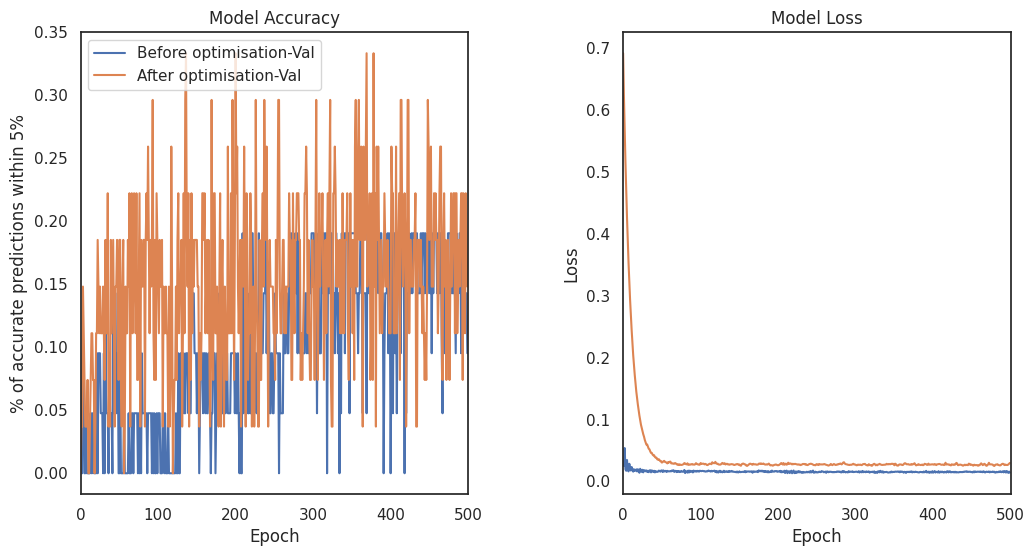

In [79]:
#Compare the two models performance over training duration using plots

#Define plot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Accuracy plot
axs[0].plot(history.history["val_accuracy_within_5_percent"], label="Before optimisation-Val")
axs[0].plot(history1.history["val_accuracy_within_5_percent"], label="After optimisation-Val")
axs[0].set_title("Model Accuracy")
axs[0].set_ylabel("% of accurate predictions within 5%")
axs[0].set_xlabel("Epoch")
axs[0].set_xlim(0, 500)
axs[0].legend()

#Loss subplot
axs[1].plot(history.history["val_loss"], label="")
axs[1].plot(history1.history["val_loss"], label="")
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xlim(0, 500)

#Adjust spacing
plt.subplots_adjust(wspace=0.4)

#Display plots
plt.show()

In [81]:
#Assess CNN impacts in the model and play with hyperparams

#Create the model
NN_model = Sequential()

#Input Layer (Reshape data to add a third dimension)
NN_model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Convolutional layers
NN_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
NN_model.add(MaxPooling1D(pool_size=2))

#Hidden Layers
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

NN_model.add(Dense(512, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

#Output Layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Compile the network
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_5_percent])
NN_model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

#Train the model
history3 = NN_model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.25, callbacks=callbacks_list)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 300, 1)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 298, 32)           128       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 dense_17 (Dense)            (None, 149, 256)          8448      
                                                                 
 batch_normalization_1 (Batc  (None, 149, 256)         1024      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 149, 256)         

In [ ]:
#Load weights file of the best model and recompile the model
weights_file = 'Weights-028--0.02776.hdf5'
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_2_percent,
                                                                        accuracy_within_5_percent, accuracy_within_10_percent])

In [ ]:
#Evaluate the model on the test data
results = NN_model.evaluate(X_test, Y_test)

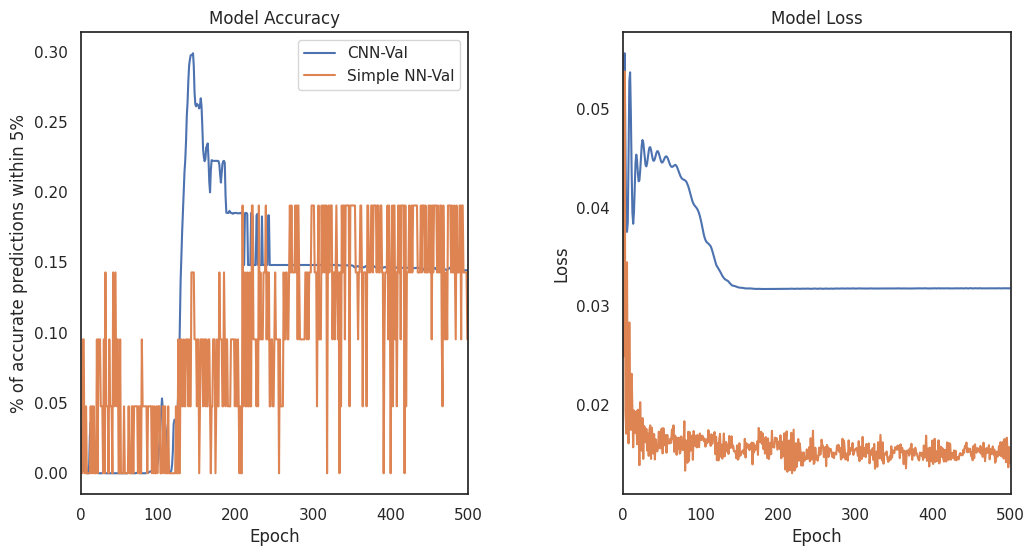

In [83]:
#Compare the CNN models performance against the feedforward NN over training duration using plots

#Define plot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Accuracy plot
axs[0].plot(history3.history["val_accuracy_within_5_percent"], label="CNN-Val")
axs[0].plot(history.history["val_accuracy_within_5_percent"], label="Simple NN-Val")
axs[0].set_title("Model Accuracy")
axs[0].set_ylabel("% of accurate predictions within 5%")
axs[0].set_xlabel("Epoch")
axs[0].set_xlim(0, 500)
axs[0].legend()

#Loss subplot
axs[1].plot(history3.history["val_loss"], label="")
axs[1].plot(history.history["val_loss"], label="")
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xlim(0, 500)

#Adjust spacing
plt.subplots_adjust(wspace=0.4)

#Display plots
plt.show()

In [84]:
#Play with outcomes using an LSTM layer

#Create the model
NN_model = Sequential()

#Input Layer (Reshape to add a third dimension)
NN_model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

NN_model.add(LSTM(64))

#Hidden Layers
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu', kernel_regularizer=l2(0.01)))
#NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

NN_model.add(Dense(512, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
#NN_model.add(Dropout(0.2))

#Output Layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Compile the network
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_5_percent])
NN_model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

#Train the model
history4 = NN_model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.25, callbacks=callbacks_list)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 300, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_21 (Dense)            (None, 256)               16640     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 512)              

In [ ]:
#Load weights file of the best model and recompile the model
weights_file = 'Weights-028--0.02776.hdf5'
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_2_percent,
                                                                        accuracy_within_5_percent, accuracy_within_10_percent])

In [ ]:
#Evaluate the model on the test data
results = NN_model.evaluate(X_test, Y_test)

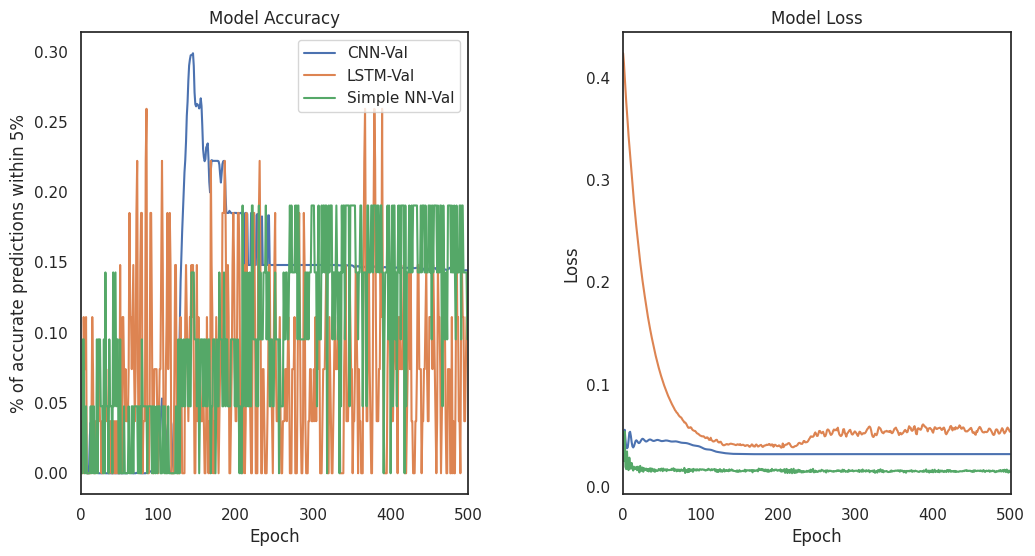

In [85]:
#Compare the CNN models performance against the feedforward NN over training duration using plots

#Define plot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Accuracy plot
axs[0].plot(history3.history["val_accuracy_within_5_percent"], label="CNN-Val")
axs[0].plot(history4.history["val_accuracy_within_5_percent"], label="LSTM-Val")
axs[0].plot(history.history["val_accuracy_within_5_percent"], label="Simple NN-Val")
axs[0].set_title("Model Accuracy")
axs[0].set_ylabel("% of accurate predictions within 5%")
axs[0].set_xlabel("Epoch")
axs[0].set_xlim(0, 500)
axs[0].legend()

#Loss subplot
axs[1].plot(history3.history["val_loss"], label="")
axs[1].plot(history4.history["val_loss"], label="")
axs[1].plot(history.history["val_loss"], label="")
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xlim(0, 500)

#Adjust spacing
plt.subplots_adjust(wspace=0.4)

#Display plots
plt.show()

# Look at automated hyperparameter tuning for neural networks to improve performance

In [88]:
#Install libraries
#!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.5 MB/s eta 0:00:00


In [52]:
#Importing libraries
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold, ShuffleSplit
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
import time as time_module
import kerastuner as kt

In [53]:
#Start with a very basic option

#Define function for hyperparameter tuning
def build_model(hp):
    #Start model
    model = keras.Sequential()
    #Input layer (Reshape as before)
    model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))
    #Hidden layers (Only one- vary the units to find the best outcome)
    model.add(layers.Dense(units=hp.Int('units',
                                       min_value=4,
                                       max_value=1028,
                                       step=64),
                          #Activation not varied in this case
                          activation='relu'))
    #Output layer
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    #Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            #Vary the learning rate to find optimal value
            hp.Choice('learning_rate',
                      values = [1e-2, 1e-3, 1e-4, 1e-5])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error', accuracy_within_5_percent])
    return model

In [95]:
#Define tuner to test models with varying parameters -5 trials
tuner = RandomSearch(build_model,
                    objective='mean_absolute_error',
                    max_trials=3,
                    executions_per_trial=1,
                    )

In [96]:
#Print search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 1028, 'step': 64, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [97]:
#Perform the random search
tuner.search(X_train, Y_train,
            epochs=250,
            validation_data=(X_test, Y_test)
            )

Trial 3 Complete [00h 00m 43s]
mean_absolute_error: 0.032961852848529816

Best mean_absolute_error So Far: 0.02656719647347927
Total elapsed time: 00h 04m 32s


In [98]:
#Print results summary
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="mean_absolute_error", direction="min")

Trial 1 summary
Hyperparameters:
units: 516
learning_rate: 0.0001
Score: 0.02656719647347927

Trial 0 summary
Hyperparameters:
units: 964
learning_rate: 0.001
Score: 0.026635820046067238

Trial 2 summary
Hyperparameters:
units: 4
learning_rate: 1e-05
Score: 0.032961852848529816


In [54]:
#Create a more complex function to assess more parameters

#Define function for hyperparameter tuning
def build_model(hp):
    #Start model
    model = keras.Sequential()
    #Input layer
    inp = tf.keras.layers.Input(shape=(X_train.shape[1],))
    #Test models with up to 6 dense layers
    num_dense = hp.Int('num_dense', min_value=1, max_value=6, step=1)
    #Iterate through each layer
    for i in range(num_dense):
        #Define units to test
        hp_units = hp.Int('units_{i}'.format(i=i), min_value=8, max_value=4096, step=128)
        #Define dropout values to test
        hp_drop_rate = hp.Choice('dp_{i}'.format(i=i), values=[0.0, 0.1, 0.15, 0.2, 0.25 ,0.3,
                                                               0.35,0.4, 0.5, 0.6, 0.7])
        #Define activation functions to test
        hp_activation = hp.Choice('dense_activation_{i}'.format(i=i),values=['relu', 'selu',
                                                                             'elu', 'swish'])
        #Define the way data flows through hidden layers
        x = tf.keras.layers.Dense(units=hp_units, activation=hp_activation)(inp)
        x = tf.keras.layers.Dropout(hp_drop_rate)(x)
        x = tf.keras.layers.BatchNormalization()(x)
    #Output layer
    outputs = tf.keras.layers.Dense(1, kernel_initializer='normal', activation='linear')(x)
    #Create the model with the defined input and outputs
    model = tf.keras.models.Model(inp, outputs)
    #Compile the model
    model.compile(
      optimizer=keras.optimizers.Adam(
        #Define learning rates to test
        hp.Choice('learning_rate', values = [1e-3, 1e-4, 1e-5, 0.0])),
      loss='mean_absolute_error',
      metrics=['mean_absolute_error', accuracy_within_5_percent])
    return model

In [55]:
#Define X and Y parameters
X = df_le01.drop(columns=['unicode', 'emoji', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
                          'sadness', 'surprise', 'trust'])
Y = df_le01['anger']

#Convert the emoji embedding to a numpy array
X = np.array(df_le01['emoji_embedding'].tolist())

#Check shape of data
X.shape, Y.shape

((132, 300), (132,))

In [56]:
#Defining parameters
feats = np.arange(0,X.shape[1],1)
inp_size = int(np.ceil(1* len(feats)))
n_split = 5
n_repeats = 1
bests=[]
seeds = [0, 1]
n_round = len(seeds)
shuffle_split_size = 0.2

for seed in seeds:
    split_cols = np.random.choice(feats, inp_size, replace=False)
    #Use k fold cross validation to split data into train and test
    for n, (train, test) in enumerate(KFold(n_splits = n_split, random_state=0,
                                       shuffle = True).split(X, Y)):
        st = time_module.time()
        #Define tuning objectives and params
        tuner = kt.tuners.BayesianOptimization(build_model,
                     kt.Objective('val_accuracy_within_5_percent', direction="max"),
                     max_trials = 150, overwrite=True)
        start_time = time_module.time()
        X_train = X[train][:, split_cols]
        X_val = X[test][:, split_cols]
        Y_train, Y_val = Y[train], Y[test]
        #Early stop if the validation accuracy does not improve for 20 epochs
        callbacks=[EarlyStopping(monitor='val_accuracy_within_5_percent', mode='max', patience=20)]
        start_time = time_module.time()
        #Perform hyperparameter search using train and val data
        tuner.search(X_train, Y_train,validation_data=(X_val, Y_val),
                            epochs = 500, batch_size = 128,
                            verbose = 0, callbacks = callbacks)
        #Create method to recall best hyperparameters identified during the trial
        n_top = 5
        best_hps = tuner.get_best_hyperparameters(n_top)
        end_time = time_module.time()
        bests.append(best_hps)
        for i in range(n_top):
            print(best_hps[i].values)
        #Print statements to monitor the progress of the tests
        print('Seed', seed, 'Fold', n, 'Time elapsed:', "{:.2f}".format((end_time-start_time)/60), 'minutes')
        #Delete old tuner for memory conservation
        del tuner

INFO:tensorflow:Oracle triggered exit
{'num_dense': 3, 'units_0': 3336, 'dp_0': 0.7, 'dense_activation_0': 'swish', 'learning_rate': 0.0, 'units_1': 1416, 'dp_1': 0.15, 'dense_activation_1': 'swish', 'units_2': 8, 'dp_2': 0.0, 'dense_activation_2': 'relu'}
{'num_dense': 3, 'units_0': 776, 'dp_0': 0.5, 'dense_activation_0': 'selu', 'learning_rate': 0.0, 'units_1': 1288, 'dp_1': 0.5, 'dense_activation_1': 'selu', 'units_2': 2312, 'dp_2': 0.3, 'dense_activation_2': 'elu', 'units_3': 2824, 'dp_3': 0.5, 'dense_activation_3': 'selu', 'units_4': 1032, 'dp_4': 0.1, 'dense_activation_4': 'swish', 'units_5': 1160, 'dp_5': 0.5, 'dense_activation_5': 'selu'}
{'num_dense': 1, 'units_0': 3592, 'dp_0': 0.25, 'dense_activation_0': 'swish', 'learning_rate': 0.0001, 'units_1': 1032, 'dp_1': 0.4, 'dense_activation_1': 'elu', 'units_2': 2184, 'dp_2': 0.3, 'dense_activation_2': 'selu', 'units_3': 2568, 'dp_3': 0.3, 'dense_activation_3': 'relu', 'units_4': 8, 'dp_4': 0.2, 'dense_activation_4': 'elu', 'units

INFO:tensorflow:Oracle triggered exit
{'num_dense': 6, 'units_0': 136, 'dp_0': 0.1, 'dense_activation_0': 'selu', 'learning_rate': 0.0, 'units_1': 2568, 'dp_1': 0.35, 'dense_activation_1': 'swish', 'units_2': 1672, 'dp_2': 0.3, 'dense_activation_2': 'elu', 'units_3': 1160, 'dp_3': 0.2, 'dense_activation_3': 'selu', 'units_4': 1544, 'dp_4': 0.0, 'dense_activation_4': 'elu', 'units_5': 1928, 'dp_5': 0.6, 'dense_activation_5': 'relu'}
{'num_dense': 3, 'units_0': 520, 'dp_0': 0.25, 'dense_activation_0': 'relu', 'learning_rate': 0.0001, 'units_1': 2952, 'dp_1': 0.25, 'dense_activation_1': 'selu', 'units_2': 264, 'dp_2': 0.6, 'dense_activation_2': 'selu', 'units_3': 2056, 'dp_3': 0.4, 'dense_activation_3': 'relu', 'units_4': 3720, 'dp_4': 0.6, 'dense_activation_4': 'relu', 'units_5': 3720, 'dp_5': 0.6, 'dense_activation_5': 'swish'}
{'num_dense': 3, 'units_0': 2824, 'dp_0': 0.6, 'dense_activation_0': 'relu', 'learning_rate': 0.001, 'units_1': 3464, 'dp_1': 0.7, 'dense_activation_1': 'selu', 

INFO:tensorflow:Oracle triggered exit
{'num_dense': 4, 'units_0': 264, 'dp_0': 0.0, 'dense_activation_0': 'selu', 'learning_rate': 0.001, 'units_1': 1160, 'dp_1': 0.3, 'dense_activation_1': 'selu', 'units_2': 2184, 'dp_2': 0.2, 'dense_activation_2': 'elu', 'units_3': 8, 'dp_3': 0.2, 'dense_activation_3': 'swish', 'units_4': 1288, 'dp_4': 0.4, 'dense_activation_4': 'relu', 'units_5': 1160, 'dp_5': 0.1, 'dense_activation_5': 'relu'}
{'num_dense': 6, 'units_0': 648, 'dp_0': 0.7, 'dense_activation_0': 'elu', 'learning_rate': 1e-05, 'units_1': 3976, 'dp_1': 0.7, 'dense_activation_1': 'swish', 'units_2': 3208, 'dp_2': 0.0, 'dense_activation_2': 'elu', 'units_3': 2056, 'dp_3': 0.6, 'dense_activation_3': 'elu', 'units_4': 136, 'dp_4': 0.4, 'dense_activation_4': 'relu', 'units_5': 8, 'dp_5': 0.0, 'dense_activation_5': 'relu'}
{'num_dense': 3, 'units_0': 1544, 'dp_0': 0.2, 'dense_activation_0': 'elu', 'learning_rate': 0.0001, 'units_1': 1416, 'dp_1': 0.3, 'dense_activation_1': 'swish', 'units_2'

In [60]:
#Print outcome from fold 0 seed 0
print(bests[0][0].values)

{'num_dense': 3, 'units_0': 3336, 'dp_0': 0.7, 'dense_activation_0': 'swish', 'learning_rate': 0.0, 'units_1': 1416, 'dp_1': 0.15, 'dense_activation_1': 'swish', 'units_2': 8, 'dp_2': 0.0, 'dense_activation_2': 'relu'}


In [86]:
#Print outcome from fold 1 seed 0
print(bests[1][0].values)

{'num_dense': 6, 'units_0': 2312, 'dp_0': 0.2, 'dense_activation_0': 'swish', 'learning_rate': 0.001, 'units_1': 1544, 'dp_1': 0.4, 'dense_activation_1': 'elu', 'units_2': 1160, 'dp_2': 0.15, 'dense_activation_2': 'elu', 'units_3': 1928, 'dp_3': 0.5, 'dense_activation_3': 'elu', 'units_4': 2696, 'dp_4': 0.15, 'dense_activation_4': 'selu', 'units_5': 8, 'dp_5': 0.0, 'dense_activation_5': 'relu'}


In [87]:
#Print outcome from fold 2 seed 0
print(bests[2][0].values)

{'num_dense': 2, 'units_0': 2440, 'dp_0': 0.3, 'dense_activation_0': 'relu', 'learning_rate': 1e-05, 'units_1': 8, 'dp_1': 0.0, 'dense_activation_1': 'relu'}


In [88]:
#Print outcome from fold 3 seed 0
print(bests[3][0].values)

{'num_dense': 2, 'units_0': 776, 'dp_0': 0.0, 'dense_activation_0': 'relu', 'learning_rate': 0.0001, 'units_1': 8, 'dp_1': 0.3, 'dense_activation_1': 'swish', 'units_2': 3720, 'dp_2': 0.1, 'dense_activation_2': 'elu', 'units_3': 1544, 'dp_3': 0.6, 'dense_activation_3': 'swish'}


In [89]:
#Print outcome from fold 4 seed 0
print(bests[4][0].values)

{'num_dense': 5, 'units_0': 8, 'dp_0': 0.2, 'dense_activation_0': 'relu', 'learning_rate': 0.001, 'units_1': 392, 'dp_1': 0.1, 'dense_activation_1': 'relu', 'units_2': 2568, 'dp_2': 0.25, 'dense_activation_2': 'relu', 'units_3': 8, 'dp_3': 0.0, 'dense_activation_3': 'relu', 'units_4': 8, 'dp_4': 0.0, 'dense_activation_4': 'relu'}


In [80]:
#Look at the top models in more detail to see how they perform
#Best outcome for fold 0, seed 0  

#Start new NN
model = keras.Sequential()

#Input layer (Reshape)
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Hidden Layers
model.add(Dense(3336, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.7))

model.add(Dense(1416, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.2))

model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.0))

#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Compile the network
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = '1ST Seed1 Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
history00 = model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.25, callbacks = callbacks_list)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 300, 1)            0         
                                                                 
 dense_33 (Dense)            (None, 300, 3336)         6672      
                                                                 
 dropout_25 (Dropout)        (None, 300, 3336)         0         
                                                                 
 dense_34 (Dense)            (None, 300, 1416)         4725192   
                                                                 
 dropout_26 (Dropout)        (None, 300, 1416)         0         
                                                                 
 dense_35 (Dense)            (None, 300, 8)            11336     
                                                                 
 dropout_27 (Dropout)        (None, 300, 8)           

Epoch 16/500
1/1 [==============================] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.0289 - accuracy_within_5_percent: 0.0414
Epoch 16: val_accuracy_within_5_percent did not improve from 0.04284
1/1 [==============================] - 3s 3s/step - loss: 0.0289 - mean_absolute_error: 0.0289 - accuracy_within_5_percent: 0.0414 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458 - val_accuracy_within_5_percent: 0.0236
Epoch 17/500
1/1 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300 - accuracy_within_5_percent: 0.0422
Epoch 17: val_accuracy_within_5_percent did not improve from 0.04284
1/1 [==============================] - 3s 3s/step - loss: 0.0300 - mean_absolute_error: 0.0300 - accuracy_within_5_percent: 0.0422 - val_loss: 0.0468 - val_mean_absolute_error: 0.0468 - val_accuracy_within_5_percent: 0.0217
Epoch 18/500
1/1 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300 - accuracy_within_5_percent

Epoch 35/500
1/1 [==============================] - ETA: 0s - loss: 0.0258 - mean_absolute_error: 0.0258 - accuracy_within_5_percent: 0.0707
Epoch 35: val_accuracy_within_5_percent did not improve from 0.06272
1/1 [==============================] - 3s 3s/step - loss: 0.0258 - mean_absolute_error: 0.0258 - accuracy_within_5_percent: 0.0707 - val_loss: 0.0430 - val_mean_absolute_error: 0.0430 - val_accuracy_within_5_percent: 0.0233
Epoch 36/500
1/1 [==============================] - ETA: 0s - loss: 0.0254 - mean_absolute_error: 0.0254 - accuracy_within_5_percent: 0.0636
Epoch 36: val_accuracy_within_5_percent did not improve from 0.06272
1/1 [==============================] - 3s 3s/step - loss: 0.0254 - mean_absolute_error: 0.0254 - accuracy_within_5_percent: 0.0636 - val_loss: 0.0426 - val_mean_absolute_error: 0.0426 - val_accuracy_within_5_percent: 0.0274
Epoch 37/500
1/1 [==============================] - ETA: 0s - loss: 0.0258 - mean_absolute_error: 0.0258 - accuracy_within_5_percent

Epoch 54/500
1/1 [==============================] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.0246 - accuracy_within_5_percent: 0.0904
Epoch 54: val_accuracy_within_5_percent did not improve from 0.07049
1/1 [==============================] - 3s 3s/step - loss: 0.0246 - mean_absolute_error: 0.0246 - accuracy_within_5_percent: 0.0904 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0372
Epoch 55/500
1/1 [==============================] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.0246 - accuracy_within_5_percent: 0.0889
Epoch 55: val_accuracy_within_5_percent did not improve from 0.07049
1/1 [==============================] - 3s 3s/step - loss: 0.0246 - mean_absolute_error: 0.0246 - accuracy_within_5_percent: 0.0889 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0335
Epoch 56/500
1/1 [==============================] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.0246 - accuracy_within_5_percent

Epoch 73/500
1/1 [==============================] - ETA: 0s - loss: 0.0243 - mean_absolute_error: 0.0243 - accuracy_within_5_percent: 0.0980
Epoch 73: val_accuracy_within_5_percent improved from 0.07049 to 0.08556, saving model to 1ST Seed1 Weights-073--0.04372.hdf5
1/1 [==============================] - 3s 3s/step - loss: 0.0243 - mean_absolute_error: 0.0243 - accuracy_within_5_percent: 0.0980 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0856
Epoch 74/500
1/1 [==============================] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.0242 - accuracy_within_5_percent: 0.1049
Epoch 74: val_accuracy_within_5_percent improved from 0.08556 to 0.08741, saving model to 1ST Seed1 Weights-074--0.04396.hdf5
1/1 [==============================] - 3s 3s/step - loss: 0.0242 - mean_absolute_error: 0.0242 - accuracy_within_5_percent: 0.1049 - val_loss: 0.0440 - val_mean_absolute_error: 0.0440 - val_accuracy_within_5_percent: 0.0874
Epoch 75/500
1/1 [

1/1 [==============================] - 3s 3s/step - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.1130 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0638
Epoch 92/500
1/1 [==============================] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.1157
Epoch 92: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.1157 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0762
Epoch 93/500
1/1 [==============================] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.1178
Epoch 93: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.1178 -

1/1 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1214
Epoch 110: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1214 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0680
Epoch 111/500
1/1 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1230
Epoch 111: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1230 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0627
Epoch 112/500
1/1 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1214


Epoch 129/500
1/1 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1306
Epoch 129: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1306 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0706
Epoch 130/500
1/1 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1297
Epoch 130: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1297 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0599
Epoch 131/500
1/1 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_pe

Epoch 148/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1269
Epoch 148: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1269 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0698
Epoch 149/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1320
Epoch 149: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1320 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0922
Epoch 150/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_pe

Epoch 167/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1356
Epoch 167: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1356 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0835
Epoch 168/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1388
Epoch 168: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1388 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0800
Epoch 169/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_pe

Epoch 186/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1422
Epoch 186: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1422 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0667
Epoch 187/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1396
Epoch 187: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1396 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0733
Epoch 188/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_pe

Epoch 205/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1445
Epoch 205: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1445 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0727
Epoch 206/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1425
Epoch 206: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1425 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0627
Epoch 207/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_pe

Epoch 224/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1467
Epoch 224: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1467 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0680
Epoch 225/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1453
Epoch 225: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1453 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0731
Epoch 226/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_pe

Epoch 243/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1509
Epoch 243: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1509 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0770
Epoch 244/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1471
Epoch 244: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1471 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0684
Epoch 245/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 262/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1472
Epoch 262: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1472 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0756
Epoch 263/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1495
Epoch 263: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1495 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0670
Epoch 264/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 281/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1485
Epoch 281: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1485 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0658
Epoch 282/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1472
Epoch 282: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1472 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0754
Epoch 283/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 300/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1527
Epoch 300: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1527 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0743
Epoch 301/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1519
Epoch 301: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1519 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0695
Epoch 302/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 319/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1538
Epoch 319: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1538 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0838
Epoch 320/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1541
Epoch 320: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1541 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 321/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 338/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1558
Epoch 338: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1558 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0777
Epoch 339/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1534
Epoch 339: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1534 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0747
Epoch 340/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 357/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1549
Epoch 357: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1549 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0820
Epoch 358/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1519
Epoch 358: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1519 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0733
Epoch 359/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 376/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1519
Epoch 376: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1519 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0763
Epoch 377/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1539
Epoch 377: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1539 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0821
Epoch 378/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 395/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1528
Epoch 395: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1528 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0707
Epoch 396/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1498
Epoch 396: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1498 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0746
Epoch 397/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 414/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1549
Epoch 414: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1549 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0685
Epoch 415/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1511
Epoch 415: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1511 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0667
Epoch 416/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 433/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1550
Epoch 433: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1550 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0700
Epoch 434/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1514
Epoch 434: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1514 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0689
Epoch 435/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 452/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1564
Epoch 452: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1564 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0863
Epoch 453/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1578
Epoch 453: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1578 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0807
Epoch 454/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 471/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1542
Epoch 471: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1542 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0801
Epoch 472/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1538
Epoch 472: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1538 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0815
Epoch 473/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 490/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1570
Epoch 490: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1570 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0814
Epoch 491/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1568
Epoch 491: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1568 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0747
Epoch 492/500
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

In [91]:
#Look at the top models in more detail to see how they perform
#Best outcome for fold 1, seed 0  

#Start new NN
model = keras.Sequential()

#Input layer (Reshape)
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Hidden Layers
model.add(Dense(2312, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.2))

model.add(Dense(1544, kernel_initializer='normal', activation='elu'))
model.add(Dropout(0.4))

model.add(Dense(1160, kernel_initializer='normal', activation='elu'))
model.add(Dropout(0.15))

model.add(Dense(1928, kernel_initializer='normal', activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(2696, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.15))

model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.0))

#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Define optimizer
optimizer = Adam(learning_rate=0.001)

#Compile the network
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = '1ST Fold1 Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
history10 = model.fit(X_train, Y_train, epochs=200, batch_size=128, validation_split = 0.25, callbacks = callbacks_list)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_14 (Reshape)        (None, 300, 1)            0         
                                                                 
 dense_72 (Dense)            (None, 300, 2312)         4624      
                                                                 
 dropout_58 (Dropout)        (None, 300, 2312)         0         
                                                                 
 dense_73 (Dense)            (None, 300, 1544)         3571272   
                                                                 
 dropout_59 (Dropout)        (None, 300, 1544)         0         
                                                                 
 dense_74 (Dense)            (None, 300, 1160)         1792200   
                                                                 
 dropout_60 (Dropout)        (None, 300, 1160)       

1/1 [==============================] - ETA: 0s - loss: 0.1689 - mean_absolute_error: 0.1689 - accuracy_within_5_percent: 0.0195
Epoch 14: val_accuracy_within_5_percent improved from 0.02309 to 0.02457, saving model to 1ST Fold1 Weights-014--0.08876.hdf5
1/1 [==============================] - 7s 7s/step - loss: 0.1689 - mean_absolute_error: 0.1689 - accuracy_within_5_percent: 0.0195 - val_loss: 0.0888 - val_mean_absolute_error: 0.0888 - val_accuracy_within_5_percent: 0.0246
Epoch 15/200
1/1 [==============================] - ETA: 0s - loss: 0.0787 - mean_absolute_error: 0.0787 - accuracy_within_5_percent: 0.0206
Epoch 15: val_accuracy_within_5_percent did not improve from 0.02457
1/1 [==============================] - 7s 7s/step - loss: 0.0787 - mean_absolute_error: 0.0787 - accuracy_within_5_percent: 0.0206 - val_loss: 0.1891 - val_mean_absolute_error: 0.1891 - val_accuracy_within_5_percent: 0.0227
Epoch 16/200
1/1 [==============================] - ETA: 0s - loss: 0.1292 - mean_absolu

Epoch 33/200
1/1 [==============================] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0244 - accuracy_within_5_percent: 0.0823
Epoch 33: val_accuracy_within_5_percent did not improve from 0.04272
1/1 [==============================] - 7s 7s/step - loss: 0.0244 - mean_absolute_error: 0.0244 - accuracy_within_5_percent: 0.0823 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458 - val_accuracy_within_5_percent: 0.0414
Epoch 34/200
1/1 [==============================] - ETA: 0s - loss: 0.0257 - mean_absolute_error: 0.0257 - accuracy_within_5_percent: 0.0843
Epoch 34: val_accuracy_within_5_percent did not improve from 0.04272
1/1 [==============================] - 7s 7s/step - loss: 0.0257 - mean_absolute_error: 0.0257 - accuracy_within_5_percent: 0.0843 - val_loss: 0.0409 - val_mean_absolute_error: 0.0409 - val_accuracy_within_5_percent: 0.0199
Epoch 35/200
1/1 [==============================] - ETA: 0s - loss: 0.0249 - mean_absolute_error: 0.0249 - accuracy_within_5_percent

Epoch 52/200
1/1 [==============================] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.0246 - accuracy_within_5_percent: 0.1117
Epoch 52: val_accuracy_within_5_percent did not improve from 0.09790
1/1 [==============================] - 7s 7s/step - loss: 0.0246 - mean_absolute_error: 0.0246 - accuracy_within_5_percent: 0.1117 - val_loss: 0.0424 - val_mean_absolute_error: 0.0424 - val_accuracy_within_5_percent: 0.0227
Epoch 53/200
1/1 [==============================] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.0768
Epoch 53: val_accuracy_within_5_percent did not improve from 0.09790
1/1 [==============================] - 7s 7s/step - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.0768 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414 - val_accuracy_within_5_percent: 0.0178
Epoch 54/200
1/1 [==============================] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0244 - accuracy_within_5_percent

Epoch 71/200
1/1 [==============================] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.1253
Epoch 71: val_accuracy_within_5_percent did not improve from 0.11420
1/1 [==============================] - 7s 7s/step - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.1253 - val_loss: 0.0435 - val_mean_absolute_error: 0.0435 - val_accuracy_within_5_percent: 0.0399
Epoch 72/200
1/1 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1208
Epoch 72: val_accuracy_within_5_percent did not improve from 0.11420
1/1 [==============================] - 7s 7s/step - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.1208 - val_loss: 0.0427 - val_mean_absolute_error: 0.0427 - val_accuracy_within_5_percent: 0.0157
Epoch 73/200
1/1 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent

Epoch 90/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1022
Epoch 90: val_accuracy_within_5_percent did not improve from 0.11420
1/1 [==============================] - 7s 7s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1022 - val_loss: 0.0433 - val_mean_absolute_error: 0.0433 - val_accuracy_within_5_percent: 0.0149
Epoch 91/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1232
Epoch 91: val_accuracy_within_5_percent did not improve from 0.11420
1/1 [==============================] - 7s 7s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1232 - val_loss: 0.0434 - val_mean_absolute_error: 0.0434 - val_accuracy_within_5_percent: 0.0322
Epoch 92/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent

Epoch 109/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1391
Epoch 109: val_accuracy_within_5_percent did not improve from 0.11420
1/1 [==============================] - 7s 7s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1391 - val_loss: 0.0434 - val_mean_absolute_error: 0.0434 - val_accuracy_within_5_percent: 0.0269
Epoch 110/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1330
Epoch 110: val_accuracy_within_5_percent did not improve from 0.11420
1/1 [==============================] - 7s 7s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1330 - val_loss: 0.0430 - val_mean_absolute_error: 0.0430 - val_accuracy_within_5_percent: 0.0099
Epoch 111/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_pe

Epoch 128/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1487
Epoch 128: val_accuracy_within_5_percent did not improve from 0.11420
1/1 [==============================] - 7s 7s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1487 - val_loss: 0.0429 - val_mean_absolute_error: 0.0429 - val_accuracy_within_5_percent: 0.0110
Epoch 129/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.0911
Epoch 129: val_accuracy_within_5_percent improved from 0.11420 to 0.12346, saving model to 1ST Fold1 Weights-129--0.04406.hdf5
1/1 [==============================] - 7s 7s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.0911 - val_loss: 0.0441 - val_mean_absolute_error: 0.0441 - val_accuracy_within_5_percent: 0.1235
Epoch 130/200
1/1 [==============================] - ETA: 0s - loss: 0.

Epoch 147/200
1/1 [==============================] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.0242 - accuracy_within_5_percent: 0.0586
Epoch 147: val_accuracy_within_5_percent did not improve from 0.12346
1/1 [==============================] - 7s 7s/step - loss: 0.0242 - mean_absolute_error: 0.0242 - accuracy_within_5_percent: 0.0586 - val_loss: 0.0432 - val_mean_absolute_error: 0.0432 - val_accuracy_within_5_percent: 0.0191
Epoch 148/200
1/1 [==============================] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.0996
Epoch 148: val_accuracy_within_5_percent did not improve from 0.12346
1/1 [==============================] - 7s 7s/step - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.0996 - val_loss: 0.0442 - val_mean_absolute_error: 0.0442 - val_accuracy_within_5_percent: 0.1099
Epoch 149/200
1/1 [==============================] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.0242 - accuracy_within_5_pe

Epoch 166/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1403
Epoch 166: val_accuracy_within_5_percent did not improve from 0.12346
1/1 [==============================] - 7s 7s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1403 - val_loss: 0.0440 - val_mean_absolute_error: 0.0440 - val_accuracy_within_5_percent: 0.1135
Epoch 167/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1471
Epoch 167: val_accuracy_within_5_percent did not improve from 0.12346
1/1 [==============================] - 7s 7s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1471 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439 - val_accuracy_within_5_percent: 0.1027
Epoch 168/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_pe

Epoch 185/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1684
Epoch 185: val_accuracy_within_5_percent did not improve from 0.12346
1/1 [==============================] - 7s 7s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1684 - val_loss: 0.0435 - val_mean_absolute_error: 0.0435 - val_accuracy_within_5_percent: 0.0193
Epoch 186/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1467
Epoch 186: val_accuracy_within_5_percent did not improve from 0.12346
1/1 [==============================] - 7s 7s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1467 - val_loss: 0.0435 - val_mean_absolute_error: 0.0435 - val_accuracy_within_5_percent: 0.0185
Epoch 187/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

In [92]:
#Look at the top models in more detail to see how they perform
#Best outcome for fold 2, seed 0  

#Start new NN
model = keras.Sequential()

#Input layer (Reshape)
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Hidden Layers
model.add(Dense(2240, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.0))

#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Define optimizer
optimizer = Adam(learning_rate=1e-5)

#Compile the network
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = '1ST Fold2 Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
history20 = model.fit(X_train, Y_train, epochs=200, batch_size=128, validation_split = 0.25, callbacks = callbacks_list)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_15 (Reshape)        (None, 300, 1)            0         
                                                                 
 dense_79 (Dense)            (None, 300, 2240)         4480      
                                                                 
 dropout_64 (Dropout)        (None, 300, 2240)         0         
                                                                 
 dense_80 (Dense)            (None, 300, 8)            17928     
                                                                 
 dropout_65 (Dropout)        (None, 300, 8)            0         
                                                                 
 dense_81 (Dense)            (None, 300, 1)            9         
                                                                 
Total params: 22,417
Trainable params: 22,417
Non-tra

1/1 [==============================] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402 - accuracy_within_5_percent: 0.0026
Epoch 16: val_accuracy_within_5_percent did not improve from 0.00272
1/1 [==============================] - 1s 559ms/step - loss: 0.0402 - mean_absolute_error: 0.0402 - accuracy_within_5_percent: 0.0026 - val_loss: 0.0614 - val_mean_absolute_error: 0.0614 - val_accuracy_within_5_percent: 7.4074e-04
Epoch 17/200
1/1 [==============================] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.0401 - accuracy_within_5_percent: 0.0025
Epoch 17: val_accuracy_within_5_percent did not improve from 0.00272
1/1 [==============================] - 1s 555ms/step - loss: 0.0401 - mean_absolute_error: 0.0401 - accuracy_within_5_percent: 0.0025 - val_loss: 0.0612 - val_mean_absolute_error: 0.0612 - val_accuracy_within_5_percent: 0.0011
Epoch 18/200
1/1 [==============================] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400 - accuracy_within_5_percent: 0

Epoch 35/200
1/1 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378 - accuracy_within_5_percent: 0.0057
Epoch 35: val_accuracy_within_5_percent did not improve from 0.00272
1/1 [==============================] - 1s 552ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - accuracy_within_5_percent: 0.0057 - val_loss: 0.0587 - val_mean_absolute_error: 0.0587 - val_accuracy_within_5_percent: 0.0011
Epoch 36/200
1/1 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.0376 - accuracy_within_5_percent: 0.0060
Epoch 36: val_accuracy_within_5_percent did not improve from 0.00272
1/1 [==============================] - 1s 547ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - accuracy_within_5_percent: 0.0060 - val_loss: 0.0586 - val_mean_absolute_error: 0.0586 - val_accuracy_within_5_percent: 0.0011
Epoch 37/200
1/1 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375 - accuracy_within_5_p

Epoch 53/200
1/1 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355 - accuracy_within_5_percent: 0.0103
Epoch 53: val_accuracy_within_5_percent did not improve from 0.00679
1/1 [==============================] - 1s 613ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - accuracy_within_5_percent: 0.0103 - val_loss: 0.0562 - val_mean_absolute_error: 0.0562 - val_accuracy_within_5_percent: 0.0053
Epoch 54/200
1/1 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.0354 - accuracy_within_5_percent: 0.0106
Epoch 54: val_accuracy_within_5_percent did not improve from 0.00679
1/1 [==============================] - 1s 602ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - accuracy_within_5_percent: 0.0106 - val_loss: 0.0561 - val_mean_absolute_error: 0.0561 - val_accuracy_within_5_percent: 0.0048
Epoch 55/200
1/1 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352 - accuracy_within_5_p

1/1 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333 - accuracy_within_5_percent: 0.0167
Epoch 71: val_accuracy_within_5_percent did not improve from 0.01086
1/1 [==============================] - 1s 561ms/step - loss: 0.0333 - mean_absolute_error: 0.0333 - accuracy_within_5_percent: 0.0167 - val_loss: 0.0539 - val_mean_absolute_error: 0.0539 - val_accuracy_within_5_percent: 0.0105
Epoch 72/200
1/1 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332 - accuracy_within_5_percent: 0.0184
Epoch 72: val_accuracy_within_5_percent did not improve from 0.01086
1/1 [==============================] - 1s 564ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - accuracy_within_5_percent: 0.0184 - val_loss: 0.0538 - val_mean_absolute_error: 0.0538 - val_accuracy_within_5_percent: 0.0100
Epoch 73/200
1/1 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330 - accuracy_within_5_percent: 0.019

Epoch 89/200
1/1 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0315 - accuracy_within_5_percent: 0.0259
Epoch 89: val_accuracy_within_5_percent improved from 0.01506 to 0.01543, saving model to 1ST Fold2 Weights-089--0.05187.hdf5
1/1 [==============================] - 1s 572ms/step - loss: 0.0315 - mean_absolute_error: 0.0315 - accuracy_within_5_percent: 0.0259 - val_loss: 0.0519 - val_mean_absolute_error: 0.0519 - val_accuracy_within_5_percent: 0.0154
Epoch 90/200
1/1 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0313 - accuracy_within_5_percent: 0.0263
Epoch 90: val_accuracy_within_5_percent improved from 0.01543 to 0.01605, saving model to 1ST Fold2 Weights-090--0.05176.hdf5
1/1 [==============================] - 1s 577ms/step - loss: 0.0313 - mean_absolute_error: 0.0313 - accuracy_within_5_percent: 0.0263 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518 - val_accuracy_within_5_percent: 0.0160
Epoch 91/200

Epoch 106/200
1/1 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300 - accuracy_within_5_percent: 0.0342
Epoch 106: val_accuracy_within_5_percent improved from 0.02840 to 0.02901, saving model to 1ST Fold2 Weights-106--0.05023.hdf5
1/1 [==============================] - 1s 603ms/step - loss: 0.0300 - mean_absolute_error: 0.0300 - accuracy_within_5_percent: 0.0342 - val_loss: 0.0502 - val_mean_absolute_error: 0.0502 - val_accuracy_within_5_percent: 0.0290
Epoch 107/200
1/1 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.0299 - accuracy_within_5_percent: 0.0324
Epoch 107: val_accuracy_within_5_percent improved from 0.02901 to 0.03074, saving model to 1ST Fold2 Weights-107--0.05014.hdf5
1/1 [==============================] - 1s 596ms/step - loss: 0.0299 - mean_absolute_error: 0.0299 - accuracy_within_5_percent: 0.0324 - val_loss: 0.0501 - val_mean_absolute_error: 0.0501 - val_accuracy_within_5_percent: 0.0307
Epoch 10

1/1 [==============================] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.0289 - accuracy_within_5_percent: 0.0413
Epoch 123: val_accuracy_within_5_percent improved from 0.03741 to 0.03864, saving model to 1ST Fold2 Weights-123--0.04894.hdf5
1/1 [==============================] - 1s 573ms/step - loss: 0.0289 - mean_absolute_error: 0.0289 - accuracy_within_5_percent: 0.0413 - val_loss: 0.0489 - val_mean_absolute_error: 0.0489 - val_accuracy_within_5_percent: 0.0386
Epoch 124/200
1/1 [==============================] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.0289 - accuracy_within_5_percent: 0.0380
Epoch 124: val_accuracy_within_5_percent improved from 0.03864 to 0.03914, saving model to 1ST Fold2 Weights-124--0.04887.hdf5
1/1 [==============================] - 1s 574ms/step - loss: 0.0289 - mean_absolute_error: 0.0289 - accuracy_within_5_percent: 0.0380 - val_loss: 0.0489 - val_mean_absolute_error: 0.0489 - val_accuracy_within_5_percent: 0.0391
Epoch 125/200
1/1 [===

1/1 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.0281 - accuracy_within_5_percent: 0.0436
Epoch 141: val_accuracy_within_5_percent did not improve from 0.03938
1/1 [==============================] - 1s 543ms/step - loss: 0.0281 - mean_absolute_error: 0.0281 - accuracy_within_5_percent: 0.0436 - val_loss: 0.0479 - val_mean_absolute_error: 0.0479 - val_accuracy_within_5_percent: 0.0353
Epoch 142/200
1/1 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.0281 - accuracy_within_5_percent: 0.0454
Epoch 142: val_accuracy_within_5_percent did not improve from 0.03938
1/1 [==============================] - 1s 538ms/step - loss: 0.0281 - mean_absolute_error: 0.0281 - accuracy_within_5_percent: 0.0454 - val_loss: 0.0479 - val_mean_absolute_error: 0.0479 - val_accuracy_within_5_percent: 0.0354
Epoch 143/200
1/1 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0280 - accuracy_within_5_percent: 0

Epoch 160/200
1/1 [==============================] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.0276 - accuracy_within_5_percent: 0.0474
Epoch 160: val_accuracy_within_5_percent did not improve from 0.03938
1/1 [==============================] - 1s 557ms/step - loss: 0.0276 - mean_absolute_error: 0.0276 - accuracy_within_5_percent: 0.0474 - val_loss: 0.0471 - val_mean_absolute_error: 0.0471 - val_accuracy_within_5_percent: 0.0302
Epoch 161/200
1/1 [==============================] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.0275 - accuracy_within_5_percent: 0.0460
Epoch 161: val_accuracy_within_5_percent did not improve from 0.03938
1/1 [==============================] - 1s 553ms/step - loss: 0.0275 - mean_absolute_error: 0.0275 - accuracy_within_5_percent: 0.0460 - val_loss: 0.0471 - val_mean_absolute_error: 0.0471 - val_accuracy_within_5_percent: 0.0301
Epoch 162/200
1/1 [==============================] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.0275 - accuracy_withi

Epoch 179/200
1/1 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272 - accuracy_within_5_percent: 0.0536
Epoch 179: val_accuracy_within_5_percent did not improve from 0.03938
1/1 [==============================] - 1s 540ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - accuracy_within_5_percent: 0.0536 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465 - val_accuracy_within_5_percent: 0.0290
Epoch 180/200
1/1 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.0271 - accuracy_within_5_percent: 0.0515
Epoch 180: val_accuracy_within_5_percent did not improve from 0.03938
1/1 [==============================] - 1s 563ms/step - loss: 0.0271 - mean_absolute_error: 0.0271 - accuracy_within_5_percent: 0.0515 - val_loss: 0.0465 - val_mean_absolute_error: 0.0465 - val_accuracy_within_5_percent: 0.0285
Epoch 181/200
1/1 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.0271 - accuracy_withi

Epoch 198/200
1/1 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.0535
Epoch 198: val_accuracy_within_5_percent did not improve from 0.03938
1/1 [==============================] - 1s 539ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.0535 - val_loss: 0.0461 - val_mean_absolute_error: 0.0461 - val_accuracy_within_5_percent: 0.0251
Epoch 199/200
1/1 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.0548
Epoch 199: val_accuracy_within_5_percent did not improve from 0.03938
1/1 [==============================] - 1s 540ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.0548 - val_loss: 0.0460 - val_mean_absolute_error: 0.0460 - val_accuracy_within_5_percent: 0.0243
Epoch 200/200
1/1 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_withi

In [93]:
#Look at the top models in more detail to see how they perform
#Best outcome for fold 3, seed 0  

#Start new NN
model = keras.Sequential()

#Input layer (Reshape)
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Hidden Layers
model.add(Dense(776, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.0))

model.add(Dense(8, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.3))

model.add(Dense(3720, kernel_initializer='normal', activation='elu'))
model.add(Dropout(0.1))

model.add(Dense(1544, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.6))

#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Define optimizer
optimizer = Adam(learning_rate=0.0001)

#Compile the network
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = '1ST Fold3 Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
history30 = model.fit(X_train, Y_train, epochs=200, batch_size=128, validation_split = 0.25, callbacks = callbacks_list)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_16 (Reshape)        (None, 300, 1)            0         
                                                                 
 dense_82 (Dense)            (None, 300, 776)          1552      
                                                                 
 dropout_66 (Dropout)        (None, 300, 776)          0         
                                                                 
 dense_83 (Dense)            (None, 300, 8)            6216      
                                                                 
 dropout_67 (Dropout)        (None, 300, 8)            0         
                                                                 
 dense_84 (Dense)            (None, 300, 3720)         33480     
                                                                 
 dropout_68 (Dropout)        (None, 300, 3720)       

Epoch 16/200
1/1 [==============================] - ETA: 0s - loss: 0.0259 - mean_absolute_error: 0.0259 - accuracy_within_5_percent: 0.0808
Epoch 16: val_accuracy_within_5_percent did not improve from 0.07630
1/1 [==============================] - 4s 4s/step - loss: 0.0259 - mean_absolute_error: 0.0259 - accuracy_within_5_percent: 0.0808 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439 - val_accuracy_within_5_percent: 0.0501
Epoch 17/200
1/1 [==============================] - ETA: 0s - loss: 0.0256 - mean_absolute_error: 0.0256 - accuracy_within_5_percent: 0.0776
Epoch 17: val_accuracy_within_5_percent did not improve from 0.07630
1/1 [==============================] - 4s 4s/step - loss: 0.0256 - mean_absolute_error: 0.0256 - accuracy_within_5_percent: 0.0776 - val_loss: 0.0430 - val_mean_absolute_error: 0.0430 - val_accuracy_within_5_percent: 0.0593
Epoch 18/200
1/1 [==============================] - ETA: 0s - loss: 0.0253 - mean_absolute_error: 0.0253 - accuracy_within_5_percent

Epoch 35/200
1/1 [==============================] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.0746
Epoch 35: val_accuracy_within_5_percent did not improve from 0.07630
1/1 [==============================] - 4s 4s/step - loss: 0.0240 - mean_absolute_error: 0.0240 - accuracy_within_5_percent: 0.0746 - val_loss: 0.0434 - val_mean_absolute_error: 0.0434 - val_accuracy_within_5_percent: 0.0156
Epoch 36/200
1/1 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.0922
Epoch 36: val_accuracy_within_5_percent did not improve from 0.07630
1/1 [==============================] - 4s 4s/step - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent: 0.0922 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0752
Epoch 37/200
1/1 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239 - accuracy_within_5_percent

Epoch 54/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1195
Epoch 54: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1195 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0907
Epoch 55/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1308
Epoch 55: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1308 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0858
Epoch 56/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent

Epoch 73/200
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1269
Epoch 73: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1269 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0741
Epoch 74/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1310
Epoch 74: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1310 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 75/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent

Epoch 92/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1376
Epoch 92: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1376 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0786
Epoch 93/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1408
Epoch 93: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1408 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 94/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent

Epoch 111/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1455
Epoch 111: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1455 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 112/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1433
Epoch 112: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1433 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 113/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 130/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1469
Epoch 130: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1469 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 131/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1454
Epoch 131: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1454 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 132/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 149/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1537
Epoch 149: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1537 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 150/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1512
Epoch 150: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1512 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 151/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 168/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1553
Epoch 168: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 4s 4s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1553 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0741
Epoch 169/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1458
Epoch 169: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1458 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 170/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

Epoch 187/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1536
Epoch 187: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 4s 4s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1536 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 188/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1527
Epoch 188: val_accuracy_within_5_percent did not improve from 0.10025
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1527 - val_loss: 0.0437 - val_mean_absolute_error: 0.0437 - val_accuracy_within_5_percent: 0.0741
Epoch 189/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_pe

In [94]:
#Look at the top models in more detail to see how they perform
#Best outcome for fold 4, seed 0  

#Start new NN
model = keras.Sequential()

#Input layer (Reshape)
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Hidden Layers
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(392, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(2568, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.0))

model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.0))


#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Define optimizer
optimizer = Adam(learning_rate=0.001)

#Compile the network
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = '1ST Fold4 Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
history40 = model.fit(X_train, Y_train, epochs=200, batch_size=128, validation_split = 0.25, callbacks = callbacks_list)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_17 (Reshape)        (None, 300, 1)            0         
                                                                 
 dense_87 (Dense)            (None, 300, 8)            16        
                                                                 
 dropout_70 (Dropout)        (None, 300, 8)            0         
                                                                 
 dense_88 (Dense)            (None, 300, 392)          3528      
                                                                 
 dropout_71 (Dropout)        (None, 300, 392)          0         
                                                                 
 dense_89 (Dense)            (None, 300, 2568)         1009224   
                                                                 
 dropout_72 (Dropout)        (None, 300, 2568)       

1/1 [==============================] - 1s 1s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.0936 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422 - val_accuracy_within_5_percent: 0.0320
Epoch 15/200
1/1 [==============================] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.0242 - accuracy_within_5_percent: 0.0122
Epoch 15: val_accuracy_within_5_percent did not improve from 0.09568
1/1 [==============================] - 1s 1s/step - loss: 0.0242 - mean_absolute_error: 0.0242 - accuracy_within_5_percent: 0.0122 - val_loss: 0.0415 - val_mean_absolute_error: 0.0415 - val_accuracy_within_5_percent: 0.0317
Epoch 16/200
1/1 [==============================] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.0247 - accuracy_within_5_percent: 0.0568
Epoch 16: val_accuracy_within_5_percent did not improve from 0.09568
1/1 [==============================] - 1s 1s/step - loss: 0.0247 - mean_absolute_error: 0.0247 - accuracy_within_5_percent: 0.0568 -

1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1403
Epoch 33: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within_5_percent: 0.1403 - val_loss: 0.0444 - val_mean_absolute_error: 0.0444 - val_accuracy_within_5_percent: 0.1481
Epoch 34/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1483
Epoch 34: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1483 - val_loss: 0.0442 - val_mean_absolute_error: 0.0442 - val_accuracy_within_5_percent: 0.1481
Epoch 35/200
1/1 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0237 - accuracy_within_5_percent: 0.1605
Epoc

Epoch 52/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1943
Epoch 52: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1943 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439 - val_accuracy_within_5_percent: 0.1027
Epoch 53/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1954
Epoch 53: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1954 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439 - val_accuracy_within_5_percent: 0.1022
Epoch 54/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent

Epoch 71/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1759
Epoch 71: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 972ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1759 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 72/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1790
Epoch 72: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 975ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1790 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 73/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_p

Epoch 90/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1705
Epoch 90: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 995ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1705 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 91/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1722
Epoch 91: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 974ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1722 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 92/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_p

Epoch 109/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1719
Epoch 109: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1719 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 110/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1718
Epoch 110: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1718 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 111/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_pe

Epoch 128/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1717
Epoch 128: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1717 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 129/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1730
Epoch 129: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1730 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 130/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_pe

Epoch 147/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1724
Epoch 147: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1724 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 148/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1732
Epoch 148: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1732 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 149/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_pe

Epoch 166/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1738
Epoch 166: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 1s/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1738 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 167/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1750
Epoch 167: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 992ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1750 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 168/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5

Epoch 185/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1741
Epoch 185: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 961ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1741 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 186/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1742
Epoch 186: val_accuracy_within_5_percent did not improve from 0.14815
1/1 [==============================] - 1s 980ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_within_5_percent: 0.1742 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438 - val_accuracy_within_5_percent: 0.0741
Epoch 187/200
1/1 [==============================] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0236 - accuracy_withi

Even where parameters are tuned, convergence and performance are significantly worse than desired. The manual assessment of CNN architecture implies that this may have an improved outcome, so the tuning function will be adjusted to assess the outcomes of a tuned CNN for the problem set in question. 

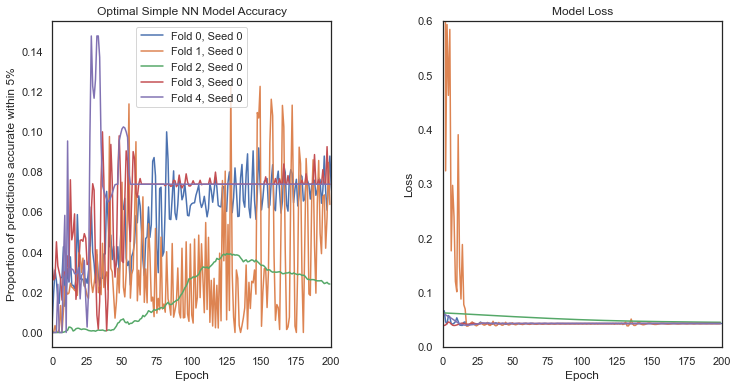

In [98]:
#Compare the best models performance across folds

#Define plot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Accuracy plot
axs[0].plot(history00.history["val_accuracy_within_5_percent"], label="Fold 0, Seed 0")
axs[0].plot(history10.history["val_accuracy_within_5_percent"], label="Fold 1, Seed 0")
axs[0].plot(history20.history["val_accuracy_within_5_percent"], label="Fold 2, Seed 0")
axs[0].plot(history30.history["val_accuracy_within_5_percent"], label="Fold 3, Seed 0")
axs[0].plot(history40.history["val_accuracy_within_5_percent"], label="Fold 4, Seed 0")
axs[0].set_title("Optimal Simple NN Model Accuracy")
axs[0].set_ylabel("Proportion of predictions accurate within 5%")
axs[0].set_xlabel("Epoch")
axs[0].set_xlim(0, 200)
axs[0].legend()

#Loss subplot
axs[1].plot(history00.history["val_loss"], label="Fold 0, Seed 0")
axs[1].plot(history10.history["val_loss"], label="Fold 1, Seed 0")
axs[1].plot(history20.history["val_loss"], label="Fold 2, Seed 0")
axs[1].plot(history30.history["val_loss"], label="Fold 3, Seed 0")
axs[1].plot(history40.history["val_loss"], label="Fold 4, Seed 0")
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xlim(0, 200)
axs[1].set_ylim(0, 0.6)

#Adjust spacing
plt.subplots_adjust(wspace=0.4)

#Display plots
plt.show()

# Hyperparameter tuning for a CNN

Previous manual analysis showed more promising outcomes for CNN than basic feedforwards neural networks. The following work performs hyperparameter tuning on these neural networks to determine the optimal parameters.

In [105]:
#Adapt previous function to tune hyperparameters for a CNN

#Define function for hyperparameter tuning
def build_model(hp):
    #Start model
    model = keras.Sequential()
    #Input layer
    inp = tf.keras.layers.Input(shape=(X_train.shape[1],))
    #Convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)
    #Reshape input data
    x = tf.keras.layers.Reshape((X_train.shape[1], 1))(inp)
    for i in range(num_conv_layers):
        #Define number of filters to test 
        hp_filters = hp.Int('filters_{i}'.format(i=i), min_value=4, max_value=128, step=8)
        #Define kernel size to test for each convolutional layer
        hp_kernel_size = hp.Int('kernel_size_{i}'.format(i=i), min_value=2, max_value=5, step=1)
        #Define activation function to test 
        hp_conv_activation = hp.Choice('conv_activation_{i}'.format(i=i), values=['relu', 'selu', 'elu', 'swish'])
        #Define pool sizes to test
        hp_pool_size = hp.Int('pool_size_{i}'.format(i=i), min_value=1, max_value=5, step=1)
        #Add the convolutional layer
        x = tf.keras.layers.Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation=hp_conv_activation)(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=hp_pool_size)(x)
    #Test models with up to 6 dense layers
    num_dense = hp.Int('num_dense', min_value=1, max_value=6, step=1)
    #Iterate through each layer
    for i in range(num_dense):
        #Define units to test
        hp_units = hp.Int('units_{i}'.format(i=i), min_value=8, max_value=4096, step=128)
        #Define dropout values to test
        hp_drop_rate = hp.Choice('dp_{i}'.format(i=i), values=[0.0, 0.1, 0.15, 0.2, 0.25 ,0.3,
                                                               0.35,0.4, 0.5, 0.6, 0.7])
        #Define activation functions to test
        hp_activation = hp.Choice('dense_activation_{i}'.format(i=i),values=['relu', 'selu',
                                                                             'elu', 'swish'])
        #Define the way data flows through hidden layers
        x = tf.keras.layers.Dense(units=hp_units, activation=hp_activation)(x)
        x = tf.keras.layers.Dropout(hp_drop_rate)(x)
        x = tf.keras.layers.BatchNormalization()(x)
    #Output layer
    outputs = tf.keras.layers.Dense(1, kernel_initializer='normal', activation='linear')(x)
    #Create the model with the defined input and outputs
    model = tf.keras.models.Model(inp, outputs)
    #Compile the model
    model.compile(
      optimizer=keras.optimizers.Adam(
        #Define learning rates to test
        hp.Choice('learning_rate', values = [1e-3, 1e-4, 1e-5, 0.0])),
      loss='mean_absolute_error',
      metrics=['mean_absolute_error', accuracy_within_5_percent])
    return model

In [106]:
#Use same function as before here

#Defining parameters
feats = np.arange(0,X.shape[1],1)
inp_size = int(np.ceil(1* len(feats)))
n_split = 5
n_repeats = 1
bests_cnn=[]
seeds = [0, 1]
n_round = len(seeds)
shuffle_split_size = 0.2

for seed in seeds:
    split_cols = np.random.choice(feats, inp_size, replace=False)
    #Use k fold cross validation to split data into train and test
    for n, (train, test) in enumerate(KFold(n_splits = n_split, random_state=0,
                                       shuffle = True).split(X, Y)):
        st = time_module.time()
        #Define tuning objectives and params
        tuner = kt.tuners.BayesianOptimization(build_model,
                     kt.Objective('val_accuracy_within_5_percent', direction="max"),
                     max_trials = 150, overwrite=True)
        start_time = time_module.time()
        X_train = X[train][:, split_cols]
        X_val = X[test][:, split_cols]
        Y_train, Y_val = Y[train], Y[test]
        #Early stop if the validation accuracy does not improve for 20 epochs
        callbacks=[EarlyStopping(monitor='val_accuracy_within_5_percent', mode='max', patience=20)]
        start_time = time_module.time()
        #Perform hyperparameter search using train and val data
        tuner.search(X_train, Y_train,validation_data=(X_val, Y_val),
                            epochs = 500, batch_size = 128,
                            verbose = 0, callbacks = callbacks)
        #Create method to recall best hyperparameters identified during the trial
        n_top = 5
        best_hps = tuner.get_best_hyperparameters(n_top)
        end_time = time_module.time()
        bests_cnn.append(best_hps)
        for i in range(n_top):
            print(best_hps[i].values)
        #Print statements to monitor the progress of the tests
        print('Seed', seed, 'Fold', n, 'Time elapsed:', "{:.2f}".format((end_time-start_time)/60), 'minutes')
        #Delete old tuner for memory conservation
        del tuner

INFO:tensorflow:Oracle triggered exit
{'num_conv_layers': 2, 'filters_0': 44, 'kernel_size_0': 4, 'conv_activation_0': 'swish', 'pool_size_0': 4, 'num_dense': 4, 'units_0': 1416, 'dp_0': 0.0, 'dense_activation_0': 'swish', 'learning_rate': 1e-05, 'filters_1': 12, 'kernel_size_1': 2, 'conv_activation_1': 'swish', 'pool_size_1': 3, 'units_1': 3080, 'dp_1': 0.4, 'dense_activation_1': 'swish', 'units_2': 1800, 'dp_2': 0.6, 'dense_activation_2': 'elu', 'units_3': 3976, 'dp_3': 0.1, 'dense_activation_3': 'elu', 'units_4': 1800, 'dp_4': 0.15, 'dense_activation_4': 'elu', 'filters_2': 100, 'kernel_size_2': 5, 'conv_activation_2': 'elu', 'pool_size_2': 4, 'units_5': 2952, 'dp_5': 0.5, 'dense_activation_5': 'swish'}
{'num_conv_layers': 2, 'filters_0': 68, 'kernel_size_0': 2, 'conv_activation_0': 'swish', 'pool_size_0': 4, 'num_dense': 1, 'units_0': 2824, 'dp_0': 0.2, 'dense_activation_0': 'selu', 'learning_rate': 0.0001, 'filters_1': 4, 'kernel_size_1': 4, 'conv_activation_1': 'selu', 'pool_size

INFO:tensorflow:Oracle triggered exit
{'num_conv_layers': 2, 'filters_0': 52, 'kernel_size_0': 2, 'conv_activation_0': 'swish', 'pool_size_0': 5, 'num_dense': 2, 'units_0': 3464, 'dp_0': 0.7, 'dense_activation_0': 'swish', 'learning_rate': 0.001, 'filters_1': 4, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'pool_size_1': 1, 'units_1': 8, 'dp_1': 0.0, 'dense_activation_1': 'relu'}
{'num_conv_layers': 3, 'filters_0': 52, 'kernel_size_0': 4, 'conv_activation_0': 'elu', 'pool_size_0': 4, 'num_dense': 3, 'units_0': 776, 'dp_0': 0.0, 'dense_activation_0': 'selu', 'learning_rate': 0.001, 'filters_1': 108, 'kernel_size_1': 2, 'conv_activation_1': 'elu', 'pool_size_1': 5, 'units_1': 8, 'dp_1': 0.2, 'dense_activation_1': 'relu', 'filters_2': 4, 'kernel_size_2': 2, 'conv_activation_2': 'relu', 'pool_size_2': 2, 'units_2': 1160, 'dp_2': 0.2, 'dense_activation_2': 'relu', 'units_3': 1800, 'dp_3': 0.15, 'dense_activation_3': 'swish', 'units_4': 1800, 'dp_4': 0.2, 'dense_activation_4': 'relu', 'u

INFO:tensorflow:Oracle triggered exit
{'num_conv_layers': 1, 'filters_0': 84, 'kernel_size_0': 3, 'conv_activation_0': 'swish', 'pool_size_0': 1, 'num_dense': 6, 'units_0': 2824, 'dp_0': 0.5, 'dense_activation_0': 'selu', 'learning_rate': 0.001, 'filters_1': 28, 'kernel_size_1': 4, 'conv_activation_1': 'selu', 'pool_size_1': 2, 'filters_2': 60, 'kernel_size_2': 2, 'conv_activation_2': 'selu', 'pool_size_2': 2, 'units_1': 264, 'dp_1': 0.6, 'dense_activation_1': 'swish', 'units_2': 1288, 'dp_2': 0.35, 'dense_activation_2': 'elu', 'units_3': 2056, 'dp_3': 0.15, 'dense_activation_3': 'swish', 'units_4': 2696, 'dp_4': 0.0, 'dense_activation_4': 'selu', 'units_5': 8, 'dp_5': 0.7, 'dense_activation_5': 'swish'}
{'num_conv_layers': 2, 'filters_0': 100, 'kernel_size_0': 2, 'conv_activation_0': 'elu', 'pool_size_0': 3, 'num_dense': 5, 'units_0': 776, 'dp_0': 0.0, 'dense_activation_0': 'swish', 'learning_rate': 0.0001, 'filters_1': 60, 'kernel_size_1': 4, 'conv_activation_1': 'selu', 'pool_size_1

INFO:tensorflow:Oracle triggered exit
{'num_conv_layers': 1, 'filters_0': 44, 'kernel_size_0': 5, 'conv_activation_0': 'selu', 'pool_size_0': 4, 'num_dense': 5, 'units_0': 2568, 'dp_0': 0.5, 'dense_activation_0': 'selu', 'learning_rate': 0.001, 'units_1': 1800, 'dp_1': 0.25, 'dense_activation_1': 'elu', 'units_2': 1800, 'dp_2': 0.25, 'dense_activation_2': 'selu', 'units_3': 8, 'dp_3': 0.25, 'dense_activation_3': 'swish', 'units_4': 1416, 'dp_4': 0.3, 'dense_activation_4': 'elu', 'units_5': 136, 'dp_5': 0.25, 'dense_activation_5': 'elu', 'filters_1': 52, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'pool_size_1': 1, 'filters_2': 52, 'kernel_size_2': 5, 'conv_activation_2': 'relu', 'pool_size_2': 1}
{'num_conv_layers': 1, 'filters_0': 108, 'kernel_size_0': 3, 'conv_activation_0': 'swish', 'pool_size_0': 3, 'num_dense': 6, 'units_0': 3976, 'dp_0': 0.4, 'dense_activation_0': 'relu', 'learning_rate': 0.001, 'units_1': 8, 'dp_1': 0.0, 'dense_activation_1': 'relu', 'units_2': 8, 'dp_2': 0

In [107]:
#Print outcome from fold 0 seed 0
print(bests_cnn[0][0].values)

{'num_conv_layers': 2, 'filters_0': 44, 'kernel_size_0': 4, 'conv_activation_0': 'swish', 'pool_size_0': 4, 'num_dense': 4, 'units_0': 1416, 'dp_0': 0.0, 'dense_activation_0': 'swish', 'learning_rate': 1e-05, 'filters_1': 12, 'kernel_size_1': 2, 'conv_activation_1': 'swish', 'pool_size_1': 3, 'units_1': 3080, 'dp_1': 0.4, 'dense_activation_1': 'swish', 'units_2': 1800, 'dp_2': 0.6, 'dense_activation_2': 'elu', 'units_3': 3976, 'dp_3': 0.1, 'dense_activation_3': 'elu', 'units_4': 1800, 'dp_4': 0.15, 'dense_activation_4': 'elu', 'filters_2': 100, 'kernel_size_2': 5, 'conv_activation_2': 'elu', 'pool_size_2': 4, 'units_5': 2952, 'dp_5': 0.5, 'dense_activation_5': 'swish'}


In [108]:
#Print outcome from fold 1 seed 0
print(bests_cnn[1][0].values)

{'num_conv_layers': 2, 'filters_0': 68, 'kernel_size_0': 3, 'conv_activation_0': 'selu', 'pool_size_0': 5, 'num_dense': 2, 'units_0': 392, 'dp_0': 0.2, 'dense_activation_0': 'swish', 'learning_rate': 0.001, 'filters_1': 84, 'kernel_size_1': 4, 'conv_activation_1': 'relu', 'pool_size_1': 3, 'filters_2': 12, 'kernel_size_2': 2, 'conv_activation_2': 'swish', 'pool_size_2': 4, 'units_1': 392, 'dp_1': 0.5, 'dense_activation_1': 'relu', 'units_2': 3592, 'dp_2': 0.35, 'dense_activation_2': 'selu', 'units_3': 1672, 'dp_3': 0.25, 'dense_activation_3': 'relu', 'units_4': 3592, 'dp_4': 0.6, 'dense_activation_4': 'relu', 'units_5': 1416, 'dp_5': 0.2, 'dense_activation_5': 'selu'}


In [109]:
#Print outcome from fold 2 seed 0
print(bests_cnn[2][0].values)

{'num_conv_layers': 3, 'filters_0': 116, 'kernel_size_0': 3, 'conv_activation_0': 'selu', 'pool_size_0': 4, 'num_dense': 5, 'units_0': 2824, 'dp_0': 0.0, 'dense_activation_0': 'swish', 'learning_rate': 1e-05, 'filters_1': 60, 'kernel_size_1': 2, 'conv_activation_1': 'selu', 'pool_size_1': 4, 'filters_2': 4, 'kernel_size_2': 2, 'conv_activation_2': 'relu', 'pool_size_2': 3, 'units_1': 8, 'dp_1': 0.15, 'dense_activation_1': 'relu', 'units_2': 1288, 'dp_2': 0.4, 'dense_activation_2': 'elu', 'units_3': 3720, 'dp_3': 0.25, 'dense_activation_3': 'elu', 'units_4': 1160, 'dp_4': 0.7, 'dense_activation_4': 'selu', 'units_5': 3208, 'dp_5': 0.35, 'dense_activation_5': 'relu'}


In [110]:
#Print outcome from fold 3 seed 0
print(bests_cnn[3][0].values)

{'num_conv_layers': 2, 'filters_0': 52, 'kernel_size_0': 2, 'conv_activation_0': 'swish', 'pool_size_0': 5, 'num_dense': 2, 'units_0': 3464, 'dp_0': 0.7, 'dense_activation_0': 'swish', 'learning_rate': 0.001, 'filters_1': 4, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'pool_size_1': 1, 'units_1': 8, 'dp_1': 0.0, 'dense_activation_1': 'relu'}


In [111]:
#Print outcome from fold 4 seed 0
print(bests_cnn[4][0].values)

{'num_conv_layers': 1, 'filters_0': 68, 'kernel_size_0': 3, 'conv_activation_0': 'elu', 'pool_size_0': 3, 'num_dense': 4, 'units_0': 3976, 'dp_0': 0.15, 'dense_activation_0': 'swish', 'learning_rate': 1e-05, 'filters_1': 60, 'kernel_size_1': 3, 'conv_activation_1': 'elu', 'pool_size_1': 5, 'filters_2': 52, 'kernel_size_2': 5, 'conv_activation_2': 'swish', 'pool_size_2': 3, 'units_1': 3080, 'dp_1': 0.6, 'dense_activation_1': 'swish', 'units_2': 3720, 'dp_2': 0.1, 'dense_activation_2': 'swish', 'units_3': 904, 'dp_3': 0.1, 'dense_activation_3': 'swish', 'units_4': 2696, 'dp_4': 0.4, 'dense_activation_4': 'selu', 'units_5': 2568, 'dp_5': 0.2, 'dense_activation_5': 'relu'}


In [112]:
#Look at the top models in more detail to see how they perform
#Best outcome for fold 0, seed 0  

#Start new NN
model = keras.Sequential()

#Add layers per best hyperparam tuning outcomes
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Convolutional layer
model.add(Conv1D(filters=44, kernel_size=4, activation='swish'))
model.add(MaxPooling1D(pool_size=4))

model.add(Dense(1416, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.0))

model.add(Conv1D(filters=12, kernel_size=2, activation='swish'))
model.add(MaxPooling1D(pool_size=3))

model.add(Dense(3080, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.4))

model.add(Dense(1800, kernel_initializer='normal', activation='elu'))
model.add(Dropout(0.6))

model.add(Dense(3976, kernel_initializer='normal', activation='elu'))
model.add(Dropout(0.1))

model.add(Dense(1800, kernel_initializer='normal', activation='elu'))
model.add(Dropout(0.15))

model.add(Conv1D(filters=100, kernel_size=5, activation='elu'))
model.add(MaxPooling1D(pool_size=4))

model.add(Dense(2952, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Define optimizer
optimizer = Adam(learning_rate=1e-5)

#Compile the network
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'CNN-1ST Fold0 Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
cnnhistory00 = model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.2, callbacks = callbacks_list)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 300, 1)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 297, 44)           220       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 74, 44)           0         
 1D)                                                             
                                                                 
 dense_5 (Dense)             (None, 74, 1416)          63720     
                                                                 
 dropout_4 (Dropout)         (None, 74, 1416)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 73, 12)            33996     
                                                      

1/1 [==============================] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.0883 - accuracy_within_5_percent: 0.0095
Epoch 12: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0883 - mean_absolute_error: 0.0883 - accuracy_within_5_percent: 0.0095 - val_loss: 0.0492 - val_mean_absolute_error: 0.0492 - val_accuracy_within_5_percent: 0.0364
Epoch 13/500
1/1 [==============================] - ETA: 0s - loss: 0.0838 - mean_absolute_error: 0.0838 - accuracy_within_5_percent: 0.0190
Epoch 13: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0838 - mean_absolute_error: 0.0838 - accuracy_within_5_percent: 0.0190 - val_loss: 0.0538 - val_mean_absolute_error: 0.0538 - val_accuracy_within_5_percent: 0.0636
Epoch 14/500
1/1 [==============================] - ETA: 0s - loss: 0.0855 - mean_absolute_error: 0.0855 - accuracy_within_5_percent: 0.0119
Epoc

Epoch 31/500
1/1 [==============================] - ETA: 0s - loss: 0.0576 - mean_absolute_error: 0.0576 - accuracy_within_5_percent: 0.0286
Epoch 31: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0576 - mean_absolute_error: 0.0576 - accuracy_within_5_percent: 0.0286 - val_loss: 0.0417 - val_mean_absolute_error: 0.0417 - val_accuracy_within_5_percent: 0.0182
Epoch 32/500
1/1 [==============================] - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.0589 - accuracy_within_5_percent: 0.0238
Epoch 32: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0589 - mean_absolute_error: 0.0589 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0408 - val_mean_absolute_error: 0.0408 - val_accuracy_within_5_percent: 0.0273
Epoch 33/500
1/1 [==============================] - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.0551 - accuracy_within_5_percent

Epoch 50/500
1/1 [==============================] - ETA: 0s - loss: 0.0432 - mean_absolute_error: 0.0432 - accuracy_within_5_percent: 0.0214
Epoch 50: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0432 - mean_absolute_error: 0.0432 - accuracy_within_5_percent: 0.0214 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 51/500
1/1 [==============================] - ETA: 0s - loss: 0.0422 - mean_absolute_error: 0.0422 - accuracy_within_5_percent: 0.0357
Epoch 51: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0422 - mean_absolute_error: 0.0422 - accuracy_within_5_percent: 0.0357 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366 - val_accuracy_within_5_percent: 0.0182
Epoch 52/500
1/1 [==============================] - ETA: 0s - loss: 0.0436 - mean_absolute_error: 0.0436 - accuracy_within_5_per

Epoch 69/500
1/1 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375 - accuracy_within_5_percent: 0.0310
Epoch 69: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0375 - mean_absolute_error: 0.0375 - accuracy_within_5_percent: 0.0310 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355 - val_accuracy_within_5_percent: 0.0182
Epoch 70/500
1/1 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380 - accuracy_within_5_percent: 0.0286
Epoch 70: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0380 - mean_absolute_error: 0.0380 - accuracy_within_5_percent: 0.0286 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355 - val_accuracy_within_5_percent: 0.0091
Epoch 71/500
1/1 [==============================] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393 - accuracy_within_5_percent

Epoch 88/500
1/1 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.0373 - accuracy_within_5_percent: 0.0238
Epoch 88: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0373 - mean_absolute_error: 0.0373 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351 - val_accuracy_within_5_percent: 0.0182
Epoch 89/500
1/1 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363 - accuracy_within_5_percent: 0.0429
Epoch 89: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0363 - mean_absolute_error: 0.0363 - accuracy_within_5_percent: 0.0429 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351 - val_accuracy_within_5_percent: 0.0182
Epoch 90/500
1/1 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356 - accuracy_within_5_percent

Epoch 107/500
1/1 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.0351 - accuracy_within_5_percent: 0.0310
Epoch 107: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0351 - mean_absolute_error: 0.0351 - accuracy_within_5_percent: 0.0310 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352 - val_accuracy_within_5_percent: 0.0273
Epoch 108/500
1/1 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344 - accuracy_within_5_percent: 0.0357
Epoch 108: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 2s 2s/step - loss: 0.0344 - mean_absolute_error: 0.0344 - accuracy_within_5_percent: 0.0357 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352 - val_accuracy_within_5_percent: 0.0182
Epoch 109/500
1/1 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.0350 - accuracy_within_5_pe

Epoch 126/500
1/1 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334 - accuracy_within_5_percent: 0.0476
Epoch 126: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0334 - mean_absolute_error: 0.0334 - accuracy_within_5_percent: 0.0476 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352 - val_accuracy_within_5_percent: 0.0273
Epoch 127/500
1/1 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322 - accuracy_within_5_percent: 0.0381
Epoch 127: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0322 - mean_absolute_error: 0.0322 - accuracy_within_5_percent: 0.0381 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352 - val_accuracy_within_5_percent: 0.0091
Epoch 128/500
1/1 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343 - accuracy_within_5_pe

Epoch 145/500
1/1 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.0343 - accuracy_within_5_percent: 0.0262
Epoch 145: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0343 - mean_absolute_error: 0.0343 - accuracy_within_5_percent: 0.0262 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353 - val_accuracy_within_5_percent: 0.0364
Epoch 146/500
1/1 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336 - accuracy_within_5_percent: 0.0548
Epoch 146: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 2s 2s/step - loss: 0.0336 - mean_absolute_error: 0.0336 - accuracy_within_5_percent: 0.0548 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353 - val_accuracy_within_5_percent: 0.0364
Epoch 147/500
1/1 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320 - accuracy_within_5_pe

Epoch 164/500
1/1 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330 - accuracy_within_5_percent: 0.0357
Epoch 164: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0330 - mean_absolute_error: 0.0330 - accuracy_within_5_percent: 0.0357 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352 - val_accuracy_within_5_percent: 0.0273
Epoch 165/500
1/1 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.0333 - accuracy_within_5_percent: 0.0310
Epoch 165: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0333 - mean_absolute_error: 0.0333 - accuracy_within_5_percent: 0.0310 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352 - val_accuracy_within_5_percent: 0.0273
Epoch 166/500
1/1 [==============================] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.0318 - accuracy_within_5_pe

Epoch 183/500
1/1 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320 - accuracy_within_5_percent: 0.0310
Epoch 183: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0320 - mean_absolute_error: 0.0320 - accuracy_within_5_percent: 0.0310 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352 - val_accuracy_within_5_percent: 0.0273
Epoch 184/500
1/1 [==============================] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329 - accuracy_within_5_percent: 0.0357
Epoch 184: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0329 - mean_absolute_error: 0.0329 - accuracy_within_5_percent: 0.0357 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352 - val_accuracy_within_5_percent: 0.0273
Epoch 185/500
1/1 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320 - accuracy_within_5_pe

Epoch 202/500
1/1 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320 - accuracy_within_5_percent: 0.0143
Epoch 202: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0320 - mean_absolute_error: 0.0320 - accuracy_within_5_percent: 0.0143 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355 - val_accuracy_within_5_percent: 0.0182
Epoch 203/500
1/1 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.0298 - accuracy_within_5_percent: 0.0524
Epoch 203: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0298 - mean_absolute_error: 0.0298 - accuracy_within_5_percent: 0.0524 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356 - val_accuracy_within_5_percent: 0.0091
Epoch 204/500
1/1 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303 - accuracy_within_5_pe

Epoch 221/500
1/1 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.0320 - accuracy_within_5_percent: 0.0405
Epoch 221: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0320 - mean_absolute_error: 0.0320 - accuracy_within_5_percent: 0.0405 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353 - val_accuracy_within_5_percent: 0.0364
Epoch 222/500
1/1 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303 - accuracy_within_5_percent: 0.0476
Epoch 222: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0303 - mean_absolute_error: 0.0303 - accuracy_within_5_percent: 0.0476 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353 - val_accuracy_within_5_percent: 0.0364
Epoch 223/500
1/1 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324 - accuracy_within_5_pe

Epoch 240/500
1/1 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.0296 - accuracy_within_5_percent: 0.0548
Epoch 240: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0296 - mean_absolute_error: 0.0296 - accuracy_within_5_percent: 0.0548 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354 - val_accuracy_within_5_percent: 0.0091
Epoch 241/500
1/1 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0309 - accuracy_within_5_percent: 0.0452
Epoch 241: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0309 - mean_absolute_error: 0.0309 - accuracy_within_5_percent: 0.0452 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353 - val_accuracy_within_5_percent: 0.0273
Epoch 242/500
1/1 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300 - accuracy_within_5_pe

Epoch 259/500
1/1 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.0310 - accuracy_within_5_percent: 0.0429
Epoch 259: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0310 - mean_absolute_error: 0.0310 - accuracy_within_5_percent: 0.0429 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358 - val_accuracy_within_5_percent: 0.0364
Epoch 260/500
1/1 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300 - accuracy_within_5_percent: 0.0333
Epoch 260: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0300 - mean_absolute_error: 0.0300 - accuracy_within_5_percent: 0.0333 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356 - val_accuracy_within_5_percent: 0.0182
Epoch 261/500
1/1 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0304 - accuracy_within_5_pe

Epoch 278/500
1/1 [==============================] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.0294 - accuracy_within_5_percent: 0.0310
Epoch 278: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0294 - mean_absolute_error: 0.0294 - accuracy_within_5_percent: 0.0310 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358 - val_accuracy_within_5_percent: 0.0182
Epoch 279/500
1/1 [==============================] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0312 - accuracy_within_5_percent: 0.0381
Epoch 279: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0312 - mean_absolute_error: 0.0312 - accuracy_within_5_percent: 0.0381 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357 - val_accuracy_within_5_percent: 0.0182
Epoch 280/500
1/1 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.0307 - accuracy_within_5_pe

Epoch 297/500
1/1 [==============================] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.0290 - accuracy_within_5_percent: 0.0476
Epoch 297: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0290 - mean_absolute_error: 0.0290 - accuracy_within_5_percent: 0.0476 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355 - val_accuracy_within_5_percent: 0.0273
Epoch 298/500
1/1 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300 - accuracy_within_5_percent: 0.0643
Epoch 298: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0300 - mean_absolute_error: 0.0300 - accuracy_within_5_percent: 0.0643 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356 - val_accuracy_within_5_percent: 0.0091
Epoch 299/500
1/1 [==============================] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.0294 - accuracy_within_5_pe

Epoch 316/500
1/1 [==============================] - ETA: 0s - loss: 0.0284 - mean_absolute_error: 0.0284 - accuracy_within_5_percent: 0.0476
Epoch 316: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0284 - mean_absolute_error: 0.0284 - accuracy_within_5_percent: 0.0476 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356 - val_accuracy_within_5_percent: 0.0182
Epoch 317/500
1/1 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.0287 - accuracy_within_5_percent: 0.0381
Epoch 317: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0287 - mean_absolute_error: 0.0287 - accuracy_within_5_percent: 0.0381 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 318/500
1/1 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303 - accuracy_within_

Epoch 335/500
1/1 [==============================] - ETA: 0s - loss: 0.0290 - mean_absolute_error: 0.0290 - accuracy_within_5_percent: 0.0429
Epoch 335: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0290 - mean_absolute_error: 0.0290 - accuracy_within_5_percent: 0.0429 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359 - val_accuracy_within_5_percent: 0.0091
Epoch 336/500
1/1 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.0287 - accuracy_within_5_percent: 0.0405
Epoch 336: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0287 - mean_absolute_error: 0.0287 - accuracy_within_5_percent: 0.0405 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358 - val_accuracy_within_5_percent: 0.0091
Epoch 337/500
1/1 [==============================] - ETA: 0s - loss: 0.0283 - mean_absolute_error: 0.0283 - accuracy_within_5_pe

Epoch 354/500
1/1 [==============================] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.0275 - accuracy_within_5_percent: 0.0429
Epoch 354: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0275 - mean_absolute_error: 0.0275 - accuracy_within_5_percent: 0.0429 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357 - val_accuracy_within_5_percent: 0.0273
Epoch 355/500
1/1 [==============================] - ETA: 0s - loss: 0.0283 - mean_absolute_error: 0.0283 - accuracy_within_5_percent: 0.0357
Epoch 355: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0283 - mean_absolute_error: 0.0283 - accuracy_within_5_percent: 0.0357 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356 - val_accuracy_within_5_percent: 0.0273
Epoch 356/500
1/1 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.0295 - accuracy_within_5_pe

Epoch 373/500
1/1 [==============================] - ETA: 0s - loss: 0.0283 - mean_absolute_error: 0.0283 - accuracy_within_5_percent: 0.0452
Epoch 373: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0283 - mean_absolute_error: 0.0283 - accuracy_within_5_percent: 0.0452 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359 - val_accuracy_within_5_percent: 0.0182
Epoch 374/500
1/1 [==============================] - ETA: 0s - loss: 0.0284 - mean_absolute_error: 0.0284 - accuracy_within_5_percent: 0.0429
Epoch 374: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0284 - mean_absolute_error: 0.0284 - accuracy_within_5_percent: 0.0429 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362 - val_accuracy_within_5_percent: 0.0273
Epoch 375/500
1/1 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.0286 - accuracy_within_5_pe

Epoch 392/500
1/1 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.0296 - accuracy_within_5_percent: 0.0429
Epoch 392: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0296 - mean_absolute_error: 0.0296 - accuracy_within_5_percent: 0.0429 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364 - val_accuracy_within_5_percent: 0.0273
Epoch 393/500
1/1 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0280 - accuracy_within_5_percent: 0.0524
Epoch 393: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0280 - mean_absolute_error: 0.0280 - accuracy_within_5_percent: 0.0524 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363 - val_accuracy_within_5_percent: 0.0273
Epoch 394/500
1/1 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.0281 - accuracy_within_5_pe

Epoch 411/500
1/1 [==============================] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.0275 - accuracy_within_5_percent: 0.0405
Epoch 411: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0275 - mean_absolute_error: 0.0275 - accuracy_within_5_percent: 0.0405 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357 - val_accuracy_within_5_percent: 0.0182
Epoch 412/500
1/1 [==============================] - ETA: 0s - loss: 0.0285 - mean_absolute_error: 0.0285 - accuracy_within_5_percent: 0.0405
Epoch 412: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0285 - mean_absolute_error: 0.0285 - accuracy_within_5_percent: 0.0405 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357 - val_accuracy_within_5_percent: 0.0182
Epoch 413/500
1/1 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272 - accuracy_within_5_pe

Epoch 430/500
1/1 [==============================] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.0274 - accuracy_within_5_percent: 0.0405
Epoch 430: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0274 - mean_absolute_error: 0.0274 - accuracy_within_5_percent: 0.0405 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357 - val_accuracy_within_5_percent: 0.0182
Epoch 431/500
1/1 [==============================] - ETA: 0s - loss: 0.0283 - mean_absolute_error: 0.0283 - accuracy_within_5_percent: 0.0452
Epoch 431: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0283 - mean_absolute_error: 0.0283 - accuracy_within_5_percent: 0.0452 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357 - val_accuracy_within_5_percent: 0.0273
Epoch 432/500
1/1 [==============================] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.0274 - accuracy_within_5_pe

Epoch 449/500
1/1 [==============================] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.0275 - accuracy_within_5_percent: 0.0333
Epoch 449: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0275 - mean_absolute_error: 0.0275 - accuracy_within_5_percent: 0.0333 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359 - val_accuracy_within_5_percent: 0.0455
Epoch 450/500
1/1 [==============================] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.0274 - accuracy_within_5_percent: 0.0619
Epoch 450: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0274 - mean_absolute_error: 0.0274 - accuracy_within_5_percent: 0.0619 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360 - val_accuracy_within_5_percent: 0.0273
Epoch 451/500
1/1 [==============================] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.0273 - accuracy_within_5_pe

Epoch 468/500
1/1 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272 - accuracy_within_5_percent: 0.0595
Epoch 468: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0272 - mean_absolute_error: 0.0272 - accuracy_within_5_percent: 0.0595 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357 - val_accuracy_within_5_percent: 0.0273
Epoch 469/500
1/1 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.0268 - accuracy_within_5_percent: 0.0214
Epoch 469: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0268 - mean_absolute_error: 0.0268 - accuracy_within_5_percent: 0.0214 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358 - val_accuracy_within_5_percent: 0.0182
Epoch 470/500
1/1 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.0268 - accuracy_within_5_pe

Epoch 487/500
1/1 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.0271 - accuracy_within_5_percent: 0.0619
Epoch 487: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0271 - mean_absolute_error: 0.0271 - accuracy_within_5_percent: 0.0619 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357 - val_accuracy_within_5_percent: 0.0273
Epoch 488/500
1/1 [==============================] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.0274 - accuracy_within_5_percent: 0.0524
Epoch 488: val_accuracy_within_5_percent did not improve from 0.09091
1/1 [==============================] - 1s 1s/step - loss: 0.0274 - mean_absolute_error: 0.0274 - accuracy_within_5_percent: 0.0524 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357 - val_accuracy_within_5_percent: 0.0273
Epoch 489/500
1/1 [==============================] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.0276 - accuracy_within_5_pe

In [113]:
#Look at the top models in more detail to see how they perform
#Best outcome for fold 1, seed 0 

#Start new NN
model = keras.Sequential()

#Add layers per best hyperparam tuning outcomes
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Convolutional layer
model.add(Conv1D(filters=68, kernel_size=3, activation='selu'))
model.add(MaxPooling1D(pool_size=5))

model.add(Dense(392, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.2))

model.add(Conv1D(filters=84, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Conv1D(filters=12, kernel_size=2, activation='swish'))
model.add(MaxPooling1D(pool_size=4))

model.add(Dense(392, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3592, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.35))

model.add(Dense(1692, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(3592, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(1416, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.2))

#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Define optimizer
optimizer = Adam(learning_rate=0.001)

#Compile the network
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'CNN-1ST Fold1 Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
cnnhistory10 = model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.2, callbacks = callbacks_list)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 300, 1)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 298, 68)           272       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 59, 68)           0         
 1D)                                                             
                                                                 
 dense_12 (Dense)            (None, 59, 392)           27048     
                                                                 
 dropout_10 (Dropout)        (None, 59, 392)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 56, 84)            131796    
                                                      

Epoch 12/500
1/1 [==============================] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.0681 - accuracy_within_5_percent: 0.0149
Epoch 12: val_accuracy_within_5_percent improved from 0.00000 to 0.01136, saving model to CNN-1ST Fold1 Weights-012--0.05325.hdf5
1/1 [==============================] - 1s 748ms/step - loss: 0.0681 - mean_absolute_error: 0.0681 - accuracy_within_5_percent: 0.0149 - val_loss: 0.0532 - val_mean_absolute_error: 0.0532 - val_accuracy_within_5_percent: 0.0114
Epoch 13/500
1/1 [==============================] - ETA: 0s - loss: 0.1352 - mean_absolute_error: 0.1352 - accuracy_within_5_percent: 0.0060
Epoch 13: val_accuracy_within_5_percent did not improve from 0.01136
1/1 [==============================] - 0s 395ms/step - loss: 0.1352 - mean_absolute_error: 0.1352 - accuracy_within_5_percent: 0.0060 - val_loss: 0.0457 - val_mean_absolute_error: 0.0457 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 14/500
1/1 [==============================] - ETA: 0s -

1/1 [==============================] - 0s 374ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - accuracy_within_5_percent: 0.0208 - val_loss: 0.0720 - val_mean_absolute_error: 0.0720 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 31/500
1/1 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355 - accuracy_within_5_percent: 0.0208
Epoch 31: val_accuracy_within_5_percent did not improve from 0.01136
1/1 [==============================] - 0s 378ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - accuracy_within_5_percent: 0.0208 - val_loss: 0.0719 - val_mean_absolute_error: 0.0719 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 32/500
1/1 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340 - accuracy_within_5_percent: 0.0476
Epoch 32: val_accuracy_within_5_percent did not improve from 0.01136
1/1 [==============================] - 0s 398ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - accuracy_within_5_

Epoch 49/500
1/1 [==============================] - ETA: 0s - loss: 0.0277 - mean_absolute_error: 0.0277 - accuracy_within_5_percent: 0.0387
Epoch 49: val_accuracy_within_5_percent did not improve from 0.13636
1/1 [==============================] - 0s 363ms/step - loss: 0.0277 - mean_absolute_error: 0.0277 - accuracy_within_5_percent: 0.0387 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 50/500
1/1 [==============================] - ETA: 0s - loss: 0.0277 - mean_absolute_error: 0.0277 - accuracy_within_5_percent: 0.0298
Epoch 50: val_accuracy_within_5_percent did not improve from 0.13636
1/1 [==============================] - 0s 362ms/step - loss: 0.0277 - mean_absolute_error: 0.0277 - accuracy_within_5_percent: 0.0298 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0909
Epoch 51/500
1/1 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within

Epoch 68/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0595
Epoch 68: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 378ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0595 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 69/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.0744
Epoch 69: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 376ms/step - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.0744 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0455
Epoch 70/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within

Epoch 87/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0952
Epoch 87: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 363ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0952 - val_loss: 0.0379 - val_mean_absolute_error: 0.0379 - val_accuracy_within_5_percent: 0.0909
Epoch 88/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1280
Epoch 88: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 370ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1280 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0455
Epoch 89/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_p

Epoch 106/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.1101
Epoch 106: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 377ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.1101 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 107/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0655
Epoch 107: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 370ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0655 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0455
Epoch 108/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_w

Epoch 125/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0536
Epoch 125: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 367ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0536 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 126/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0655
Epoch 126: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 377ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0655 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0909
Epoch 127/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_w

Epoch 144/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1131
Epoch 144: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 364ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1131 - val_loss: 0.0380 - val_mean_absolute_error: 0.0380 - val_accuracy_within_5_percent: 0.1818
Epoch 145/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1369
Epoch 145: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 389ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1369 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 146/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_w

Epoch 163/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0863
Epoch 163: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 377ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0863 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 164/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0536
Epoch 164: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 377ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0536 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 165/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accura

Epoch 182/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1458
Epoch 182: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 378ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1458 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0909
Epoch 183/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1161
Epoch 183: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 388ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1161 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0455
Epoch 184/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 201/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.1607
Epoch 201: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 375ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.1607 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 202/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0565
Epoch 202: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 372ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0565 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 203/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accura

Epoch 220/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0714
Epoch 220: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 394ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0714 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0909
Epoch 221/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1131
Epoch 221: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 374ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1131 - val_loss: 0.0379 - val_mean_absolute_error: 0.0379 - val_accuracy_within_5_percent: 0.1364
Epoch 222/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_withi

Epoch 239/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1518
Epoch 239: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 373ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1518 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 240/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0357
Epoch 240: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 385ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0357 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 241/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accura

Epoch 258/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0387
Epoch 258: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 363ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0387 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390 - val_accuracy_within_5_percent: 0.0909
Epoch 259/500
1/1 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.1637
Epoch 259: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 359ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.1637 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 260/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_w

Epoch 277/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1250
Epoch 277: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 385ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1250 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 278/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0268
Epoch 278: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 373ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0268 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 279/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accura

Epoch 296/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0804
Epoch 296: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 359ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0804 - val_loss: 0.0385 - val_mean_absolute_error: 0.0385 - val_accuracy_within_5_percent: 0.1364
Epoch 297/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.1637
Epoch 297: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 364ms/step - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.1637 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369 - val_accuracy_within_5_percent: 0.0455
Epoch 298/500
1/1 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_withi

Epoch 315/500
1/1 [==============================] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.0273 - accuracy_within_5_percent: 0.0417
Epoch 315: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 380ms/step - loss: 0.0273 - mean_absolute_error: 0.0273 - accuracy_within_5_percent: 0.0417 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 316/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0744
Epoch 316: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 386ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0744 - val_loss: 0.0403 - val_mean_absolute_error: 0.0403 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 317/500
1/1 [==============================] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.0281 - accura

Epoch 334/500
1/1 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.0268 - accuracy_within_5_percent: 0.0268
Epoch 334: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 371ms/step - loss: 0.0268 - mean_absolute_error: 0.0268 - accuracy_within_5_percent: 0.0268 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366 - val_accuracy_within_5_percent: 0.0455
Epoch 335/500
1/1 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.0298
Epoch 335: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 362ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.0298 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 336/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_w

Epoch 353/500
1/1 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.0268 - accuracy_within_5_percent: 0.0119
Epoch 353: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 401ms/step - loss: 0.0268 - mean_absolute_error: 0.0268 - accuracy_within_5_percent: 0.0119 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370 - val_accuracy_within_5_percent: 0.0455
Epoch 354/500
1/1 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.0268 - accuracy_within_5_percent: 0.0208
Epoch 354: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 383ms/step - loss: 0.0268 - mean_absolute_error: 0.0268 - accuracy_within_5_percent: 0.0208 - val_loss: 0.0380 - val_mean_absolute_error: 0.0380 - val_accuracy_within_5_percent: 0.1818
Epoch 355/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_withi

Epoch 372/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.0149
Epoch 372: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 378ms/step - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.0149 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381 - val_accuracy_within_5_percent: 0.1818
Epoch 373/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1399
Epoch 373: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 373ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1399 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383 - val_accuracy_within_5_percent: 0.1818
Epoch 374/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_withi

Epoch 391/500
1/1 [==============================] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.0274 - accuracy_within_5_percent: 0.0476
Epoch 391: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 359ms/step - loss: 0.0274 - mean_absolute_error: 0.0274 - accuracy_within_5_percent: 0.0476 - val_loss: 0.0361 - val_mean_absolute_error: 0.0361 - val_accuracy_within_5_percent: 0.0455
Epoch 392/500
1/1 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272 - accuracy_within_5_percent: 0.0536
Epoch 392: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 372ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - accuracy_within_5_percent: 0.0536 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 393/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_w

Epoch 410/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1250
Epoch 410: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 402ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1250 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369 - val_accuracy_within_5_percent: 0.0455
Epoch 411/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.0208
Epoch 411: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 393ms/step - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.0208 - val_loss: 0.0367 - val_mean_absolute_error: 0.0367 - val_accuracy_within_5_percent: 0.0455
Epoch 412/500
1/1 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.0268 - accuracy_withi

Epoch 429/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0417
Epoch 429: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 368ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0417 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 430/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0625
Epoch 430: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 386ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0625 - val_loss: 0.0379 - val_mean_absolute_error: 0.0379 - val_accuracy_within_5_percent: 0.1364
Epoch 431/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_w

Epoch 448/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.1250
Epoch 448: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 398ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.1250 - val_loss: 0.0380 - val_mean_absolute_error: 0.0380 - val_accuracy_within_5_percent: 0.1818
Epoch 449/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1310
Epoch 449: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 378ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.1310 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 450/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_w

Epoch 467/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.0298
Epoch 467: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 391ms/step - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.0298 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 468/500
1/1 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.0417
Epoch 468: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 364ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.0417 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368 - val_accuracy_within_5_percent: 0.0455
Epoch 469/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_w

Epoch 486/500
1/1 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.0288 - accuracy_within_5_percent: 0.0417
Epoch 486: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 380ms/step - loss: 0.0288 - mean_absolute_error: 0.0288 - accuracy_within_5_percent: 0.0417 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368 - val_accuracy_within_5_percent: 0.0455
Epoch 487/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.0268
Epoch 487: val_accuracy_within_5_percent did not improve from 0.18182
1/1 [==============================] - 0s 373ms/step - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_percent: 0.0268 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 488/500
1/1 [==============================] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.0278 - accuracy_w

In [115]:
#Look at the top models in more detail to see how they perform
#Best outcome for fold 2, seed 0 

#Start new NN
model = keras.Sequential()

#Add layers per best hyperparam tuning outcomes
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Convolutional layer
model.add(Conv1D(filters=116, kernel_size=3, activation='selu'))
model.add(MaxPooling1D(pool_size=4))

model.add(Dense(2824, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.0))

model.add(Conv1D(filters=60, kernel_size=2, activation='selu'))
model.add(MaxPooling1D(pool_size=4))

model.add(Conv1D(filters=4, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(1288, kernel_initializer='normal', activation='elu'))
model.add(Dropout(0.4))

model.add(Dense(3720, kernel_initializer='normal', activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1160, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.7))

model.add(Dense(3208, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.35))

#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Define optimizer
optimizer = Adam(learning_rate=1e-5)

#Compile the network
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'CNN-1ST Fold2 Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
cnnhistory20 = model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.2, callbacks = callbacks_list)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 300, 1)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 298, 116)          464       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 74, 116)          0         
 g1D)                                                            
                                                                 
 dense_25 (Dense)            (None, 74, 2824)          330408    
                                                                 
 dropout_21 (Dropout)        (None, 74, 2824)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, 73, 60)            338940    
                                                      

Epoch 12/500
1/1 [==============================] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.0276 - accuracy_within_5_percent: 0.0833
Epoch 12: val_accuracy_within_5_percent did not improve from 0.05455
1/1 [==============================] - 1s 503ms/step - loss: 0.0276 - mean_absolute_error: 0.0276 - accuracy_within_5_percent: 0.0833 - val_loss: 0.0434 - val_mean_absolute_error: 0.0434 - val_accuracy_within_5_percent: 0.0455
Epoch 13/500
1/1 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0280 - accuracy_within_5_percent: 0.0786
Epoch 13: val_accuracy_within_5_percent did not improve from 0.05455
1/1 [==============================] - 1s 520ms/step - loss: 0.0280 - mean_absolute_error: 0.0280 - accuracy_within_5_percent: 0.0786 - val_loss: 0.0431 - val_mean_absolute_error: 0.0431 - val_accuracy_within_5_percent: 0.0455
Epoch 14/500
1/1 [==============================] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0280 - accuracy_within_5_p

Epoch 31/500
1/1 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.0952
Epoch 31: val_accuracy_within_5_percent did not improve from 0.12727
1/1 [==============================] - 1s 508ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - accuracy_within_5_percent: 0.0952 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390 - val_accuracy_within_5_percent: 0.0182
Epoch 32/500
1/1 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272 - accuracy_within_5_percent: 0.0667
Epoch 32: val_accuracy_within_5_percent did not improve from 0.12727
1/1 [==============================] - 1s 535ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - accuracy_within_5_percent: 0.0667 - val_loss: 0.0388 - val_mean_absolute_error: 0.0388 - val_accuracy_within_5_percent: 0.0273
Epoch 33/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_p

1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0762
Epoch 49: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 516ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0762 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393 - val_accuracy_within_5_percent: 0.0182
Epoch 50/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0619
Epoch 50: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 0s 494ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0619 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390 - val_accuracy_within_5_percent: 0.0545
Epoch 51/500
1/1 [==============================] - ETA: 0s - loss: 0.0261 - mean_absolute_error: 0.0261 - accuracy_within_5_percent: 0.069

Epoch 68/500
1/1 [==============================] - ETA: 0s - loss: 0.0257 - mean_absolute_error: 0.0257 - accuracy_within_5_percent: 0.0833
Epoch 68: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 528ms/step - loss: 0.0257 - mean_absolute_error: 0.0257 - accuracy_within_5_percent: 0.0833 - val_loss: 0.0394 - val_mean_absolute_error: 0.0394 - val_accuracy_within_5_percent: 0.0182
Epoch 69/500
1/1 [==============================] - ETA: 0s - loss: 0.0254 - mean_absolute_error: 0.0254 - accuracy_within_5_percent: 0.0857
Epoch 69: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 519ms/step - loss: 0.0254 - mean_absolute_error: 0.0254 - accuracy_within_5_percent: 0.0857 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393 - val_accuracy_within_5_percent: 0.0182
Epoch 70/500
1/1 [==============================] - ETA: 0s - loss: 0.0256 - mean_absolute_error: 0.0256 - accuracy_within_5_p

Epoch 87/500
1/1 [==============================] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0244 - accuracy_within_5_percent: 0.0929
Epoch 87: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 528ms/step - loss: 0.0244 - mean_absolute_error: 0.0244 - accuracy_within_5_percent: 0.0929 - val_loss: 0.0406 - val_mean_absolute_error: 0.0406 - val_accuracy_within_5_percent: 0.0455
Epoch 88/500
1/1 [==============================] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.0247 - accuracy_within_5_percent: 0.0905
Epoch 88: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 537ms/step - loss: 0.0247 - mean_absolute_error: 0.0247 - accuracy_within_5_percent: 0.0905 - val_loss: 0.0401 - val_mean_absolute_error: 0.0401 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 89/500
1/1 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0238 - accuracy_within

Epoch 106/500
1/1 [==============================] - ETA: 0s - loss: 0.0235 - mean_absolute_error: 0.0235 - accuracy_within_5_percent: 0.0952
Epoch 106: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 504ms/step - loss: 0.0235 - mean_absolute_error: 0.0235 - accuracy_within_5_percent: 0.0952 - val_loss: 0.0395 - val_mean_absolute_error: 0.0395 - val_accuracy_within_5_percent: 0.0091
Epoch 107/500
1/1 [==============================] - ETA: 0s - loss: 0.0234 - mean_absolute_error: 0.0234 - accuracy_within_5_percent: 0.1048
Epoch 107: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 0s 492ms/step - loss: 0.0234 - mean_absolute_error: 0.0234 - accuracy_within_5_percent: 0.1048 - val_loss: 0.0392 - val_mean_absolute_error: 0.0392 - val_accuracy_within_5_percent: 0.0182
Epoch 108/500
1/1 [==============================] - ETA: 0s - loss: 0.0235 - mean_absolute_error: 0.0235 - accuracy_withi

Epoch 125/500
1/1 [==============================] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.0218 - accuracy_within_5_percent: 0.0881
Epoch 125: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 521ms/step - loss: 0.0218 - mean_absolute_error: 0.0218 - accuracy_within_5_percent: 0.0881 - val_loss: 0.0389 - val_mean_absolute_error: 0.0389 - val_accuracy_within_5_percent: 0.0091
Epoch 126/500
1/1 [==============================] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.0223 - accuracy_within_5_percent: 0.1071
Epoch 126: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 520ms/step - loss: 0.0223 - mean_absolute_error: 0.0223 - accuracy_within_5_percent: 0.1071 - val_loss: 0.0391 - val_mean_absolute_error: 0.0391 - val_accuracy_within_5_percent: 0.0091
Epoch 127/500
1/1 [==============================] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.0223 - accuracy_withi

Epoch 144/500
1/1 [==============================] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.0211 - accuracy_within_5_percent: 0.1405
Epoch 144: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 0s 498ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - accuracy_within_5_percent: 0.1405 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405 - val_accuracy_within_5_percent: 0.0818
Epoch 145/500
1/1 [==============================] - ETA: 0s - loss: 0.0208 - mean_absolute_error: 0.0208 - accuracy_within_5_percent: 0.1429
Epoch 145: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 0s 489ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - accuracy_within_5_percent: 0.1429 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405 - val_accuracy_within_5_percent: 0.0455
Epoch 146/500
1/1 [==============================] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.0212 - accuracy_withi

Epoch 163/500
1/1 [==============================] - ETA: 0s - loss: 0.0206 - mean_absolute_error: 0.0206 - accuracy_within_5_percent: 0.0929
Epoch 163: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 539ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - accuracy_within_5_percent: 0.0929 - val_loss: 0.0412 - val_mean_absolute_error: 0.0412 - val_accuracy_within_5_percent: 0.0455
Epoch 164/500
1/1 [==============================] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.0196 - accuracy_within_5_percent: 0.1214
Epoch 164: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 506ms/step - loss: 0.0196 - mean_absolute_error: 0.0196 - accuracy_within_5_percent: 0.1214 - val_loss: 0.0413 - val_mean_absolute_error: 0.0413 - val_accuracy_within_5_percent: 0.0636
Epoch 165/500
1/1 [==============================] - ETA: 0s - loss: 0.0204 - mean_absolute_error: 0.0204 - accuracy_withi

Epoch 182/500
1/1 [==============================] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.0196 - accuracy_within_5_percent: 0.1000
Epoch 182: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 517ms/step - loss: 0.0196 - mean_absolute_error: 0.0196 - accuracy_within_5_percent: 0.1000 - val_loss: 0.0415 - val_mean_absolute_error: 0.0415 - val_accuracy_within_5_percent: 0.0636
Epoch 183/500
1/1 [==============================] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.0215 - accuracy_within_5_percent: 0.0833
Epoch 183: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 515ms/step - loss: 0.0215 - mean_absolute_error: 0.0215 - accuracy_within_5_percent: 0.0833 - val_loss: 0.0407 - val_mean_absolute_error: 0.0407 - val_accuracy_within_5_percent: 0.0545
Epoch 184/500
1/1 [==============================] - ETA: 0s - loss: 0.0195 - mean_absolute_error: 0.0195 - accuracy_withi

Epoch 201/500
1/1 [==============================] - ETA: 0s - loss: 0.0188 - mean_absolute_error: 0.0188 - accuracy_within_5_percent: 0.1238
Epoch 201: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 517ms/step - loss: 0.0188 - mean_absolute_error: 0.0188 - accuracy_within_5_percent: 0.1238 - val_loss: 0.0419 - val_mean_absolute_error: 0.0419 - val_accuracy_within_5_percent: 0.0818
Epoch 202/500
1/1 [==============================] - ETA: 0s - loss: 0.0186 - mean_absolute_error: 0.0186 - accuracy_within_5_percent: 0.1238
Epoch 202: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 0s 499ms/step - loss: 0.0186 - mean_absolute_error: 0.0186 - accuracy_within_5_percent: 0.1238 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422 - val_accuracy_within_5_percent: 0.0636
Epoch 203/500
1/1 [==============================] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.0190 - accuracy_withi

Epoch 220/500
1/1 [==============================] - ETA: 0s - loss: 0.0185 - mean_absolute_error: 0.0185 - accuracy_within_5_percent: 0.1000
Epoch 220: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 513ms/step - loss: 0.0185 - mean_absolute_error: 0.0185 - accuracy_within_5_percent: 0.1000 - val_loss: 0.0424 - val_mean_absolute_error: 0.0424 - val_accuracy_within_5_percent: 0.0727
Epoch 221/500
1/1 [==============================] - ETA: 0s - loss: 0.0175 - mean_absolute_error: 0.0175 - accuracy_within_5_percent: 0.1238
Epoch 221: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 516ms/step - loss: 0.0175 - mean_absolute_error: 0.0175 - accuracy_within_5_percent: 0.1238 - val_loss: 0.0426 - val_mean_absolute_error: 0.0426 - val_accuracy_within_5_percent: 0.0545
Epoch 222/500
1/1 [==============================] - ETA: 0s - loss: 0.0183 - mean_absolute_error: 0.0183 - accuracy_withi

Epoch 239/500
1/1 [==============================] - ETA: 0s - loss: 0.0172 - mean_absolute_error: 0.0172 - accuracy_within_5_percent: 0.1262
Epoch 239: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 500ms/step - loss: 0.0172 - mean_absolute_error: 0.0172 - accuracy_within_5_percent: 0.1262 - val_loss: 0.0417 - val_mean_absolute_error: 0.0417 - val_accuracy_within_5_percent: 0.0545
Epoch 240/500
1/1 [==============================] - ETA: 0s - loss: 0.0177 - mean_absolute_error: 0.0177 - accuracy_within_5_percent: 0.1143
Epoch 240: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 502ms/step - loss: 0.0177 - mean_absolute_error: 0.0177 - accuracy_within_5_percent: 0.1143 - val_loss: 0.0423 - val_mean_absolute_error: 0.0423 - val_accuracy_within_5_percent: 0.0818
Epoch 241/500
1/1 [==============================] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.0181 - accuracy_withi

Epoch 258/500
1/1 [==============================] - ETA: 0s - loss: 0.0176 - mean_absolute_error: 0.0176 - accuracy_within_5_percent: 0.1381
Epoch 258: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 537ms/step - loss: 0.0176 - mean_absolute_error: 0.0176 - accuracy_within_5_percent: 0.1381 - val_loss: 0.0430 - val_mean_absolute_error: 0.0430 - val_accuracy_within_5_percent: 0.0455
Epoch 259/500
1/1 [==============================] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.0170 - accuracy_within_5_percent: 0.1500
Epoch 259: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 507ms/step - loss: 0.0170 - mean_absolute_error: 0.0170 - accuracy_within_5_percent: 0.1500 - val_loss: 0.0432 - val_mean_absolute_error: 0.0432 - val_accuracy_within_5_percent: 0.0455
Epoch 260/500
1/1 [==============================] - ETA: 0s - loss: 0.0172 - mean_absolute_error: 0.0172 - accuracy_withi

Epoch 277/500
1/1 [==============================] - ETA: 0s - loss: 0.0177 - mean_absolute_error: 0.0177 - accuracy_within_5_percent: 0.1429
Epoch 277: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 522ms/step - loss: 0.0177 - mean_absolute_error: 0.0177 - accuracy_within_5_percent: 0.1429 - val_loss: 0.0420 - val_mean_absolute_error: 0.0420 - val_accuracy_within_5_percent: 0.0545
Epoch 278/500
1/1 [==============================] - ETA: 0s - loss: 0.0174 - mean_absolute_error: 0.0174 - accuracy_within_5_percent: 0.1095
Epoch 278: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 518ms/step - loss: 0.0174 - mean_absolute_error: 0.0174 - accuracy_within_5_percent: 0.1095 - val_loss: 0.0418 - val_mean_absolute_error: 0.0418 - val_accuracy_within_5_percent: 0.0636
Epoch 279/500
1/1 [==============================] - ETA: 0s - loss: 0.0178 - mean_absolute_error: 0.0178 - accuracy_withi

Epoch 296/500
1/1 [==============================] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.0166 - accuracy_within_5_percent: 0.1452
Epoch 296: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 503ms/step - loss: 0.0166 - mean_absolute_error: 0.0166 - accuracy_within_5_percent: 0.1452 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422 - val_accuracy_within_5_percent: 0.0455
Epoch 297/500
1/1 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0163 - accuracy_within_5_percent: 0.1310
Epoch 297: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 518ms/step - loss: 0.0163 - mean_absolute_error: 0.0163 - accuracy_within_5_percent: 0.1310 - val_loss: 0.0420 - val_mean_absolute_error: 0.0420 - val_accuracy_within_5_percent: 0.0273
Epoch 298/500
1/1 [==============================] - ETA: 0s - loss: 0.0173 - mean_absolute_error: 0.0173 - accuracy_withi

Epoch 315/500
1/1 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0163 - accuracy_within_5_percent: 0.1214
Epoch 315: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 530ms/step - loss: 0.0163 - mean_absolute_error: 0.0163 - accuracy_within_5_percent: 0.1214 - val_loss: 0.0411 - val_mean_absolute_error: 0.0411 - val_accuracy_within_5_percent: 0.0636
Epoch 316/500
1/1 [==============================] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.0167 - accuracy_within_5_percent: 0.1214
Epoch 316: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 540ms/step - loss: 0.0167 - mean_absolute_error: 0.0167 - accuracy_within_5_percent: 0.1214 - val_loss: 0.0410 - val_mean_absolute_error: 0.0410 - val_accuracy_within_5_percent: 0.0545
Epoch 317/500
1/1 [==============================] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.0161 - accuracy_withi

Epoch 334/500
1/1 [==============================] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.0165 - accuracy_within_5_percent: 0.1405
Epoch 334: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 530ms/step - loss: 0.0165 - mean_absolute_error: 0.0165 - accuracy_within_5_percent: 0.1405 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405 - val_accuracy_within_5_percent: 0.0818
Epoch 335/500
1/1 [==============================] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.0165 - accuracy_within_5_percent: 0.1119
Epoch 335: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 517ms/step - loss: 0.0165 - mean_absolute_error: 0.0165 - accuracy_within_5_percent: 0.1119 - val_loss: 0.0406 - val_mean_absolute_error: 0.0406 - val_accuracy_within_5_percent: 0.0727
Epoch 336/500
1/1 [==============================] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.0166 - accuracy_withi

Epoch 353/500
1/1 [==============================] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.0167 - accuracy_within_5_percent: 0.1524
Epoch 353: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 502ms/step - loss: 0.0167 - mean_absolute_error: 0.0167 - accuracy_within_5_percent: 0.1524 - val_loss: 0.0403 - val_mean_absolute_error: 0.0403 - val_accuracy_within_5_percent: 0.0727
Epoch 354/500
1/1 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0163 - accuracy_within_5_percent: 0.1405
Epoch 354: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 0s 497ms/step - loss: 0.0163 - mean_absolute_error: 0.0163 - accuracy_within_5_percent: 0.1405 - val_loss: 0.0404 - val_mean_absolute_error: 0.0404 - val_accuracy_within_5_percent: 0.0727
Epoch 355/500
1/1 [==============================] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.0164 - accuracy_withi

Epoch 372/500
1/1 [==============================] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.0157 - accuracy_within_5_percent: 0.1452
Epoch 372: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 534ms/step - loss: 0.0157 - mean_absolute_error: 0.0157 - accuracy_within_5_percent: 0.1452 - val_loss: 0.0399 - val_mean_absolute_error: 0.0399 - val_accuracy_within_5_percent: 0.1000
Epoch 373/500
1/1 [==============================] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.0181 - accuracy_within_5_percent: 0.0929
Epoch 373: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 530ms/step - loss: 0.0181 - mean_absolute_error: 0.0181 - accuracy_within_5_percent: 0.0929 - val_loss: 0.0406 - val_mean_absolute_error: 0.0406 - val_accuracy_within_5_percent: 0.0455
Epoch 374/500
1/1 [==============================] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.0161 - accuracy_withi

Epoch 391/500
1/1 [==============================] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.0167 - accuracy_within_5_percent: 0.1405
Epoch 391: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 0s 489ms/step - loss: 0.0167 - mean_absolute_error: 0.0167 - accuracy_within_5_percent: 0.1405 - val_loss: 0.0422 - val_mean_absolute_error: 0.0422 - val_accuracy_within_5_percent: 0.0545
Epoch 392/500
1/1 [==============================] - ETA: 0s - loss: 0.0171 - mean_absolute_error: 0.0171 - accuracy_within_5_percent: 0.1310
Epoch 392: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 511ms/step - loss: 0.0171 - mean_absolute_error: 0.0171 - accuracy_within_5_percent: 0.1310 - val_loss: 0.0410 - val_mean_absolute_error: 0.0410 - val_accuracy_within_5_percent: 0.0636
Epoch 393/500
1/1 [==============================] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.0156 - accuracy_withi

Epoch 410/500
1/1 [==============================] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.0164 - accuracy_within_5_percent: 0.1286
Epoch 410: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 515ms/step - loss: 0.0164 - mean_absolute_error: 0.0164 - accuracy_within_5_percent: 0.1286 - val_loss: 0.0415 - val_mean_absolute_error: 0.0415 - val_accuracy_within_5_percent: 0.0545
Epoch 411/500
1/1 [==============================] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0159 - accuracy_within_5_percent: 0.1619
Epoch 411: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 0s 486ms/step - loss: 0.0159 - mean_absolute_error: 0.0159 - accuracy_within_5_percent: 0.1619 - val_loss: 0.0416 - val_mean_absolute_error: 0.0416 - val_accuracy_within_5_percent: 0.0364
Epoch 412/500
1/1 [==============================] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0155 - accuracy_withi

Epoch 429/500
1/1 [==============================] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0158 - accuracy_within_5_percent: 0.1167
Epoch 429: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 517ms/step - loss: 0.0158 - mean_absolute_error: 0.0158 - accuracy_within_5_percent: 0.1167 - val_loss: 0.0415 - val_mean_absolute_error: 0.0415 - val_accuracy_within_5_percent: 0.0364
Epoch 430/500
1/1 [==============================] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.0157 - accuracy_within_5_percent: 0.1310
Epoch 430: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 530ms/step - loss: 0.0157 - mean_absolute_error: 0.0157 - accuracy_within_5_percent: 0.1310 - val_loss: 0.0417 - val_mean_absolute_error: 0.0417 - val_accuracy_within_5_percent: 0.0364
Epoch 431/500
1/1 [==============================] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0152 - accuracy_withi

Epoch 448/500
1/1 [==============================] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0155 - accuracy_within_5_percent: 0.1571
Epoch 448: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 514ms/step - loss: 0.0155 - mean_absolute_error: 0.0155 - accuracy_within_5_percent: 0.1571 - val_loss: 0.0416 - val_mean_absolute_error: 0.0416 - val_accuracy_within_5_percent: 0.0364
Epoch 449/500
1/1 [==============================] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0158 - accuracy_within_5_percent: 0.1214
Epoch 449: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 518ms/step - loss: 0.0158 - mean_absolute_error: 0.0158 - accuracy_within_5_percent: 0.1214 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414 - val_accuracy_within_5_percent: 0.0273
Epoch 450/500
1/1 [==============================] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0158 - accuracy_withi

Epoch 467/500
1/1 [==============================] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0160 - accuracy_within_5_percent: 0.1286
Epoch 467: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 516ms/step - loss: 0.0160 - mean_absolute_error: 0.0160 - accuracy_within_5_percent: 0.1286 - val_loss: 0.0409 - val_mean_absolute_error: 0.0409 - val_accuracy_within_5_percent: 0.0636
Epoch 468/500
1/1 [==============================] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.0157 - accuracy_within_5_percent: 0.1405
Epoch 468: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 530ms/step - loss: 0.0157 - mean_absolute_error: 0.0157 - accuracy_within_5_percent: 0.1405 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414 - val_accuracy_within_5_percent: 0.0364
Epoch 469/500
1/1 [==============================] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0159 - accuracy_withi

Epoch 486/500
1/1 [==============================] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.0154 - accuracy_within_5_percent: 0.1429
Epoch 486: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 516ms/step - loss: 0.0154 - mean_absolute_error: 0.0154 - accuracy_within_5_percent: 0.1429 - val_loss: 0.0411 - val_mean_absolute_error: 0.0411 - val_accuracy_within_5_percent: 0.0273
Epoch 487/500
1/1 [==============================] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0152 - accuracy_within_5_percent: 0.1619
Epoch 487: val_accuracy_within_5_percent did not improve from 0.16364
1/1 [==============================] - 1s 517ms/step - loss: 0.0152 - mean_absolute_error: 0.0152 - accuracy_within_5_percent: 0.1619 - val_loss: 0.0407 - val_mean_absolute_error: 0.0407 - val_accuracy_within_5_percent: 0.0545
Epoch 488/500
1/1 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0163 - accuracy_withi

In [116]:
#Look at the top models in more detail to see how they perform
#Best outcome for fold 3, seed 0 

#Start new NN
model = keras.Sequential()

#Add layers per best hyperparam tuning outcomes
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Convolutional layer
model.add(Conv1D(filters=52, kernel_size=2, activation='swish'))
model.add(MaxPooling1D(pool_size=5))

model.add(Dense(3464, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.7))

model.add(Conv1D(filters=4, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))

model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.0))

#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Define optimizer
optimizer = Adam(learning_rate=0.001)

#Compile the network
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'CNN-1ST Fold3 Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
cnnhistory30 = model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.2, callbacks = callbacks_list)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 300, 1)            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 299, 52)           156       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 59, 52)           0         
 g1D)                                                            
                                                                 
 dense_32 (Dense)            (None, 59, 3464)          183592    
                                                                 
 dropout_27 (Dropout)        (None, 59, 3464)          0         
                                                                 
 conv1d_16 (Conv1D)          (None, 58, 4)             27716     
                                                      

1/1 [==============================] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.0276 - accuracy_within_5_percent: 0.0772
Epoch 15: val_accuracy_within_5_percent did not improve from 0.07602
1/1 [==============================] - 0s 331ms/step - loss: 0.0276 - mean_absolute_error: 0.0276 - accuracy_within_5_percent: 0.0772 - val_loss: 0.0397 - val_mean_absolute_error: 0.0397 - val_accuracy_within_5_percent: 0.0745
Epoch 16/500
1/1 [==============================] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.0279 - accuracy_within_5_percent: 0.0778
Epoch 16: val_accuracy_within_5_percent did not improve from 0.07602
1/1 [==============================] - 0s 346ms/step - loss: 0.0279 - mean_absolute_error: 0.0279 - accuracy_within_5_percent: 0.0778 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398 - val_accuracy_within_5_percent: 0.0713
Epoch 17/500
1/1 [==============================] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.0279 - accuracy_within_5_percent: 0.076

Epoch 34/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0878
Epoch 34: val_accuracy_within_5_percent did not improve from 0.07915
1/1 [==============================] - 0s 341ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0878 - val_loss: 0.0379 - val_mean_absolute_error: 0.0379 - val_accuracy_within_5_percent: 0.0697
Epoch 35/500
1/1 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0998
Epoch 35: val_accuracy_within_5_percent did not improve from 0.07915
1/1 [==============================] - 0s 329ms/step - loss: 0.0266 - mean_absolute_error: 0.0266 - accuracy_within_5_percent: 0.0998 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381 - val_accuracy_within_5_percent: 0.0784
Epoch 36/500
1/1 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.0267 - accuracy_within_5_p

1/1 [==============================] - 0s 323ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0675 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0462
Epoch 53/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0733
Epoch 53: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 330ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0733 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0478
Epoch 54/500
1/1 [==============================] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent: 0.0778
Epoch 54: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 319ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - accuracy_within_5_percent:

1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0901
Epoch 71: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 332ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0901 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0400
Epoch 72/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0938
Epoch 72: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 352ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.0938 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0462
Epoch 73/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.093

Epoch 90/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1180
Epoch 90: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 362ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1180 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0439
Epoch 91/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1193
Epoch 91: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 370ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1193 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0447
Epoch 92/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_p

Epoch 109/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1422
Epoch 109: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 433ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1422 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0556
Epoch 110/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1420
Epoch 110: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 387ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1420 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0556
Epoch 111/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_withi

Epoch 128/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1507
Epoch 128: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 380ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1507 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0580
Epoch 129/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1492
Epoch 129: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 377ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_within_5_percent: 0.1492 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0572
Epoch 130/500
1/1 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264 - accuracy_withi

Epoch 147/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1558
Epoch 147: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 324ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1558 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0650
Epoch 148/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1558
Epoch 148: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 328ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1558 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0627
Epoch 149/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 166/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1548
Epoch 166: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 375ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1548 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0611
Epoch 167/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1548
Epoch 167: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 361ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1548 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0635
Epoch 168/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 185/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1519
Epoch 185: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 354ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1519 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0627
Epoch 186/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1515
Epoch 186: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 361ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1515 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0627
Epoch 187/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 204/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1511
Epoch 204: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 340ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1511 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0635
Epoch 205/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1544
Epoch 205: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 340ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1544 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378 - val_accuracy_within_5_percent: 0.0650
Epoch 206/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 223/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1541
Epoch 223: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 328ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1541 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0627
Epoch 224/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1517
Epoch 224: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 331ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1517 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0619
Epoch 225/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 242/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1515
Epoch 242: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 327ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1515 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0611
Epoch 243/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1525
Epoch 243: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 331ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1525 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0603
Epoch 244/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 261/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1539
Epoch 261: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 346ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1539 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0619
Epoch 262/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1531
Epoch 262: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 346ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1531 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0619
Epoch 263/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 280/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1527
Epoch 280: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 358ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1527 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0619
Epoch 281/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1548
Epoch 281: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 345ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1548 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0627
Epoch 282/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 299/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1548
Epoch 299: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 328ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1548 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0635
Epoch 300/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1564
Epoch 300: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 330ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1564 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0619
Epoch 301/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 318/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1564
Epoch 318: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 331ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1564 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0603
Epoch 319/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1527
Epoch 319: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 331ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1527 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0603
Epoch 320/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 337/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1525
Epoch 337: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 349ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1525 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0596
Epoch 338/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1537
Epoch 338: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 350ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1537 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0588
Epoch 339/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 356/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1527
Epoch 356: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 328ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1527 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0564
Epoch 357/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1515
Epoch 357: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 323ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1515 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0564
Epoch 358/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 375/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1570
Epoch 375: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 325ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1570 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0556
Epoch 376/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1509
Epoch 376: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 338ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1509 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0549
Epoch 377/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 394/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1509
Epoch 394: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 347ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1509 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0564
Epoch 395/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1517
Epoch 395: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 356ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1517 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0556
Epoch 396/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 413/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1519
Epoch 413: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 325ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1519 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0572
Epoch 414/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1562
Epoch 414: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 326ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1562 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0596
Epoch 415/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 432/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1502
Epoch 432: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 338ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1502 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0556
Epoch 433/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1517
Epoch 433: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 331ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1517 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0572
Epoch 434/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 451/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1519
Epoch 451: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 353ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1519 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0556
Epoch 452/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1476
Epoch 452: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 327ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1476 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0564
Epoch 453/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 470/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1537
Epoch 470: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 321ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1537 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0572
Epoch 471/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1488
Epoch 471: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 362ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1488 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0549
Epoch 472/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

Epoch 489/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1496
Epoch 489: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 342ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1496 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0564
Epoch 490/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1523
Epoch 490: val_accuracy_within_5_percent did not improve from 0.08464
1/1 [==============================] - 0s 353ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_within_5_percent: 0.1523 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0564
Epoch 491/500
1/1 [==============================] - ETA: 0s - loss: 0.0263 - mean_absolute_error: 0.0263 - accuracy_withi

In [117]:
#Look at the top models in more detail to see how they perform
#Best outcome for fold 3, seed 0 

#Start new NN
model = keras.Sequential()

#Add layers per best hyperparam tuning outcomes
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Convolutional layer
model.add(Conv1D(filters=68, kernel_size=3, activation='elu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Dense(3976, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.15))

model.add(Conv1D(filters=60, kernel_size=3, activation='elu'))
model.add(MaxPooling1D(pool_size=5))

model.add(Conv1D(filters=52, kernel_size=5, activation='swish'))
model.add(MaxPooling1D(pool_size=3))

model.add(Dense(3080, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.6))

model.add(Dense(3720, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.1))

model.add(Dense(904, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.1))

model.add(Dense(2696, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.4))

model.add(Dense(2568, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))

#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Define optimizer
optimizer = Adam(learning_rate=1e-5)

#Compile the network
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'CNN-1ST Fold4 Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
cnnhistory40 = model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.2, callbacks = callbacks_list)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 300, 1)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 298, 68)           272       
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 99, 68)           0         
 g1D)                                                            
                                                                 
 dense_35 (Dense)            (None, 99, 3976)          274344    
                                                                 
 dropout_29 (Dropout)        (None, 99, 3976)          0         
                                                                 
 conv1d_18 (Conv1D)          (None, 97, 60)            715740    
                                                      

Epoch 12/500
1/1 [==============================] - ETA: 0s - loss: 0.1477 - mean_absolute_error: 0.1477 - accuracy_within_5_percent: 0.0024
Epoch 12: val_accuracy_within_5_percent did not improve from 0.04545
1/1 [==============================] - 1s 1s/step - loss: 0.1477 - mean_absolute_error: 0.1477 - accuracy_within_5_percent: 0.0024 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414 - val_accuracy_within_5_percent: 0.0273
Epoch 13/500
1/1 [==============================] - ETA: 0s - loss: 0.1361 - mean_absolute_error: 0.1361 - accuracy_within_5_percent: 0.0000e+00
Epoch 13: val_accuracy_within_5_percent did not improve from 0.04545
1/1 [==============================] - 1s 1s/step - loss: 0.1361 - mean_absolute_error: 0.1361 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0413 - val_mean_absolute_error: 0.0413 - val_accuracy_within_5_percent: 0.0364
Epoch 14/500
1/1 [==============================] - ETA: 0s - loss: 0.1342 - mean_absolute_error: 0.1342 - accuracy_within_5

Epoch 31/500
1/1 [==============================] - ETA: 0s - loss: 0.0933 - mean_absolute_error: 0.0933 - accuracy_within_5_percent: 0.0143
Epoch 31: val_accuracy_within_5_percent did not improve from 0.04545
1/1 [==============================] - 1s 1s/step - loss: 0.0933 - mean_absolute_error: 0.0933 - accuracy_within_5_percent: 0.0143 - val_loss: 0.0497 - val_mean_absolute_error: 0.0497 - val_accuracy_within_5_percent: 0.0091
Epoch 32/500
1/1 [==============================] - ETA: 0s - loss: 0.0990 - mean_absolute_error: 0.0990 - accuracy_within_5_percent: 0.0238
Epoch 32: val_accuracy_within_5_percent did not improve from 0.04545
1/1 [==============================] - 1s 1s/step - loss: 0.0990 - mean_absolute_error: 0.0990 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 33/500
1/1 [==============================] - ETA: 0s - loss: 0.0945 - mean_absolute_error: 0.0945 - accuracy_within_5_per

Epoch 50/500
1/1 [==============================] - ETA: 0s - loss: 0.0786 - mean_absolute_error: 0.0786 - accuracy_within_5_percent: 0.0286
Epoch 50: val_accuracy_within_5_percent did not improve from 0.04545
1/1 [==============================] - 1s 1s/step - loss: 0.0786 - mean_absolute_error: 0.0786 - accuracy_within_5_percent: 0.0286 - val_loss: 0.0499 - val_mean_absolute_error: 0.0499 - val_accuracy_within_5_percent: 0.0182
Epoch 51/500
1/1 [==============================] - ETA: 0s - loss: 0.0782 - mean_absolute_error: 0.0782 - accuracy_within_5_percent: 0.0167
Epoch 51: val_accuracy_within_5_percent did not improve from 0.04545
1/1 [==============================] - 1s 1s/step - loss: 0.0782 - mean_absolute_error: 0.0782 - accuracy_within_5_percent: 0.0167 - val_loss: 0.0492 - val_mean_absolute_error: 0.0492 - val_accuracy_within_5_percent: 0.0273
Epoch 52/500
1/1 [==============================] - ETA: 0s - loss: 0.0788 - mean_absolute_error: 0.0788 - accuracy_within_5_percent

Epoch 69/500
1/1 [==============================] - ETA: 0s - loss: 0.0705 - mean_absolute_error: 0.0705 - accuracy_within_5_percent: 0.0214
Epoch 69: val_accuracy_within_5_percent did not improve from 0.04545
1/1 [==============================] - 1s 1s/step - loss: 0.0705 - mean_absolute_error: 0.0705 - accuracy_within_5_percent: 0.0214 - val_loss: 0.0399 - val_mean_absolute_error: 0.0399 - val_accuracy_within_5_percent: 0.0273
Epoch 70/500
1/1 [==============================] - ETA: 0s - loss: 0.0727 - mean_absolute_error: 0.0727 - accuracy_within_5_percent: 0.0143
Epoch 70: val_accuracy_within_5_percent did not improve from 0.04545
1/1 [==============================] - 1s 1s/step - loss: 0.0727 - mean_absolute_error: 0.0727 - accuracy_within_5_percent: 0.0143 - val_loss: 0.0396 - val_mean_absolute_error: 0.0396 - val_accuracy_within_5_percent: 0.0182
Epoch 71/500
1/1 [==============================] - ETA: 0s - loss: 0.0718 - mean_absolute_error: 0.0718 - accuracy_within_5_percent

Epoch 88/500
1/1 [==============================] - ETA: 0s - loss: 0.0708 - mean_absolute_error: 0.0708 - accuracy_within_5_percent: 0.0214
Epoch 88: val_accuracy_within_5_percent did not improve from 0.04545
1/1 [==============================] - 1s 1s/step - loss: 0.0708 - mean_absolute_error: 0.0708 - accuracy_within_5_percent: 0.0214 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375 - val_accuracy_within_5_percent: 0.0273
Epoch 89/500
1/1 [==============================] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.0677 - accuracy_within_5_percent: 0.0167
Epoch 89: val_accuracy_within_5_percent did not improve from 0.04545
1/1 [==============================] - 1s 1s/step - loss: 0.0677 - mean_absolute_error: 0.0677 - accuracy_within_5_percent: 0.0167 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372 - val_accuracy_within_5_percent: 0.0273
Epoch 90/500
1/1 [==============================] - ETA: 0s - loss: 0.0633 - mean_absolute_error: 0.0633 - accuracy_within_5_percent

Epoch 107/500
1/1 [==============================] - ETA: 0s - loss: 0.0672 - mean_absolute_error: 0.0672 - accuracy_within_5_percent: 0.0238
Epoch 107: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0672 - mean_absolute_error: 0.0672 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374 - val_accuracy_within_5_percent: 0.0364
Epoch 108/500
1/1 [==============================] - ETA: 0s - loss: 0.0653 - mean_absolute_error: 0.0653 - accuracy_within_5_percent: 0.0167
Epoch 108: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0653 - mean_absolute_error: 0.0653 - accuracy_within_5_percent: 0.0167 - val_loss: 0.0379 - val_mean_absolute_error: 0.0379 - val_accuracy_within_5_percent: 0.0545
Epoch 109/500
1/1 [==============================] - ETA: 0s - loss: 0.0643 - mean_absolute_error: 0.0643 - accuracy_within_5_pe

Epoch 126/500
1/1 [==============================] - ETA: 0s - loss: 0.0670 - mean_absolute_error: 0.0670 - accuracy_within_5_percent: 0.0286
Epoch 126: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0670 - mean_absolute_error: 0.0670 - accuracy_within_5_percent: 0.0286 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362 - val_accuracy_within_5_percent: 0.0091
Epoch 127/500
1/1 [==============================] - ETA: 0s - loss: 0.0650 - mean_absolute_error: 0.0650 - accuracy_within_5_percent: 0.0190
Epoch 127: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0650 - mean_absolute_error: 0.0650 - accuracy_within_5_percent: 0.0190 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362 - val_accuracy_within_5_percent: 0.0091
Epoch 128/500
1/1 [==============================] - ETA: 0s - loss: 0.0646 - mean_absolute_error: 0.0646 - accuracy_within_5_pe

Epoch 145/500
1/1 [==============================] - ETA: 0s - loss: 0.0585 - mean_absolute_error: 0.0585 - accuracy_within_5_percent: 0.0119
Epoch 145: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0585 - mean_absolute_error: 0.0585 - accuracy_within_5_percent: 0.0119 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383 - val_accuracy_within_5_percent: 0.0182
Epoch 146/500
1/1 [==============================] - ETA: 0s - loss: 0.0633 - mean_absolute_error: 0.0633 - accuracy_within_5_percent: 0.0143
Epoch 146: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0633 - mean_absolute_error: 0.0633 - accuracy_within_5_percent: 0.0143 - val_loss: 0.0384 - val_mean_absolute_error: 0.0384 - val_accuracy_within_5_percent: 0.0182
Epoch 147/500
1/1 [==============================] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.0616 - accuracy_within_5_pe

Epoch 164/500
1/1 [==============================] - ETA: 0s - loss: 0.0606 - mean_absolute_error: 0.0606 - accuracy_within_5_percent: 0.0143
Epoch 164: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0606 - mean_absolute_error: 0.0606 - accuracy_within_5_percent: 0.0143 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375 - val_accuracy_within_5_percent: 0.0091
Epoch 165/500
1/1 [==============================] - ETA: 0s - loss: 0.0605 - mean_absolute_error: 0.0605 - accuracy_within_5_percent: 0.0119
Epoch 165: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0605 - mean_absolute_error: 0.0605 - accuracy_within_5_percent: 0.0119 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0273
Epoch 166/500
1/1 [==============================] - ETA: 0s - loss: 0.0599 - mean_absolute_error: 0.0599 - accuracy_within_5_pe

Epoch 183/500
1/1 [==============================] - ETA: 0s - loss: 0.0592 - mean_absolute_error: 0.0592 - accuracy_within_5_percent: 0.0143
Epoch 183: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0592 - mean_absolute_error: 0.0592 - accuracy_within_5_percent: 0.0143 - val_loss: 0.0394 - val_mean_absolute_error: 0.0394 - val_accuracy_within_5_percent: 0.0273
Epoch 184/500
1/1 [==============================] - ETA: 0s - loss: 0.0572 - mean_absolute_error: 0.0572 - accuracy_within_5_percent: 0.0143
Epoch 184: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0572 - mean_absolute_error: 0.0572 - accuracy_within_5_percent: 0.0143 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393 - val_accuracy_within_5_percent: 0.0182
Epoch 185/500
1/1 [==============================] - ETA: 0s - loss: 0.0604 - mean_absolute_error: 0.0604 - accuracy_within_5_pe

Epoch 202/500
1/1 [==============================] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.0608 - accuracy_within_5_percent: 0.0167
Epoch 202: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0608 - mean_absolute_error: 0.0608 - accuracy_within_5_percent: 0.0167 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390 - val_accuracy_within_5_percent: 0.0182
Epoch 203/500
1/1 [==============================] - ETA: 0s - loss: 0.0553 - mean_absolute_error: 0.0553 - accuracy_within_5_percent: 0.0310
Epoch 203: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0553 - mean_absolute_error: 0.0553 - accuracy_within_5_percent: 0.0310 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390 - val_accuracy_within_5_percent: 0.0182
Epoch 204/500
1/1 [==============================] - ETA: 0s - loss: 0.0563 - mean_absolute_error: 0.0563 - accuracy_within_5_pe

Epoch 221/500
1/1 [==============================] - ETA: 0s - loss: 0.0561 - mean_absolute_error: 0.0561 - accuracy_within_5_percent: 0.0238
Epoch 221: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0561 - mean_absolute_error: 0.0561 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0273
Epoch 222/500
1/1 [==============================] - ETA: 0s - loss: 0.0562 - mean_absolute_error: 0.0562 - accuracy_within_5_percent: 0.0238
Epoch 222: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0562 - mean_absolute_error: 0.0562 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0380 - val_mean_absolute_error: 0.0380 - val_accuracy_within_5_percent: 0.0091
Epoch 223/500
1/1 [==============================] - ETA: 0s - loss: 0.0575 - mean_absolute_error: 0.0575 - accuracy_within_5_pe

Epoch 240/500
1/1 [==============================] - ETA: 0s - loss: 0.0557 - mean_absolute_error: 0.0557 - accuracy_within_5_percent: 0.0238
Epoch 240: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0557 - mean_absolute_error: 0.0557 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383 - val_accuracy_within_5_percent: 0.0273
Epoch 241/500
1/1 [==============================] - ETA: 0s - loss: 0.0573 - mean_absolute_error: 0.0573 - accuracy_within_5_percent: 0.0238
Epoch 241: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0573 - mean_absolute_error: 0.0573 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0382 - val_mean_absolute_error: 0.0382 - val_accuracy_within_5_percent: 0.0273
Epoch 242/500
1/1 [==============================] - ETA: 0s - loss: 0.0553 - mean_absolute_error: 0.0553 - accuracy_within_5_pe

Epoch 259/500
1/1 [==============================] - ETA: 0s - loss: 0.0528 - mean_absolute_error: 0.0528 - accuracy_within_5_percent: 0.0310
Epoch 259: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0528 - mean_absolute_error: 0.0528 - accuracy_within_5_percent: 0.0310 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381 - val_accuracy_within_5_percent: 0.0364
Epoch 260/500
1/1 [==============================] - ETA: 0s - loss: 0.0555 - mean_absolute_error: 0.0555 - accuracy_within_5_percent: 0.0167
Epoch 260: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0555 - mean_absolute_error: 0.0555 - accuracy_within_5_percent: 0.0167 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381 - val_accuracy_within_5_percent: 0.0273
Epoch 261/500
1/1 [==============================] - ETA: 0s - loss: 0.0519 - mean_absolute_error: 0.0519 - accuracy_within_5_pe

Epoch 278/500
1/1 [==============================] - ETA: 0s - loss: 0.0527 - mean_absolute_error: 0.0527 - accuracy_within_5_percent: 0.0190
Epoch 278: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0527 - mean_absolute_error: 0.0527 - accuracy_within_5_percent: 0.0190 - val_loss: 0.0387 - val_mean_absolute_error: 0.0387 - val_accuracy_within_5_percent: 0.0455
Epoch 279/500
1/1 [==============================] - ETA: 0s - loss: 0.0545 - mean_absolute_error: 0.0545 - accuracy_within_5_percent: 0.0214
Epoch 279: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0545 - mean_absolute_error: 0.0545 - accuracy_within_5_percent: 0.0214 - val_loss: 0.0386 - val_mean_absolute_error: 0.0386 - val_accuracy_within_5_percent: 0.0364
Epoch 280/500
1/1 [==============================] - ETA: 0s - loss: 0.0533 - mean_absolute_error: 0.0533 - accuracy_within_5_pe

Epoch 297/500
1/1 [==============================] - ETA: 0s - loss: 0.0535 - mean_absolute_error: 0.0535 - accuracy_within_5_percent: 0.0238
Epoch 297: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0535 - mean_absolute_error: 0.0535 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_accuracy_within_5_percent: 0.0455
Epoch 298/500
1/1 [==============================] - ETA: 0s - loss: 0.0509 - mean_absolute_error: 0.0509 - accuracy_within_5_percent: 0.0167
Epoch 298: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0509 - mean_absolute_error: 0.0509 - accuracy_within_5_percent: 0.0167 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_accuracy_within_5_percent: 0.0364
Epoch 299/500
1/1 [==============================] - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.0589 - accuracy_within_5_pe

Epoch 316/500
1/1 [==============================] - ETA: 0s - loss: 0.0539 - mean_absolute_error: 0.0539 - accuracy_within_5_percent: 0.0333
Epoch 316: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0539 - mean_absolute_error: 0.0539 - accuracy_within_5_percent: 0.0333 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_accuracy_within_5_percent: 0.0364
Epoch 317/500
1/1 [==============================] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487 - accuracy_within_5_percent: 0.0476
Epoch 317: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0487 - mean_absolute_error: 0.0487 - accuracy_within_5_percent: 0.0476 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370 - val_accuracy_within_5_percent: 0.0364
Epoch 318/500
1/1 [==============================] - ETA: 0s - loss: 0.0514 - mean_absolute_error: 0.0514 - accuracy_within_5_pe

Epoch 335/500
1/1 [==============================] - ETA: 0s - loss: 0.0516 - mean_absolute_error: 0.0516 - accuracy_within_5_percent: 0.0190
Epoch 335: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0516 - mean_absolute_error: 0.0516 - accuracy_within_5_percent: 0.0190 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381 - val_accuracy_within_5_percent: 0.0455
Epoch 336/500
1/1 [==============================] - ETA: 0s - loss: 0.0500 - mean_absolute_error: 0.0500 - accuracy_within_5_percent: 0.0262
Epoch 336: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0500 - mean_absolute_error: 0.0500 - accuracy_within_5_percent: 0.0262 - val_loss: 0.0380 - val_mean_absolute_error: 0.0380 - val_accuracy_within_5_percent: 0.0273
Epoch 337/500
1/1 [==============================] - ETA: 0s - loss: 0.0536 - mean_absolute_error: 0.0536 - accuracy_within_5_pe

Epoch 354/500
1/1 [==============================] - ETA: 0s - loss: 0.0562 - mean_absolute_error: 0.0562 - accuracy_within_5_percent: 0.0071
Epoch 354: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0562 - mean_absolute_error: 0.0562 - accuracy_within_5_percent: 0.0071 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_accuracy_within_5_percent: 0.0091
Epoch 355/500
1/1 [==============================] - ETA: 0s - loss: 0.0498 - mean_absolute_error: 0.0498 - accuracy_within_5_percent: 0.0286
Epoch 355: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0498 - mean_absolute_error: 0.0498 - accuracy_within_5_percent: 0.0286 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_accuracy_within_5_percent: 0.0182
Epoch 356/500
1/1 [==============================] - ETA: 0s - loss: 0.0477 - mean_absolute_error: 0.0477 - accuracy_within_5_pe

Epoch 373/500
1/1 [==============================] - ETA: 0s - loss: 0.0515 - mean_absolute_error: 0.0515 - accuracy_within_5_percent: 0.0214
Epoch 373: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0515 - mean_absolute_error: 0.0515 - accuracy_within_5_percent: 0.0214 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - val_accuracy_within_5_percent: 0.0091
Epoch 374/500
1/1 [==============================] - ETA: 0s - loss: 0.0515 - mean_absolute_error: 0.0515 - accuracy_within_5_percent: 0.0262
Epoch 374: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0515 - mean_absolute_error: 0.0515 - accuracy_within_5_percent: 0.0262 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - val_accuracy_within_5_percent: 0.0091
Epoch 375/500
1/1 [==============================] - ETA: 0s - loss: 0.0500 - mean_absolute_error: 0.0500 - accuracy_within_5_pe

Epoch 392/500
1/1 [==============================] - ETA: 0s - loss: 0.0497 - mean_absolute_error: 0.0497 - accuracy_within_5_percent: 0.0190
Epoch 392: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0497 - mean_absolute_error: 0.0497 - accuracy_within_5_percent: 0.0190 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 393/500
1/1 [==============================] - ETA: 0s - loss: 0.0508 - mean_absolute_error: 0.0508 - accuracy_within_5_percent: 0.0238
Epoch 393: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0508 - mean_absolute_error: 0.0508 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369 - val_accuracy_within_5_percent: 0.0091
Epoch 394/500
1/1 [==============================] - ETA: 0s - loss: 0.0474 - mean_absolute_error: 0.0474 - accuracy_within_

Epoch 411/500
1/1 [==============================] - ETA: 0s - loss: 0.0497 - mean_absolute_error: 0.0497 - accuracy_within_5_percent: 0.0262
Epoch 411: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0497 - mean_absolute_error: 0.0497 - accuracy_within_5_percent: 0.0262 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_accuracy_within_5_percent: 0.0182
Epoch 412/500
1/1 [==============================] - ETA: 0s - loss: 0.0495 - mean_absolute_error: 0.0495 - accuracy_within_5_percent: 0.0214
Epoch 412: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0495 - mean_absolute_error: 0.0495 - accuracy_within_5_percent: 0.0214 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371 - val_accuracy_within_5_percent: 0.0091
Epoch 413/500
1/1 [==============================] - ETA: 0s - loss: 0.0540 - mean_absolute_error: 0.0540 - accuracy_within_5_pe

Epoch 430/500
1/1 [==============================] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487 - accuracy_within_5_percent: 0.0238
Epoch 430: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0487 - mean_absolute_error: 0.0487 - accuracy_within_5_percent: 0.0238 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - val_accuracy_within_5_percent: 0.0545
Epoch 431/500
1/1 [==============================] - ETA: 0s - loss: 0.0505 - mean_absolute_error: 0.0505 - accuracy_within_5_percent: 0.0167
Epoch 431: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0505 - mean_absolute_error: 0.0505 - accuracy_within_5_percent: 0.0167 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - val_accuracy_within_5_percent: 0.0545
Epoch 432/500
1/1 [==============================] - ETA: 0s - loss: 0.0499 - mean_absolute_error: 0.0499 - accuracy_within_5_pe

Epoch 449/500
1/1 [==============================] - ETA: 0s - loss: 0.0466 - mean_absolute_error: 0.0466 - accuracy_within_5_percent: 0.0214
Epoch 449: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0466 - mean_absolute_error: 0.0466 - accuracy_within_5_percent: 0.0214 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 450/500
1/1 [==============================] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.0492 - accuracy_within_5_percent: 0.0381
Epoch 450: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0492 - mean_absolute_error: 0.0492 - accuracy_within_5_percent: 0.0381 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 451/500
1/1 [==============================] - ETA: 0s - loss: 0.0496 - mean_absolute_error: 0.0496 - accuracy_wit

Epoch 468/500
1/1 [==============================] - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.0483 - accuracy_within_5_percent: 0.0286
Epoch 468: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0483 - mean_absolute_error: 0.0483 - accuracy_within_5_percent: 0.0286 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - val_accuracy_within_5_percent: 0.0273
Epoch 469/500
1/1 [==============================] - ETA: 0s - loss: 0.0477 - mean_absolute_error: 0.0477 - accuracy_within_5_percent: 0.0262
Epoch 469: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0477 - mean_absolute_error: 0.0477 - accuracy_within_5_percent: 0.0262 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376 - val_accuracy_within_5_percent: 0.0455
Epoch 470/500
1/1 [==============================] - ETA: 0s - loss: 0.0454 - mean_absolute_error: 0.0454 - accuracy_within_5_pe

Epoch 487/500
1/1 [==============================] - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.0483 - accuracy_within_5_percent: 0.0286
Epoch 487: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0483 - mean_absolute_error: 0.0483 - accuracy_within_5_percent: 0.0286 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366 - val_accuracy_within_5_percent: 0.0182
Epoch 488/500
1/1 [==============================] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.0492 - accuracy_within_5_percent: 0.0214
Epoch 488: val_accuracy_within_5_percent did not improve from 0.06364
1/1 [==============================] - 1s 1s/step - loss: 0.0492 - mean_absolute_error: 0.0492 - accuracy_within_5_percent: 0.0214 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366 - val_accuracy_within_5_percent: 0.0182
Epoch 489/500
1/1 [==============================] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.0492 - accuracy_within_5_pe

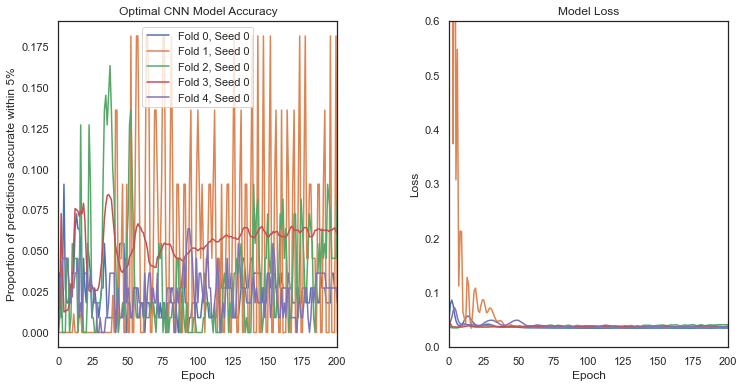

In [118]:
#Compare the best models performance across folds

#Define plot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Accuracy plot
axs[0].plot(cnnhistory00.history["val_accuracy_within_5_percent"], label="Fold 0, Seed 0")
axs[0].plot(cnnhistory10.history["val_accuracy_within_5_percent"], label="Fold 1, Seed 0")
axs[0].plot(cnnhistory20.history["val_accuracy_within_5_percent"], label="Fold 2, Seed 0")
axs[0].plot(cnnhistory30.history["val_accuracy_within_5_percent"], label="Fold 3, Seed 0")
axs[0].plot(cnnhistory40.history["val_accuracy_within_5_percent"], label="Fold 4, Seed 0")
axs[0].set_title("Optimal CNN Model Accuracy")
axs[0].set_ylabel("Proportion of predictions accurate within 5%")
axs[0].set_xlabel("Epoch")
axs[0].set_xlim(0, 200)
axs[0].legend()

#Loss subplot
axs[1].plot(cnnhistory00.history["val_loss"], label="Fold 0, Seed 0")
axs[1].plot(cnnhistory10.history["val_loss"], label="Fold 1, Seed 0")
axs[1].plot(cnnhistory20.history["val_loss"], label="Fold 2, Seed 0")
axs[1].plot(cnnhistory30.history["val_loss"], label="Fold 3, Seed 0")
axs[1].plot(cnnhistory40.history["val_loss"], label="Fold 4, Seed 0")
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xlim(0, 200)
axs[1].set_ylim(0, 0.6)

#Adjust spacing
plt.subplots_adjust(wspace=0.4)

#Display plots
plt.show()

In [119]:
#Repeat with a better performance metric in the tuner


#Define function for hyperparameter tuning
def build_model(hp):
    #Start model
    model = keras.Sequential()
    #Input layer
    inp = tf.keras.layers.Input(shape=(X_train.shape[1],))
    #Convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=6, step=1)
    #Reshape input data
    x = tf.keras.layers.Reshape((X_train.shape[1], 1))(inp)
    for i in range(num_conv_layers):
        #Define number of filters to test 
        hp_filters = hp.Int('filters_{i}'.format(i=i), min_value=4, max_value=128, step=8)
        #Define kernel size to test for each convolutional layer
        hp_kernel_size = hp.Int('kernel_size_{i}'.format(i=i), min_value=2, max_value=5, step=1)
        #Define activation function to test 
        hp_conv_activation = hp.Choice('conv_activation_{i}'.format(i=i), values=['relu', 'selu', 'elu', 'swish'])
        #Define pool sizes to test
        hp_pool_size = hp.Int('pool_size_{i}'.format(i=i), min_value=1, max_value=5, step=1)
        #Add the convolutional layer
        x = tf.keras.layers.Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation=hp_conv_activation)(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=hp_pool_size)(x)
    #Test models with up to 6 dense layers
    num_dense = hp.Int('num_dense', min_value=3, max_value=6, step=1)
    #Iterate through each layer
    for i in range(num_dense):
        #Define units to test
        hp_units = hp.Int('units_{i}'.format(i=i), min_value=8, max_value=4096, step=128)
        #Define dropout values to test
        hp_drop_rate = hp.Choice('dp_{i}'.format(i=i), values=[0.0, 0.1, 0.15, 0.2, 0.25 ,0.3,
                                                               0.35,0.4, 0.5, 0.6, 0.7])
        #Define activation functions to test
        hp_activation = hp.Choice('dense_activation_{i}'.format(i=i),values=['relu', 'selu',
                                                                             'elu', 'swish'])
        #Define the way data flows through hidden layers
        x = tf.keras.layers.Dense(units=hp_units, activation=hp_activation)(x)
        x = tf.keras.layers.Dropout(hp_drop_rate)(x)
        x = tf.keras.layers.BatchNormalization()(x)
    #Output layer
    outputs = tf.keras.layers.Dense(1, kernel_initializer='normal', activation='linear')(x)
    #Create the model with the defined input and outputs
    model = tf.keras.models.Model(inp, outputs)
    #Compile the model
    model.compile(
      optimizer=keras.optimizers.Adam(
        #Define learning rates to test
        hp.Choice('learning_rate', values = [1e-3, 1e-4, 1e-5, 0.0])),
      loss='mean_absolute_error',
      metrics=['mean_absolute_error', accuracy_within_5_percent])
    return model

In [120]:
#Defining parameters
feats = np.arange(0,X.shape[1],1)
inp_size = int(np.ceil(1* len(feats)))
n_split = 5
n_repeats = 1
bests_cnn=[]
seeds = [0, 1]
n_round = len(seeds)

for seed in seeds:
    split_cols = np.random.choice(feats, inp_size, replace=False)
    #Use k fold cross validation to split data into train and test
    for n, (train, test) in enumerate(KFold(n_splits = n_split, random_state=0,
                                       shuffle = True).split(X, Y)):
        st = time_module.time()
        #Define tuning objectives and params
        tuner = kt.tuners.BayesianOptimization(build_model,
                     kt.Objective('mean_absolute_error', direction="min"),
                     max_trials = 10, overwrite=True)
        start_time = time_module.time()
        X_train = X[train][:, split_cols]
        X_val = X[test][:, split_cols]
        Y_train, Y_val = Y[train], Y[test]
        #Early stop if the validation accuracy does not improve for 10 epochs
        callbacks=[EarlyStopping(monitor='mean_absolute_error', mode='max', patience=10)]
        start_time = time_module.time()
        #Perform hyperparameter search using train and val data
        tuner.search(X_train, Y_train,validation_data=(X_val, Y_val),
                            epochs = 500, batch_size = 128,
                            verbose = 0, callbacks = callbacks)
        #Create method to recall best hyperparameters identified during the trial
        n_top = 5
        best_hps = tuner.get_best_hyperparameters(n_top)
        end_time = time_module.time()
        bests_cnn.append(best_hps)
        for i in range(n_top):
            print(best_hps[i].values)
        #Print statements to monitor the progress of the tests
        print('Seed', seed, 'Fold', n, 'Time elapsed:', "{:.2f}".format((end_time-start_time)/60), 'minutes')
        #Delete old tuner for memory conservation
        del tuner

Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

{'num_conv_layers': 3, 'filters_0': 116, 'kernel_size_0': 5, 'conv_activation_0': 'elu', 'pool_size_0': 3, 'num_dense': 6, 'units_0': 136, 'dp_0': 0.1, 'dense_activation_0': 'selu', 'units_1': 2440, 'dp_1': 0.6, 'dense_activation_1': 'swish', 'units_2': 8, 'dp_2': 0.5, 'dense_activation_2': 'swish', 'learning_rate': 1e-05, 'filters_1': 4, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'pool_size_1': 1, 'filters_2': 4, 'kernel_size_2': 2, 'conv_activation_2': 'relu', 'pool_size_2': 1, 'units_3': 8, 'dp_3': 0.0, 'dense_activation_3': 'relu', 'units_4': 8, 'dp_4': 0.0, 'dense_activation_4': 'relu', 'units_5': 8, 'dp_5': 0.0, 'dense_activation_5': 'relu'}
{'num_conv_layers': 6, 'filters_0': 4, 'kernel_size_0': 3, 'conv_activation_0': 'relu', 'pool_size_0': 3, 'num_dense': 5, 'units_0': 1544, 'dp_0': 0.15, 'dense_activation_0': 'swish', 'units_1': 2568, 'dp_1': 0.35, 'dense_activation_1': 'elu', 'units_2': 136, 'dp_2': 0.35, 'dense_activation_2': 'relu', 'learning_rate': 0.001, 'filters_1

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

{'num_conv_layers': 5, 'filters_0': 100, 'kernel_size_0': 2, 'conv_activation_0': 'swish', 'pool_size_0': 5, 'num_dense': 6, 'units_0': 904, 'dp_0': 0.35, 'dense_activation_0': 'swish', 'units_1': 3208, 'dp_1': 0.4, 'dense_activation_1': 'swish', 'units_2': 3208, 'dp_2': 0.4, 'dense_activation_2': 'relu', 'learning_rate': 1e-05, 'filters_1': 4, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'pool_size_1': 1, 'filters_2': 4, 'kernel_size_2': 2, 'conv_activation_2': 'relu', 'pool_size_2': 1, 'filters_3': 4, 'kernel_size_3': 2, 'conv_activation_3': 'relu', 'pool_size_3': 1, 'filters_4': 4, 'kernel_size_4': 2, 'conv_activation_4': 'relu', 'pool_size_4': 1, 'units_3': 8, 'dp_3': 0.0, 'dense_activation_3': 'relu', 'units_4': 8, 'dp_4': 0.0, 'dense_activation_4': 'relu', 'units_5': 8, 'dp_5': 0.0, 'dense_activation_5': 'relu'}
{'num_conv_layers': 3, 'filters_0': 76, 'kernel_size_0': 4, 'conv_activation_0': 'swish', 'pool_size_0': 2, 'num_dense': 6, 'units_0': 3208, 'dp_0': 0.3, 'dense_activ

Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

{'num_conv_layers': 4, 'filters_0': 68, 'kernel_size_0': 4, 'conv_activation_0': 'relu', 'pool_size_0': 5, 'num_dense': 4, 'units_0': 3592, 'dp_0': 0.35, 'dense_activation_0': 'selu', 'units_1': 1800, 'dp_1': 0.4, 'dense_activation_1': 'elu', 'units_2': 8, 'dp_2': 0.7, 'dense_activation_2': 'relu', 'learning_rate': 0.0001, 'filters_1': 4, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'pool_size_1': 1, 'filters_2': 4, 'kernel_size_2': 2, 'conv_activation_2': 'relu', 'pool_size_2': 1, 'filters_3': 4, 'kernel_size_3': 2, 'conv_activation_3': 'relu', 'pool_size_3': 1, 'units_3': 8, 'dp_3': 0.0, 'dense_activation_3': 'relu'}
{'num_conv_layers': 1, 'filters_0': 92, 'kernel_size_0': 4, 'conv_activation_0': 'selu', 'pool_size_0': 4, 'num_dense': 6, 'units_0': 1032, 'dp_0': 0.4, 'dense_activation_0': 'relu', 'units_1': 1672, 'dp_1': 0.15, 'dense_activation_1': 'relu', 'units_2': 3464, 'dp_2': 0.4, 'dense_activation_2': 'elu', 'learning_rate': 1e-05, 'filters_1': 44, 'kernel_size_1': 3, 'conv

Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

{'num_conv_layers': 3, 'filters_0': 116, 'kernel_size_0': 2, 'conv_activation_0': 'selu', 'pool_size_0': 5, 'num_dense': 6, 'units_0': 3464, 'dp_0': 0.6, 'dense_activation_0': 'elu', 'units_1': 3208, 'dp_1': 0.7, 'dense_activation_1': 'selu', 'units_2': 8, 'dp_2': 0.3, 'dense_activation_2': 'elu', 'learning_rate': 0.0001, 'filters_1': 4, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'pool_size_1': 1, 'filters_2': 4, 'kernel_size_2': 2, 'conv_activation_2': 'relu', 'pool_size_2': 1, 'units_3': 8, 'dp_3': 0.0, 'dense_activation_3': 'relu', 'units_4': 8, 'dp_4': 0.0, 'dense_activation_4': 'relu', 'units_5': 8, 'dp_5': 0.0, 'dense_activation_5': 'relu'}
{'num_conv_layers': 6, 'filters_0': 68, 'kernel_size_0': 4, 'conv_activation_0': 'selu', 'pool_size_0': 2, 'num_dense': 3, 'units_0': 3848, 'dp_0': 0.4, 'dense_activation_0': 'elu', 'units_1': 1544, 'dp_1': 0.4, 'dense_activation_1': 'swish', 'units_2': 2056, 'dp_2': 0.3, 'dense_activation_2': 'relu', 'learning_rate': 0.0001, 'filters_1'

Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

INFO:tensorflow:Oracle triggered exit
{'num_conv_layers': 1, 'filters_0': 4, 'kernel_size_0': 3, 'conv_activation_0': 'elu', 'pool_size_0': 5, 'num_dense': 5, 'units_0': 1544, 'dp_0': 0.7, 'dense_activation_0': 'swish', 'units_1': 3080, 'dp_1': 0.25, 'dense_activation_1': 'relu', 'units_2': 392, 'dp_2': 0.4, 'dense_activation_2': 'selu', 'learning_rate': 0.0001, 'filters_1': 28, 'kernel_size_1': 5, 'conv_activation_1': 'swish', 'pool_size_1': 5, 'filters_2': 60, 'kernel_size_2': 2, 'conv_activation_2': 'selu', 'pool_size_2': 5, 'filters_3': 44, 'kernel_size_3': 2, 'conv_activation_3': 'swish', 'pool_size_3': 4, 'filters_4': 12, 'kernel_size_4': 2, 'conv_activation_4': 'relu', 'pool_size_4': 5, 'units_3': 8, 'dp_3': 0.0, 'dense_activation_3': 'relu', 'units_4': 8, 'dp_4': 0.0, 'dense_activation_4': 'relu'}
{'num_conv_layers': 4, 'filters_0': 68, 'kernel_size_0': 2, 'conv_activation_0': 'selu', 'pool_size_0': 5, 'num_dense': 4, 'units_0': 2952, 'dp_0': 0.25, 'dense_activation_0': 'selu',

Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

INFO:tensorflow:Oracle triggered exit
{'num_conv_layers': 5, 'filters_0': 108, 'kernel_size_0': 5, 'conv_activation_0': 'swish', 'pool_size_0': 3, 'num_dense': 5, 'units_0': 2952, 'dp_0': 0.5, 'dense_activation_0': 'swish', 'units_1': 3464, 'dp_1': 0.6, 'dense_activation_1': 'swish', 'units_2': 3208, 'dp_2': 0.7, 'dense_activation_2': 'swish', 'learning_rate': 0.0, 'filters_1': 4, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'pool_size_1': 1, 'filters_2': 4, 'kernel_size_2': 2, 'conv_activation_2': 'relu', 'pool_size_2': 1, 'filters_3': 4, 'kernel_size_3': 2, 'conv_activation_3': 'relu', 'pool_size_3': 1, 'filters_4': 4, 'kernel_size_4': 2, 'conv_activation_4': 'relu', 'pool_size_4': 1, 'units_3': 8, 'dp_3': 0.0, 'dense_activation_3': 'relu', 'units_4': 8, 'dp_4': 0.0, 'dense_activation_4': 'relu'}
{'num_conv_layers': 3, 'filters_0': 20, 'kernel_size_0': 3, 'conv_activation_0': 'elu', 'pool_size_0': 4, 'num_dense': 6, 'units_0': 136, 'dp_0': 0.2, 'dense_activation_0': 'elu', 'units

Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

INFO:tensorflow:Oracle triggered exit
{'num_conv_layers': 4, 'filters_0': 60, 'kernel_size_0': 4, 'conv_activation_0': 'elu', 'pool_size_0': 4, 'num_dense': 5, 'units_0': 520, 'dp_0': 0.3, 'dense_activation_0': 'elu', 'units_1': 776, 'dp_1': 0.2, 'dense_activation_1': 'relu', 'units_2': 2440, 'dp_2': 0.2, 'dense_activation_2': 'relu', 'learning_rate': 1e-05, 'filters_1': 68, 'kernel_size_1': 5, 'conv_activation_1': 'selu', 'pool_size_1': 1, 'filters_2': 12, 'kernel_size_2': 2, 'conv_activation_2': 'elu', 'pool_size_2': 5, 'units_3': 1416, 'dp_3': 0.0, 'dense_activation_3': 'relu', 'filters_3': 4, 'kernel_size_3': 2, 'conv_activation_3': 'relu', 'pool_size_3': 1, 'units_4': 8, 'dp_4': 0.0, 'dense_activation_4': 'relu'}
{'num_conv_layers': 3, 'filters_0': 108, 'kernel_size_0': 4, 'conv_activation_0': 'swish', 'pool_size_0': 2, 'num_dense': 4, 'units_0': 520, 'dp_0': 0.2, 'dense_activation_0': 'elu', 'units_1': 520, 'dp_1': 0.3, 'dense_activation_1': 'selu', 'units_2': 1672, 'dp_2': 0.1, 

Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\niamh\anaconda3\lib\site-packages\keras_tuner\engine\tuner.py", line 146, in _build_hypermodel
    model = sel

{'num_conv_layers': 5, 'filters_0': 100, 'kernel_size_0': 5, 'conv_activation_0': 'elu', 'pool_size_0': 2, 'num_dense': 6, 'units_0': 1544, 'dp_0': 0.15, 'dense_activation_0': 'relu', 'units_1': 3848, 'dp_1': 0.2, 'dense_activation_1': 'selu', 'units_2': 1416, 'dp_2': 0.1, 'dense_activation_2': 'swish', 'learning_rate': 0.001, 'filters_1': 4, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'pool_size_1': 1, 'filters_2': 4, 'kernel_size_2': 2, 'conv_activation_2': 'relu', 'pool_size_2': 1, 'filters_3': 4, 'kernel_size_3': 2, 'conv_activation_3': 'relu', 'pool_size_3': 1, 'filters_4': 4, 'kernel_size_4': 2, 'conv_activation_4': 'relu', 'pool_size_4': 1, 'units_3': 8, 'dp_3': 0.0, 'dense_activation_3': 'relu', 'units_4': 8, 'dp_4': 0.0, 'dense_activation_4': 'relu', 'units_5': 8, 'dp_5': 0.0, 'dense_activation_5': 'relu'}
{'num_conv_layers': 3, 'filters_0': 92, 'kernel_size_0': 4, 'conv_activation_0': 'relu', 'pool_size_0': 1, 'num_dense': 3, 'units_0': 904, 'dp_0': 0.6, 'dense_activatio

In [121]:
#Print outcome from fold 0 seed 0
print(bests_cnn[0][0].values)

{'num_conv_layers': 3, 'filters_0': 116, 'kernel_size_0': 5, 'conv_activation_0': 'elu', 'pool_size_0': 3, 'num_dense': 6, 'units_0': 136, 'dp_0': 0.1, 'dense_activation_0': 'selu', 'units_1': 2440, 'dp_1': 0.6, 'dense_activation_1': 'swish', 'units_2': 8, 'dp_2': 0.5, 'dense_activation_2': 'swish', 'learning_rate': 1e-05, 'filters_1': 4, 'kernel_size_1': 2, 'conv_activation_1': 'relu', 'pool_size_1': 1, 'filters_2': 4, 'kernel_size_2': 2, 'conv_activation_2': 'relu', 'pool_size_2': 1, 'units_3': 8, 'dp_3': 0.0, 'dense_activation_3': 'relu', 'units_4': 8, 'dp_4': 0.0, 'dense_activation_4': 'relu', 'units_5': 8, 'dp_5': 0.0, 'dense_activation_5': 'relu'}


In [127]:
#Test the first CNN option using other metric to optimise


#Start new NN
model = keras.Sequential()

#Add layers per best hyperparam tuning outcomes
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Convolutional layer
model.add(Conv1D(filters=116, kernel_size=5, activation='elu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Dense(136, kernel_initializer='normal', activation='selu'))
model.add(Dropout(0.1))

model.add(Dense(2440, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.6))

model.add(Dense(8, kernel_initializer='normal', activation='swish'))
model.add(Dropout(0.5))

model.add(Conv1D(filters=4, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))

model.add(Conv1D(filters=4, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))

model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.0))

model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.0))

#Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Define optimizer
optimizer = Adam(learning_rate=1e-5)

#Compile the network
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error', accuracy_within_5_percent])
model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'Test CNN-Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_accuracy_within_5_percent', 
                             verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
cnnhistorytest = model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.2, callbacks = callbacks_list)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 300, 1)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 296, 116)          696       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 98, 116)          0         
 1D)                                                             
                                                                 
 dense_4 (Dense)             (None, 98, 136)           15912     
                                                                 
 dropout_3 (Dropout)         (None, 98, 136)           0         
                                                                 
 dense_5 (Dense)             (None, 98, 2440)          334280    
                                                      

Epoch 13/500
1/1 [==============================] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.0448 - accuracy_within_5_percent: 0.0000e+00
Epoch 13: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 341ms/step - loss: 0.0448 - mean_absolute_error: 0.0448 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0564 - val_mean_absolute_error: 0.0564 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 14/500
1/1 [==============================] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.0448 - accuracy_within_5_percent: 0.0000e+00
Epoch 14: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 333ms/step - loss: 0.0448 - mean_absolute_error: 0.0448 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0563 - val_mean_absolute_error: 0.0563 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 15/500
1/1 [==============================] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.04

1/1 [==============================] - ETA: 0s - loss: 0.0446 - mean_absolute_error: 0.0446 - accuracy_within_5_percent: 0.0000e+00
Epoch 31: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 330ms/step - loss: 0.0446 - mean_absolute_error: 0.0446 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0561 - val_mean_absolute_error: 0.0561 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 32/500
1/1 [==============================] - ETA: 0s - loss: 0.0446 - mean_absolute_error: 0.0446 - accuracy_within_5_percent: 0.0000e+00
Epoch 32: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 350ms/step - loss: 0.0446 - mean_absolute_error: 0.0446 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0561 - val_mean_absolute_error: 0.0561 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 33/500
1/1 [==============================] - ETA: 0s - loss: 0.0446 - mean_absolute_error: 0.0446 - accuracy

1/1 [==============================] - ETA: 0s - loss: 0.0444 - mean_absolute_error: 0.0444 - accuracy_within_5_percent: 0.0000e+00
Epoch 49: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 352ms/step - loss: 0.0444 - mean_absolute_error: 0.0444 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0559 - val_mean_absolute_error: 0.0559 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 50/500
1/1 [==============================] - ETA: 0s - loss: 0.0443 - mean_absolute_error: 0.0443 - accuracy_within_5_percent: 0.0000e+00
Epoch 50: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 344ms/step - loss: 0.0443 - mean_absolute_error: 0.0443 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0559 - val_mean_absolute_error: 0.0559 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 51/500
1/1 [==============================] - ETA: 0s - loss: 0.0443 - mean_absolute_error: 0.0443 - accuracy

1/1 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.0441 - accuracy_within_5_percent: 0.0000e+00
Epoch 67: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 361ms/step - loss: 0.0441 - mean_absolute_error: 0.0441 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0557 - val_mean_absolute_error: 0.0557 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 68/500
1/1 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.0441 - accuracy_within_5_percent: 0.0000e+00
Epoch 68: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 338ms/step - loss: 0.0441 - mean_absolute_error: 0.0441 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0556 - val_mean_absolute_error: 0.0556 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 69/500
1/1 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.0441 - accuracy

1/1 [==============================] - ETA: 0s - loss: 0.0439 - mean_absolute_error: 0.0439 - accuracy_within_5_percent: 0.0000e+00
Epoch 85: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 344ms/step - loss: 0.0439 - mean_absolute_error: 0.0439 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0554 - val_mean_absolute_error: 0.0554 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 86/500
1/1 [==============================] - ETA: 0s - loss: 0.0439 - mean_absolute_error: 0.0439 - accuracy_within_5_percent: 0.0000e+00
Epoch 86: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 339ms/step - loss: 0.0439 - mean_absolute_error: 0.0439 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0554 - val_mean_absolute_error: 0.0554 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 87/500
1/1 [==============================] - ETA: 0s - loss: 0.0439 - mean_absolute_error: 0.0439 - accuracy

1/1 [==============================] - ETA: 0s - loss: 0.0436 - mean_absolute_error: 0.0436 - accuracy_within_5_percent: 0.0000e+00
Epoch 103: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 347ms/step - loss: 0.0436 - mean_absolute_error: 0.0436 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0552 - val_mean_absolute_error: 0.0552 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 104/500
1/1 [==============================] - ETA: 0s - loss: 0.0436 - mean_absolute_error: 0.0436 - accuracy_within_5_percent: 0.0000e+00
Epoch 104: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 366ms/step - loss: 0.0436 - mean_absolute_error: 0.0436 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0552 - val_mean_absolute_error: 0.0552 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 105/500
1/1 [==============================] - ETA: 0s - loss: 0.0436 - mean_absolute_error: 0.0436 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0434 - mean_absolute_error: 0.0434 - accuracy_within_5_percent: 0.0000e+00
Epoch 121: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 337ms/step - loss: 0.0434 - mean_absolute_error: 0.0434 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0549 - val_mean_absolute_error: 0.0549 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 122/500
1/1 [==============================] - ETA: 0s - loss: 0.0434 - mean_absolute_error: 0.0434 - accuracy_within_5_percent: 0.0000e+00
Epoch 122: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 345ms/step - loss: 0.0434 - mean_absolute_error: 0.0434 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0549 - val_mean_absolute_error: 0.0549 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 123/500
1/1 [==============================] - ETA: 0s - loss: 0.0434 - mean_absolute_error: 0.0434 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0432 - mean_absolute_error: 0.0432 - accuracy_within_5_percent: 0.0000e+00
Epoch 139: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 365ms/step - loss: 0.0432 - mean_absolute_error: 0.0432 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0547 - val_mean_absolute_error: 0.0547 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 140/500
1/1 [==============================] - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.0431 - accuracy_within_5_percent: 0.0000e+00
Epoch 140: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 363ms/step - loss: 0.0431 - mean_absolute_error: 0.0431 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0547 - val_mean_absolute_error: 0.0547 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 141/500
1/1 [==============================] - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.0431 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.0429 - accuracy_within_5_percent: 0.0000e+00
Epoch 157: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 356ms/step - loss: 0.0429 - mean_absolute_error: 0.0429 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0545 - val_mean_absolute_error: 0.0545 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 158/500
1/1 [==============================] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.0429 - accuracy_within_5_percent: 0.0000e+00
Epoch 158: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 356ms/step - loss: 0.0429 - mean_absolute_error: 0.0429 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0545 - val_mean_absolute_error: 0.0545 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 159/500
1/1 [==============================] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.0429 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.0427 - accuracy_within_5_percent: 0.0000e+00
Epoch 175: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 351ms/step - loss: 0.0427 - mean_absolute_error: 0.0427 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0542 - val_mean_absolute_error: 0.0542 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 176/500
1/1 [==============================] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.0426 - accuracy_within_5_percent: 0.0000e+00
Epoch 176: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 343ms/step - loss: 0.0426 - mean_absolute_error: 0.0426 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0542 - val_mean_absolute_error: 0.0542 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 177/500
1/1 [==============================] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.0426 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.0424 - accuracy_within_5_percent: 0.0000e+00
Epoch 193: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 381ms/step - loss: 0.0424 - mean_absolute_error: 0.0424 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0540 - val_mean_absolute_error: 0.0540 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 194/500
1/1 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.0424 - accuracy_within_5_percent: 0.0000e+00
Epoch 194: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 397ms/step - loss: 0.0424 - mean_absolute_error: 0.0424 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0540 - val_mean_absolute_error: 0.0540 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 195/500
1/1 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.0424 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.0421 - accuracy_within_5_percent: 0.0000e+00
Epoch 211: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 365ms/step - loss: 0.0421 - mean_absolute_error: 0.0421 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0537 - val_mean_absolute_error: 0.0537 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 212/500
1/1 [==============================] - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.0421 - accuracy_within_5_percent: 0.0000e+00
Epoch 212: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 354ms/step - loss: 0.0421 - mean_absolute_error: 0.0421 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0537 - val_mean_absolute_error: 0.0537 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 213/500
1/1 [==============================] - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.0421 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.0419 - accuracy_within_5_percent: 0.0000e+00
Epoch 229: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 361ms/step - loss: 0.0419 - mean_absolute_error: 0.0419 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0535 - val_mean_absolute_error: 0.0535 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 230/500
1/1 [==============================] - ETA: 0s - loss: 0.0418 - mean_absolute_error: 0.0418 - accuracy_within_5_percent: 0.0000e+00
Epoch 230: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 358ms/step - loss: 0.0418 - mean_absolute_error: 0.0418 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0535 - val_mean_absolute_error: 0.0535 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 231/500
1/1 [==============================] - ETA: 0s - loss: 0.0418 - mean_absolute_error: 0.0418 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416 - accuracy_within_5_percent: 0.0000e+00
Epoch 247: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 356ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0532 - val_mean_absolute_error: 0.0532 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 248/500
1/1 [==============================] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416 - accuracy_within_5_percent: 0.0000e+00
Epoch 248: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 380ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0532 - val_mean_absolute_error: 0.0532 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 249/500
1/1 [==============================] - ETA: 0s - loss: 0.0415 - mean_absolute_error: 0.0415 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413 - accuracy_within_5_percent: 0.0000e+00
Epoch 265: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 374ms/step - loss: 0.0413 - mean_absolute_error: 0.0413 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0529 - val_mean_absolute_error: 0.0529 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 266/500
1/1 [==============================] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413 - accuracy_within_5_percent: 0.0000e+00
Epoch 266: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 341ms/step - loss: 0.0413 - mean_absolute_error: 0.0413 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0529 - val_mean_absolute_error: 0.0529 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 267/500
1/1 [==============================] - ETA: 0s - loss: 0.0412 - mean_absolute_error: 0.0412 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.0410 - accuracy_within_5_percent: 0.0000e+00
Epoch 283: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 361ms/step - loss: 0.0410 - mean_absolute_error: 0.0410 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0527 - val_mean_absolute_error: 0.0527 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 284/500
1/1 [==============================] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.0409 - accuracy_within_5_percent: 0.0000e+00
Epoch 284: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 357ms/step - loss: 0.0409 - mean_absolute_error: 0.0409 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0526 - val_mean_absolute_error: 0.0526 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 285/500
1/1 [==============================] - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.0409 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406 - accuracy_within_5_percent: 0.0000e+00
Epoch 301: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 373ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0524 - val_mean_absolute_error: 0.0524 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 302/500
1/1 [==============================] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406 - accuracy_within_5_percent: 0.0000e+00
Epoch 302: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 368ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0524 - val_mean_absolute_error: 0.0524 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 303/500
1/1 [==============================] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.0406 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402 - accuracy_within_5_percent: 0.0000e+00
Epoch 319: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 362ms/step - loss: 0.0402 - mean_absolute_error: 0.0402 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 320/500
1/1 [==============================] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402 - accuracy_within_5_percent: 0.0000e+00
Epoch 320: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 347ms/step - loss: 0.0402 - mean_absolute_error: 0.0402 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 321/500
1/1 [==============================] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.0402 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398 - accuracy_within_5_percent: 0.0000e+00
Epoch 337: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 346ms/step - loss: 0.0398 - mean_absolute_error: 0.0398 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 338/500
1/1 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398 - accuracy_within_5_percent: 0.0000e+00
Epoch 338: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 366ms/step - loss: 0.0398 - mean_absolute_error: 0.0398 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 339/500
1/1 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.0394 - accuracy_within_5_percent: 0.0000e+00
Epoch 355: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 359ms/step - loss: 0.0394 - mean_absolute_error: 0.0394 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0515 - val_mean_absolute_error: 0.0515 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 356/500
1/1 [==============================] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393 - accuracy_within_5_percent: 0.0000e+00
Epoch 356: val_accuracy_within_5_percent did not improve from 0.00000
1/1 [==============================] - 0s 362ms/step - loss: 0.0393 - mean_absolute_error: 0.0393 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0514 - val_mean_absolute_error: 0.0514 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 357/500
1/1 [==============================] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.0393 - accu

1/1 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388 - accuracy_within_5_percent: 0.0000e+00
Epoch 373: val_accuracy_within_5_percent did not improve from 0.00047
1/1 [==============================] - 0s 337ms/step - loss: 0.0388 - mean_absolute_error: 0.0388 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0511 - val_mean_absolute_error: 0.0511 - val_accuracy_within_5_percent: 4.7348e-04
Epoch 374/500
1/1 [==============================] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388 - accuracy_within_5_percent: 0.0000e+00
Epoch 374: val_accuracy_within_5_percent improved from 0.00047 to 0.00095, saving model to Test CNN-Weights-374--0.05111.hdf5
1/1 [==============================] - 0s 396ms/step - loss: 0.0388 - mean_absolute_error: 0.0388 - accuracy_within_5_percent: 0.0000e+00 - val_loss: 0.0511 - val_mean_absolute_error: 0.0511 - val_accuracy_within_5_percent: 9.4697e-04
Epoch 375/500
1/1 [==============================] - ETA

1/1 [==============================] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.0384 - accuracy_within_5_percent: 2.4802e-04
Epoch 390: val_accuracy_within_5_percent improved from 0.00568 to 0.00616, saving model to Test CNN-Weights-390--0.05081.hdf5
1/1 [==============================] - 0s 386ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - accuracy_within_5_percent: 2.4802e-04 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508 - val_accuracy_within_5_percent: 0.0062
Epoch 391/500
1/1 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383 - accuracy_within_5_percent: 1.2401e-04
Epoch 391: val_accuracy_within_5_percent improved from 0.00616 to 0.00758, saving model to Test CNN-Weights-391--0.05079.hdf5
1/1 [==============================] - 0s 401ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - accuracy_within_5_percent: 1.2401e-04 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508 - val_accuracy_within_5_percent: 0.0076
Epoch 39

1/1 [==============================] - 0s 386ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - accuracy_within_5_percent: 3.7202e-04 - val_loss: 0.0505 - val_mean_absolute_error: 0.0505 - val_accuracy_within_5_percent: 0.0260
Epoch 407/500
1/1 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.0378 - accuracy_within_5_percent: 4.9603e-04
Epoch 407: val_accuracy_within_5_percent improved from 0.02604 to 0.02699, saving model to Test CNN-Weights-407--0.05048.hdf5
1/1 [==============================] - 0s 409ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - accuracy_within_5_percent: 4.9603e-04 - val_loss: 0.0505 - val_mean_absolute_error: 0.0505 - val_accuracy_within_5_percent: 0.0270
Epoch 408/500
1/1 [==============================] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377 - accuracy_within_5_percent: 9.9206e-04
Epoch 408: val_accuracy_within_5_percent improved from 0.02699 to 0.02794, saving model to Test CNN-Weights-408--0.05046

Epoch 424/500
1/1 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.0372 - accuracy_within_5_percent: 0.0015
Epoch 424: val_accuracy_within_5_percent did not improve from 0.03646
1/1 [==============================] - 0s 348ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - accuracy_within_5_percent: 0.0015 - val_loss: 0.0502 - val_mean_absolute_error: 0.0502 - val_accuracy_within_5_percent: 0.0312
Epoch 425/500
1/1 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371 - accuracy_within_5_percent: 0.0022
Epoch 425: val_accuracy_within_5_percent did not improve from 0.03646
1/1 [==============================] - 0s 342ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - accuracy_within_5_percent: 0.0022 - val_loss: 0.0501 - val_mean_absolute_error: 0.0501 - val_accuracy_within_5_percent: 0.0308
Epoch 426/500
1/1 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371 - accuracy_withi

Epoch 443/500
1/1 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364 - accuracy_within_5_percent: 0.0038
Epoch 443: val_accuracy_within_5_percent did not improve from 0.03646
1/1 [==============================] - 0s 349ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - accuracy_within_5_percent: 0.0038 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498 - val_accuracy_within_5_percent: 0.0123
Epoch 444/500
1/1 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364 - accuracy_within_5_percent: 0.0046
Epoch 444: val_accuracy_within_5_percent did not improve from 0.03646
1/1 [==============================] - 0s 358ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - accuracy_within_5_percent: 0.0046 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498 - val_accuracy_within_5_percent: 0.0109
Epoch 445/500
1/1 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363 - accuracy_withi

Epoch 462/500
1/1 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356 - accuracy_within_5_percent: 0.0077
Epoch 462: val_accuracy_within_5_percent did not improve from 0.03646
1/1 [==============================] - 0s 367ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - accuracy_within_5_percent: 0.0077 - val_loss: 0.0494 - val_mean_absolute_error: 0.0494 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 463/500
1/1 [==============================] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.0356 - accuracy_within_5_percent: 0.0074
Epoch 463: val_accuracy_within_5_percent did not improve from 0.03646
1/1 [==============================] - 0s 348ms/step - loss: 0.0356 - mean_absolute_error: 0.0356 - accuracy_within_5_percent: 0.0074 - val_loss: 0.0494 - val_mean_absolute_error: 0.0494 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 464/500
1/1 [==============================] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355 - accura

Epoch 481/500
1/1 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347 - accuracy_within_5_percent: 0.0119
Epoch 481: val_accuracy_within_5_percent did not improve from 0.03646
1/1 [==============================] - 0s 355ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - accuracy_within_5_percent: 0.0119 - val_loss: 0.0490 - val_mean_absolute_error: 0.0490 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 482/500
1/1 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0348 - accuracy_within_5_percent: 0.0126
Epoch 482: val_accuracy_within_5_percent did not improve from 0.03646
1/1 [==============================] - 0s 362ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - accuracy_within_5_percent: 0.0126 - val_loss: 0.0490 - val_mean_absolute_error: 0.0490 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 483/500
1/1 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.0347 - accura

Epoch 500/500
1/1 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.0339 - accuracy_within_5_percent: 0.0182
Epoch 500: val_accuracy_within_5_percent did not improve from 0.03646
1/1 [==============================] - 0s 371ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - accuracy_within_5_percent: 0.0182 - val_loss: 0.0485 - val_mean_absolute_error: 0.0485 - val_accuracy_within_5_percent: 0.0000e+00


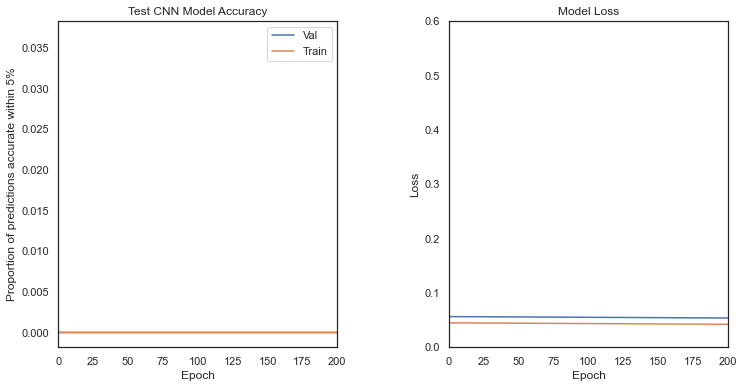

In [128]:
#Compare the best models performance across folds

#Define plot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Accuracy plot
axs[0].plot(cnnhistorytest.history["val_accuracy_within_5_percent"], label="Val")
axs[0].plot(cnnhistorytest.history["accuracy_within_5_percent"], label="Train")
axs[0].set_title("Test CNN Model Accuracy")
axs[0].set_ylabel("Proportion of predictions accurate within 5%")
axs[0].set_xlabel("Epoch")
axs[0].set_xlim(0, 200)
axs[0].legend()

#Loss subplot
axs[1].plot(cnnhistorytest.history["val_loss"], label="Val")
axs[1].plot(cnnhistorytest.history["loss"], label="Train")
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xlim(0, 200)
axs[1].set_ylim(0, 0.6)

#Adjust spacing
plt.subplots_adjust(wspace=0.4)

#Display plots
plt.show()

# Reframe as classification problem

In [129]:
df_le01 = df

In [131]:
df.columns

Index(['unicode', 'emoji', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'Position', 'Unicode block', 'le_+',
       'le_-', 'le_0', 'sent_score', 'sent_score_class', 'upper_error_class',
       'lower_error_class', 'sent_polar', 'primary_basic_emot', 'total'],
      dtype='object')

In [132]:
df.head()

unicode emoji  anger  anticipation  disgust  fear   joy  sadness  surprise  \
0   1F308     🌈   0.00          0.28     0.00  0.00  0.69     0.06      0.22   
1   1F319     🌙   0.00          0.31     0.00  0.00  0.25     0.00      0.06   
2   1F31A     🌚   0.06          0.08     0.17  0.06  0.42     0.19      0.06   
3   1F31E     🌞   0.00          0.22     0.00  0.00  0.78     0.00      0.11   
4   1F31F     🌟   0.00          0.28     0.00  0.00  0.53     0.00      0.25   

   trust  ...      le_+      le_-      le_0  sent_score  sent_score_class  \
0   0.33  ...  0.582418  0.065934  0.351648    0.516484          Positive   
1   0.25  ...  0.655738  0.065574  0.278689    0.590164          Positive   
2   0.11  ...  0.622517  0.158940  0.218543    0.463576          Positive   
3   0.22  ...  0.581818  0.024242  0.393939    0.557576          Positive   
4   0.31  ...  0.386139  0.059406  0.554455    0.326733          Positive   

   upper_error_class lower_error_class sent_polar primary_basic_emot total  
0           Positive          Positive   Positive                joy  1.58  
1           Positive          Positive   Positive       anticipation  0.87  
2           Positive          Positive   Positive                joy  1.15  
3           Positive          Positive   Positive                joy  1.33  
4           Positive          Positive   Positive                joy  1.37  

[5 rows x 22 columns]

In [ ]:
#Remove columns that are no longer needed
df = df.drop(columns=[''])